# Import packages

In [1]:
# General
import pandas as pd
import numpy as np
import re

# Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Optimization
from sklearn.model_selection import GridSearchCV

# Metrics and calibration
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.model_selection import learning_curve

# Import the libraries for Deep Learning
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

#Import google files to load the data on googlecolab
#from google.colab import files


#Import optuna to hyperpareters
import optuna

# Suppress all future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-11-30 12:35:15.568663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Import Data and inspect

In [ ]:
# upload labels.csv to google drive
data_file = files.upload()

In [2]:
raw = pd.read_csv('healthcare-dataset-stroke-data.csv')
raw.shape

(5110, 12)

In [3]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
raw.set_index('id',inplace=True)
raw.head(2)

gender   age  hypertension  heart_disease ever_married      work_type  \
id                                                                             
9046     Male  67.0             0              1          Yes        Private   
51676  Female  61.0             0              0          Yes  Self-employed   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
id                                                                      
9046           Urban             228.69  36.6  formerly smoked       1  
51676          Rural             202.21   NaN     never smoked       1

# Preprocessing

In [5]:
# Make a copy of the raw data
df = raw.copy()

# Discretize age into groups found in research corresponding with strokes
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3475622/
df['age'] = pd.cut(df['age'],
                   bins=[0, 19, 44, 54, 64, 74, 84],
                   labels=['0-19', '20-44', '45-54', '55-64', '65-74', '75-84'])

# KNN Imputation
imputer = KNNImputer(n_neighbors=2)
df['bmi'] = imputer.fit_transform(df[['bmi']])

# Discretize bmi and avg_glucose_level into groups found in research corresponding with strokes
df['bmi'] = pd.cut(df['bmi'],
                   bins=[0, 18.5, 24.9, 29.9, 100],
                   labels=['underweight', 'normal', 'overweight', 'obese'])

df['avg_glucose_level'] = pd.cut(df['avg_glucose_level'],
                   bins=[0, 99, 125, 200, 500],
                   labels=['normal', 'pre-diabetic', 'diabetic', 'very diabetic'])

# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=df.columns[:-1], drop_first=False)

# Resulting dataframe
df_encoded = df_encoded.astype(int)
df_encoded.head()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


stroke  gender_Female  gender_Male  gender_Other  age_0-19  age_20-44  \
id                                                                             
9046        1              0            1             0         0          0   
51676       1              1            0             0         0          0   
31112       1              0            1             0         0          0   
60182       1              1            0             0         0          0   
1665        1              1            0             0         0          0   

       age_45-54  age_55-64  age_65-74  age_75-84  ...  \
id                                                 ...   
9046           0          0          1          0  ...   
51676          0          1          0          0  ...   
31112          0          0          0          1  ...   
60182          1          0          0          0  ...   
1665           0          0          0          1  ...   

       avg_glucose_level_diabetic  avg_glucose_level_very diabetic  \
id                                                                   
9046                            0                                1   
51676                           0                                1   
31112                           0                                0   
60182                           1                                0   
1665                            1                                0   

       bmi_underweight  bmi_normal  bmi_overweight  bmi_obese  \
id                                                              
9046                 0           0               0          1   
51676                0           0               1          0   
31112                0           0               0          1   
60182                0           0               0          1   
1665                 0           1               0          0   

       smoking_status_Unknown  smoking_status_formerly smoked  \
id                                                              
9046                        0                               1   
51676                       0                               0   
31112                       0                               0   
60182                       0                               0   
1665                        0                               0   

       smoking_status_never smoked  smoking_status_smokes  
id                                                         
9046                             0                      0  
51676                            1                      0  
31112                            1                      0  
60182                            0                      1  
1665                             1                      0  

[5 rows x 35 columns]

# Correlation Check

In [6]:
# Remove stroke from rows
styled_df = df_encoded.corr().iloc[1:,:].copy()

# Eliminate the diagonal
styled_df.replace(1,0,inplace=True)
styled_df

# Sort columns by sum of correlations
sort_columns =list(styled_df.sum().sort_values(ascending=False).T.index)
sort_columns

# Style and round the dataframe
display = styled_df[sort_columns].sort_values('stroke',ascending=False).style.background_gradient(cmap='coolwarm').format("{:.2f}")\
                    .set_properties(**{'text-align': 'center', 'border-color': 'black', 'border-style': 'solid', 'border-width': '1px'}) \
                    .set_table_styles([{'selector': 'th', 'props': [('background-color', '#f0f0f0'), ('color', 'black')]}]) \
                    .set_caption("Correlation Matrix by 'Stroke'")
display

# Oversample the minority class and undersample the majority class

In [7]:
# Correct sampling
X = df_encoded.drop('stroke', axis=1)
y = df_encoded.stroke

# Logistic Regression Train and Tune Model

In [8]:
# Assuming 'X' and 'y' are your features and labels respectively
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=101, test_size=0.1, stratify=y_temp)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)
print('Original dataset shape', len(df_encoded))
print('Resampled dataset shape', len(y_res))
print('Validation dataset shape', y_val.value_counts())
print('Stroke count in resampled dataset', y_res.value_counts())

clf = LogisticRegression(max_iter=1000)
param_grid = {'C': [0.1, 1, 10, 100, 1000]}

# Custom scorer
accuracy_scorer = make_scorer(accuracy_score)
recall_scorer = make_scorer(recall_score, zero_division=0)
precision_scorer = make_scorer(precision_score, zero_division=0, average='binary')
f1_scorer = make_scorer(f1_score, zero_division=0, average='binary')
auc_scorer = make_scorer(roc_auc_score)

# Now put them in a dictionary
scorers = {
    'Accuracy': accuracy_scorer,
    'Recall': recall_scorer,
    'Precision': precision_scorer,
    'F1': f1_scorer,
    'AUC': 'roc_auc'
}

# Set up GridSearchCV with the scoring dictionary
grid = GridSearchCV(clf, param_grid, scoring=scorers, refit='F1', return_train_score=True, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid.fit(X_res, y_res)

# Get best estimator found by grid search and print predictions on the training set
best_estimator = grid.best_estimator_
y_res_pred = best_estimator.predict(X_res)

# Classification report for the training set
train_report = classification_report(y_res, y_res_pred)

# After finding the best hyperparameters, evaluate on the validation set
y_val_pred = grid.predict(X_val)
val_report = classification_report(y_val, y_val_pred)

# Predictions on the validation set
val_confusion_matrix = confusion_matrix(y_val, y_val_pred)
train_confusion_matrix = confusion_matrix(y_res, y_res_pred)
val_confusion_df = pd.DataFrame(val_confusion_matrix,
                            index=['True_Negative', 'True_Positive'],
                            columns=['Predicted_Negative', 'Predicted_Positive'])
train_confusion_df = pd.DataFrame(train_confusion_matrix,
                            index=['True_Negative', 'True_Positive'],
                            columns=['Predicted_Negative', 'Predicted_Positive'])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Original dataset shape 5110
Resampled dataset shape 7778
Validation dataset shape stroke
0    874
1     45
Name: count, dtype: int64
Stroke count in resampled dataset stroke
0    3889
1    3889
Name: count, dtype: int64
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of 

/Users/katereva/opt/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/katereva/opt/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/katereva/opt/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/katereva/opt/anaconda3/envs/tf2/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprec

# Performance results

## Metrics

In [9]:
# Get the results
print(f"Best Parameters:\n{grid.best_params_}\n")
print(f"Best Estimator:\n{grid.best_estimator_}\n")
print(f"Best AUC: {grid.best_score_:.2f}\n")
print("Train Confusion Matrix:")
print(train_confusion_df)
print("\nValidation Confusion Matrix:")
print(val_confusion_df)

Best Parameters:
{'C': 100}

Best Estimator:
LogisticRegression(C=100, max_iter=1000)

Best AUC: 0.96

Train Confusion Matrix:
               Predicted_Negative  Predicted_Positive
True_Negative                3883                   6
True_Positive                 248                3641

Validation Confusion Matrix:
               Predicted_Negative  Predicted_Positive
True_Negative                 871                   3
True_Positive                  42                   3


In [10]:
# Classification reports
print("Training Classification Report:\n", train_report)
print("Validation Classification Report:\n", val_report)

Training Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      3889
           1       1.00      0.94      0.97      3889

    accuracy                           0.97      7778
   macro avg       0.97      0.97      0.97      7778
weighted avg       0.97      0.97      0.97      7778

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       874
           1       0.50      0.07      0.12        45

    accuracy                           0.95       919
   macro avg       0.73      0.53      0.55       919
weighted avg       0.93      0.95      0.93       919



## Visualizations

In [11]:
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))


Length of X_train: 4088
Length of y_train: 4088


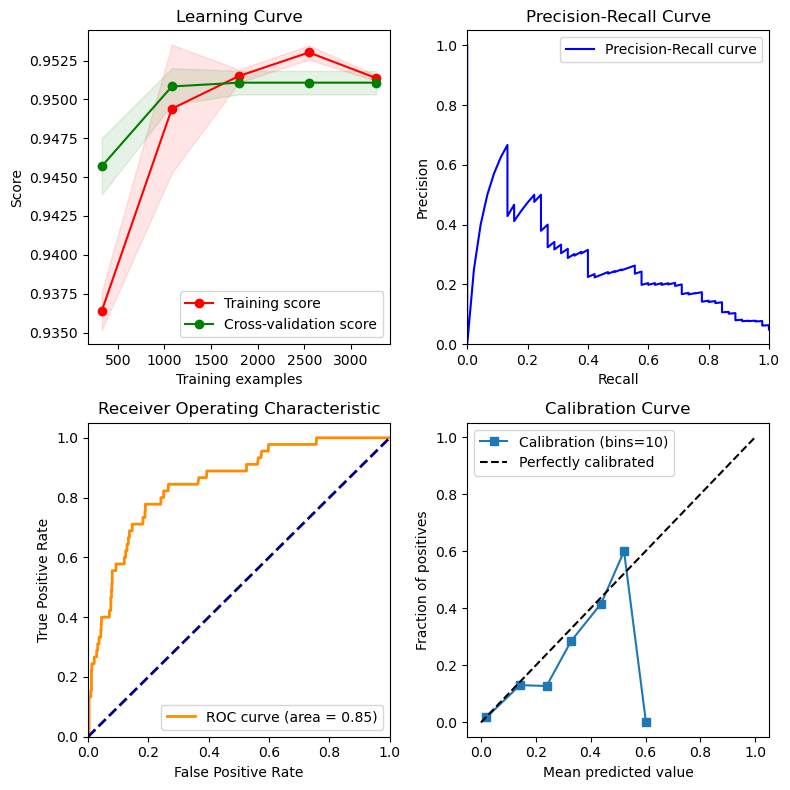

In [12]:
# Learning Curve
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = best_estimator,
    X = X_train,
    y = y_train,
    train_sizes = [0.1, 0.33, 0.55, 0.78, 1. ],
    cv = 5,
    scoring = 'accuracy'
)

# Calculating mean and standard deviation for train and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# For the ROC and precision-recall curves, you need probability scores
y_train_scores = grid.predict_proba(X_train)[:, 1]  # Probabilities for the positive class on the training set
y_val_scores = grid.predict_proba(X_val)[:, 1]      # Probabilities for the positive class on the validation set

# ROC Curve for Validation Set
fpr, tpr, _ = roc_curve(y_val, y_val_scores)
roc_auc = roc_auc_score(y_val, y_val_scores)

# Precision-Recall Curve for Validation Set
precision, recall, _ = precision_recall_curve(y_val, y_val_scores)

# Calibration Curve for Validation Set
prob_true, prob_pred = calibration_curve(y_val, y_val_scores, n_bins=10)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Learning Curve
axes[0, 0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="r")
axes[0, 0].fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                        validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
axes[0, 0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
axes[0, 0].plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
axes[0, 0].set_title("Learning Curve")
axes[0, 0].set_xlabel("Training examples")
axes[0, 0].set_ylabel("Score")
axes[0, 0].legend(loc="best")

# Update the precision-recall curve plot to a continuous line graph
axes[0, 1].clear()  # Clearing the previous step plot
axes[0, 1].plot(recall, precision, color='b', label='Precision-Recall curve')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].legend(loc="best")

# ROC Curve
axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('Receiver Operating Characteristic')
axes[1, 0].legend(loc="lower right")

# Calibration Curve
axes[1, 1].plot(prob_pred, prob_true, 's-', label='Calibration (bins=10)')
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
axes[1, 1].set_ylabel('Fraction of positives')
axes[1, 1].set_xlabel('Mean predicted value')
axes[1, 1].set_title('Calibration Curve')
axes[1, 1].legend(loc="best")

plt.tight_layout()
plt.show()


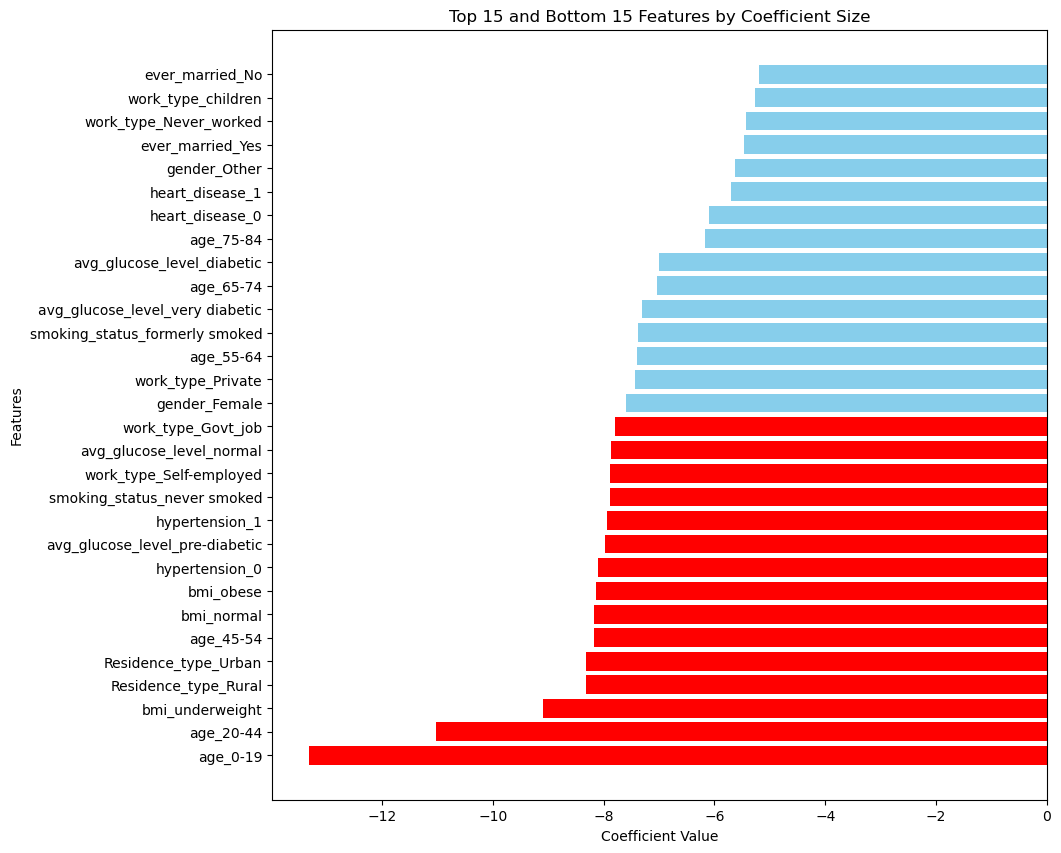

In [13]:
# Extracting coefficients
coefficients = best_estimator.coef_[0]

# Assuming 'X_train' columns are the feature names
feature_names = X_train.columns

# Creating a DataFrame for features and coefficients
coef_df = pd.DataFrame({'feat': feature_names, 'coef': coefficients})

# Sorting coefficients
coef_df.sort_values('coef', ascending=True, inplace=True)

# Selecting top 10 and bottom 10 features
num_to_show = 15
top = coef_df.head(num_to_show)
bottom = coef_df.tail(num_to_show)

# Concatenating for the plot
selected_features = pd.concat([top, bottom])

# Coloring top and bottom bars differently
plt.figure(figsize=(10, 10))
plt.barh(top['feat'], top['coef'], color='red')
plt.barh(bottom['feat'], bottom['coef'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title(f'Top {num_to_show} and Bottom {num_to_show} Features by Coefficient Size')
plt.show()


In [14]:
# coef_df.sort_values('coef',ascending=False).head()
coef_df.max()

feat    work_type_children
coef             -5.188734
dtype: object

In [17]:
train_confusion_df

No Stroke  Stroke
No Stroke       3883       6
Stroke           248    3641

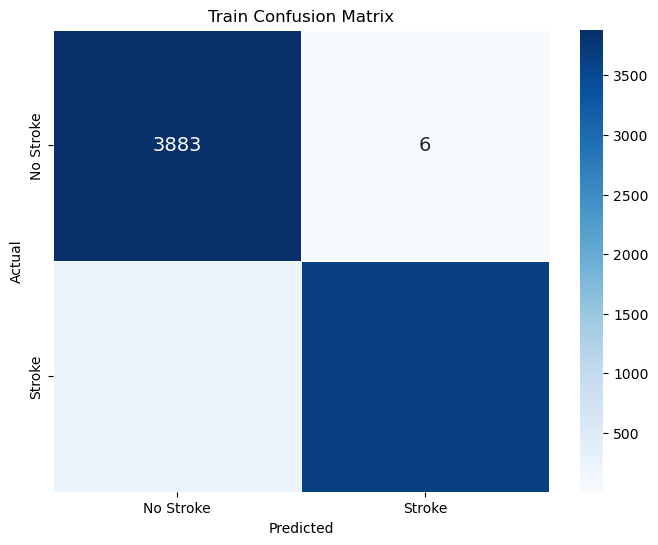

In [15]:
# Plotting training confusion matrix
train_confusion_df.rename(index   = {'True_Negative': 'No Stroke','True_Positive': 'Stroke'},
                          columns = {'Predicted_Negative': 'No Stroke','Predicted_Positive': 'Stroke'}, inplace=True)
plt.figure(figsize=(8, 6))
sns.heatmap(train_confusion_df, annot=True, fmt='d', cmap='Blues', linewidths=.5, annot_kws={"size": 14})
plt.title('Train Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

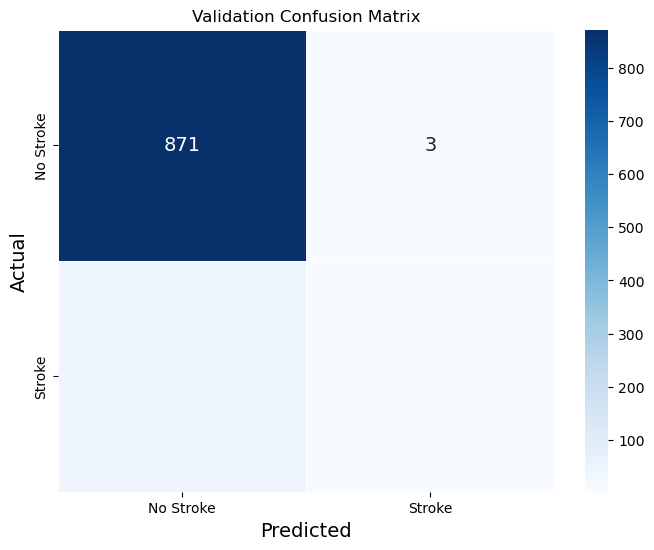

In [18]:
# Plotting validation confusion matrix
val_confusion_df.rename(index   = {'True_Negative': 'No Stroke','True_Positive': 'Stroke'},
                        columns = {'Predicted_Negative': 'No Stroke','Predicted_Positive': 'Stroke'}, inplace=True)
plt.figure(figsize=(8, 6))
sns.heatmap(val_confusion_df, annot=True, fmt='d', cmap='Blues', linewidths=.5, annot_kws={"size": 14})
plt.title('Validation Confusion Matrix')
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.show()

## Deep Learning

In [19]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    #tf.random.set_seed(0)

    # Start with a Sequential model
    model = tf.keras.Sequential()
    # Add input layer
    model.add(tf.keras.layers.Input(shape=(34)))
    # Flatten
    model.add(tf.keras.layers.Flatten())
    # Add hidden layers
    for hidden_layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                        activation=activation))

    # Add output layer
    # Note: Final layer activation is "sigmoid" for binary classification
    model.add(tf.keras.layers.Dense(units=n_classes,
                                    use_bias=True,
                                    activation='sigmoid',
                                    #kernel_initializer=initializers.RandomNormal(stddev=0.01),
                                    #bias_initializer=initializers.RandomNormal(stddev=0.01)
                                   ))

    # Add optimizer, if specified as 'Adam'
    if optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam()
    # Else optimizer = 'SGD'
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


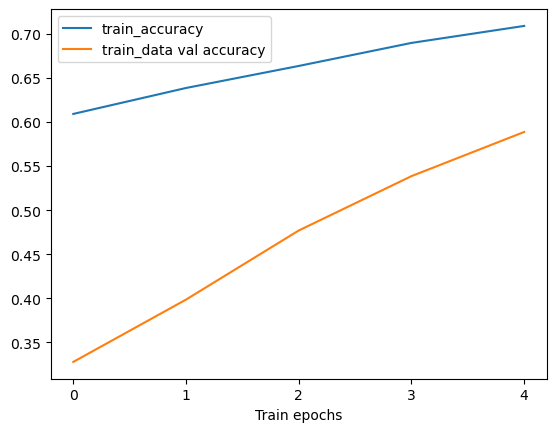

For hidden_layer_sizes=[], actv=tanh, opt=SGD, learning_rate=0.01, num_epochs=5
#PARAMETERS:  35
Accuracy from actual validation data :  0.8563656210899353

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


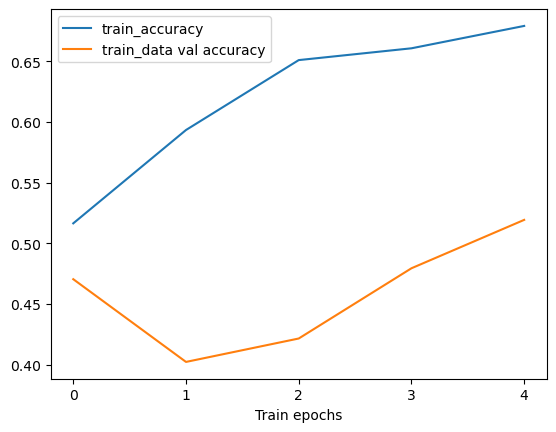

For hidden_layer_sizes=[8], actv=relu, opt=SGD, learning_rate=0.01, num_epochs=5
#PARAMETERS:  289
Accuracy from actual validation data :  0.8161044716835022

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


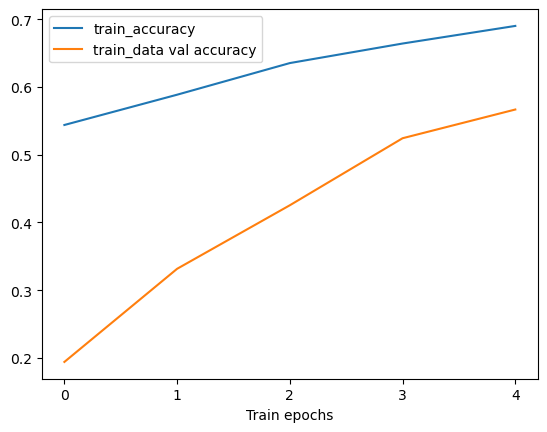

For hidden_layer_sizes=[16], actv=relu, opt=SGD, learning_rate=0.01, num_epochs=5
#PARAMETERS:  577
Accuracy from actual validation data :  0.8106637597084045

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


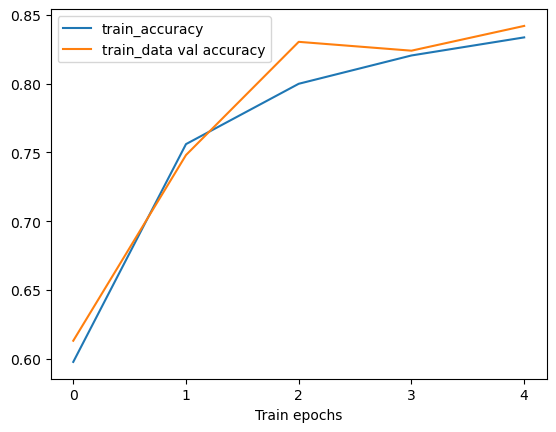

For hidden_layer_sizes=[16], actv=tanh, opt=Adam, learning_rate=0.01, num_epochs=5
#PARAMETERS:  577
Accuracy from actual validation data :  0.8650707006454468

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


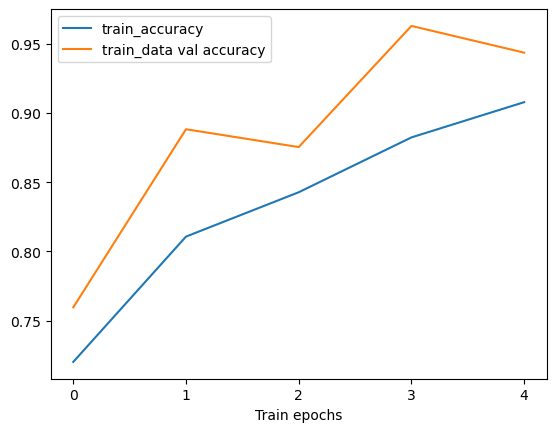

For hidden_layer_sizes=[64], actv=tanh, opt=SGD, learning_rate=0.1, num_epochs=5
#PARAMETERS:  2305
Accuracy from actual validation data :  0.9129488468170166



In [20]:
def train_and_evaluate(hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5):

  # Build the model.
  model = build_model(n_classes=1,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

  # Select the dataset.
  X_DL_train = X_res
  X_DL_val = X_val
  Y_DL_train = y_res
  Y_DL_val = y_val

  print("X_DL_train.shape = ", X_DL_train.shape)
  print("X_DL_val.shape = ", X_DL_val.shape)
  print("Y_DL_train.shape = ", Y_DL_train.shape)
  print("Y_DL_val.shape = ", Y_DL_val.shape)

  # Train the model.
  print('Training model ...')
  history = model.fit(
    x=X_DL_train,
    y=Y_DL_train,
    epochs=num_epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  train_accuracy = history.history['accuracy']
  train_val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(train_val_accuracy, label='train_data val accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  #Now evaluate on **actual** validation data
  actual_val_accuracy = model.evaluate(x=X_DL_val, y=Y_DL_val, verbose=0,
                                 return_dict=True)['accuracy']

  # NOTE: Modified this function to compute the paramter count
  total_params = model.count_params()

   # NOTE: Modified this function to also return total_params
  return actual_val_accuracy, total_params

# Experiments Results

val_accuracy, total_params = train_and_evaluate([], 'tanh', 'SGD', 0.01, 5)
print('For hidden_layer_sizes=[], actv=tanh, opt=SGD, learning_rate=0.01, num_epochs=5')
print('#PARAMETERS: ', total_params)
print('Accuracy from actual validation data : ', val_accuracy)
print()


val_accuracy, total_params = train_and_evaluate([8], 'relu', 'SGD', 0.01, 5)
print('For hidden_layer_sizes=[8], actv=relu, opt=SGD, learning_rate=0.01, num_epochs=5')
print('#PARAMETERS: ', total_params)
print('Accuracy from actual validation data : ', val_accuracy)
print()

val_accuracy, total_params = train_and_evaluate([16], 'tanh', 'SGD', 0.01, 5)
print('For hidden_layer_sizes=[16], actv=relu, opt=SGD, learning_rate=0.01, num_epochs=5')
print('#PARAMETERS: ', total_params)
print('Accuracy from actual validation data : ', val_accuracy)
print()

val_accuracy, total_params = train_and_evaluate([16], 'tanh', 'Adam', 0.01, 5)
print('For hidden_layer_sizes=[16], actv=tanh, opt=Adam, learning_rate=0.01, num_epochs=5')
print('#PARAMETERS: ', total_params)
print('Accuracy from actual validation data : ', val_accuracy)
print()

val_accuracy, total_params = train_and_evaluate([64], 'tanh', 'SGD', 0.1, 5)
print('For hidden_layer_sizes=[64], actv=tanh, opt=SGD, learning_rate=0.1, num_epochs=5')
print('#PARAMETERS: ', total_params)
print('Accuracy from actual validation data : ', val_accuracy)
print()


## Train and evaluate with parameter function and number of FP, FN, TP and TN

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


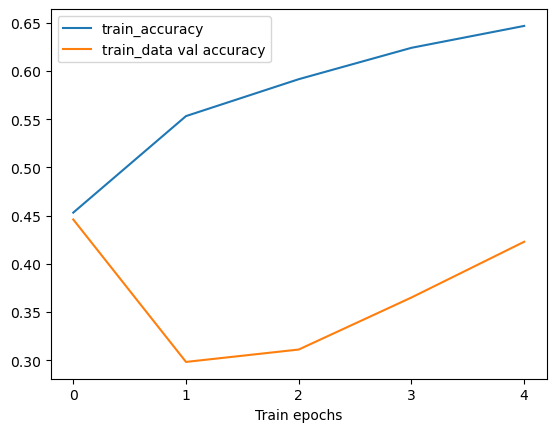

29/29 [==============================] - 0s 287us/step


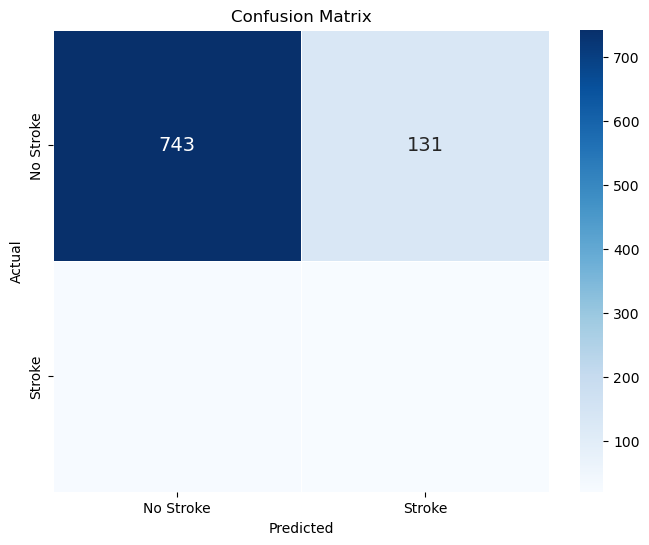

Experiment with Configuration: {'hidden_layer_sizes': [], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.01, 'num_epochs': 5, 'total_parameters': 35, 'validation_accuracy': 0.8302502632141113, 'TP': 20, 'FP': 131, 'TN': 743, 'FN': 25, 'confusion_matrix': array([[743, 131],
       [ 25,  20]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


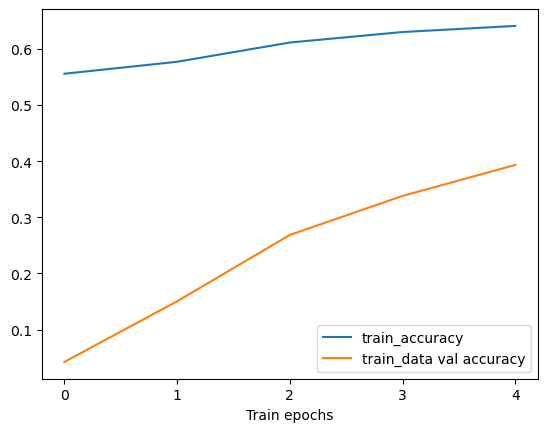

29/29 [==============================] - 0s 301us/step


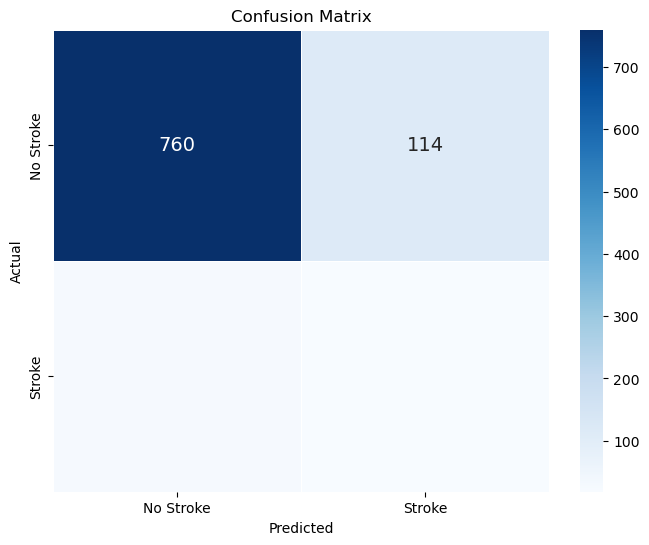

Experiment with Configuration: {'hidden_layer_sizes': [8], 'activation': 'relu', 'optimizer': 'SGD', 'learning_rate': 0.01, 'num_epochs': 5, 'total_parameters': 289, 'validation_accuracy': 0.8465723395347595, 'TP': 18, 'FP': 114, 'TN': 760, 'FN': 27, 'confusion_matrix': array([[760, 114],
       [ 27,  18]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


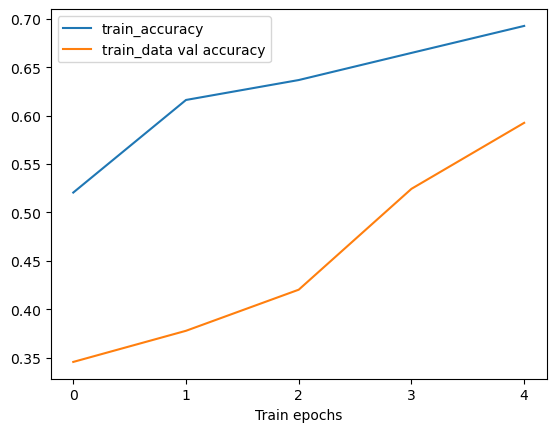

29/29 [==============================] - 0s 298us/step


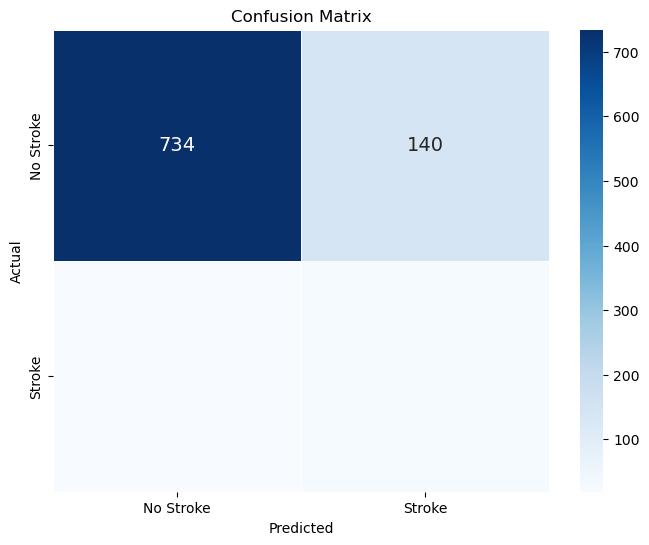

Experiment with Configuration: {'hidden_layer_sizes': [16], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.01, 'num_epochs': 5, 'total_parameters': 577, 'validation_accuracy': 0.8269858360290527, 'TP': 26, 'FP': 140, 'TN': 734, 'FN': 19, 'confusion_matrix': array([[734, 140],
       [ 19,  26]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


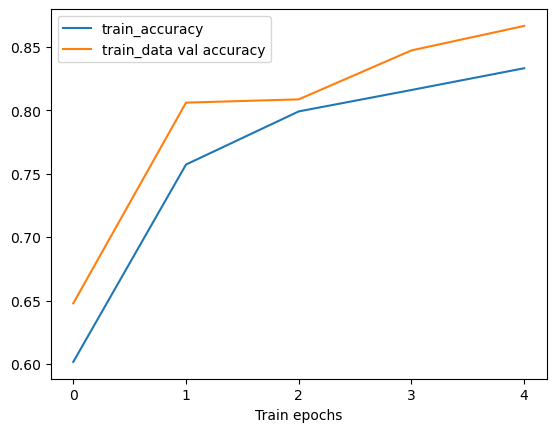

29/29 [==============================] - 0s 311us/step


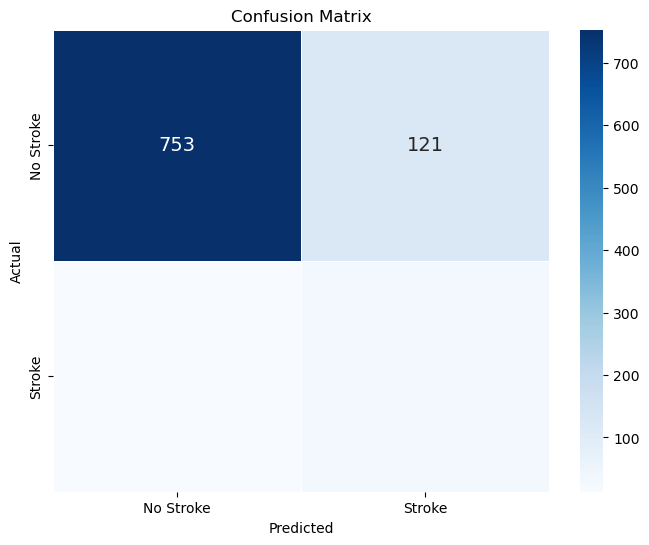

Experiment with Configuration: {'hidden_layer_sizes': [16], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.01, 'num_epochs': 5, 'total_parameters': 577, 'validation_accuracy': 0.8541893362998962, 'TP': 32, 'FP': 121, 'TN': 753, 'FN': 13, 'confusion_matrix': array([[753, 121],
       [ 13,  32]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


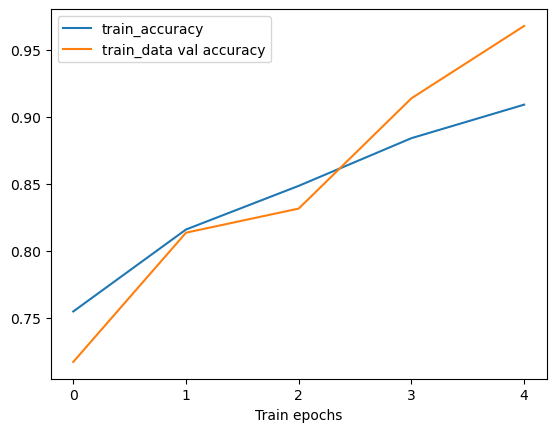

29/29 [==============================] - 0s 305us/step


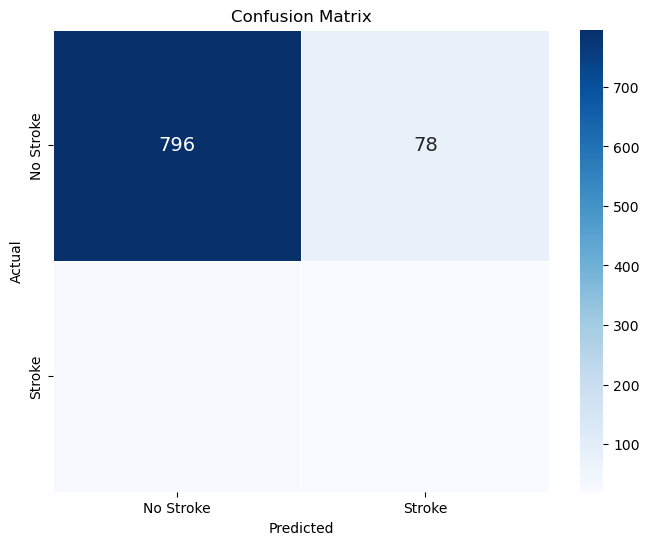

Experiment with Configuration: {'hidden_layer_sizes': [64], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.1, 'num_epochs': 5, 'total_parameters': 2305, 'validation_accuracy': 0.8879216313362122, 'TP': 20, 'FP': 78, 'TN': 796, 'FN': 25, 'confusion_matrix': array([[796,  78],
       [ 25,  20]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


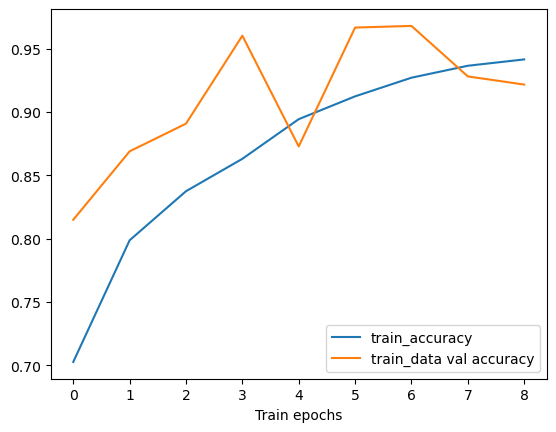

29/29 [==============================] - 0s 303us/step


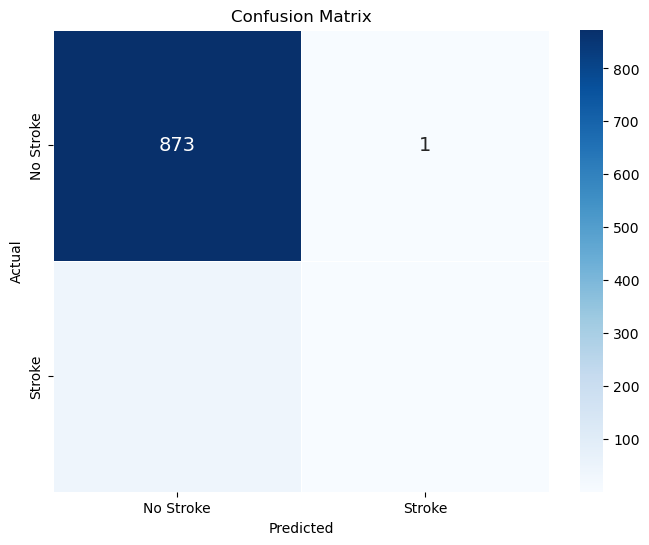

Experiment with Configuration: {'hidden_layer_sizes': [81], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.08260765279918306, 'num_epochs': 9, 'total_parameters': 2917, 'validation_accuracy': 0.9510337114334106, 'TP': 1, 'FP': 1, 'TN': 873, 'FN': 44, 'confusion_matrix': array([[873,   1],
       [ 44,   1]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


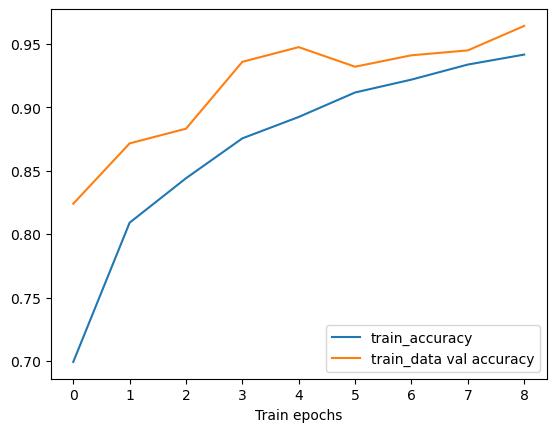

29/29 [==============================] - 0s 301us/step


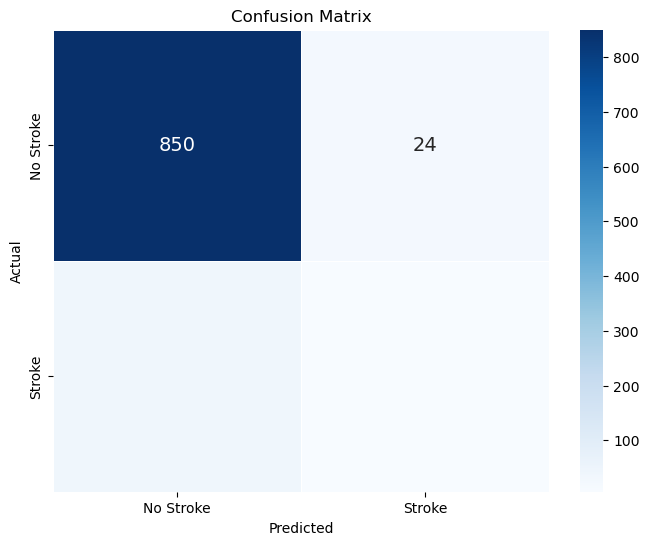

Experiment with Configuration: {'hidden_layer_sizes': [81], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.020248551640979554, 'num_epochs': 9, 'total_parameters': 2917, 'validation_accuracy': 0.9314472079277039, 'TP': 6, 'FP': 24, 'TN': 850, 'FN': 39, 'confusion_matrix': array([[850,  24],
       [ 39,   6]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


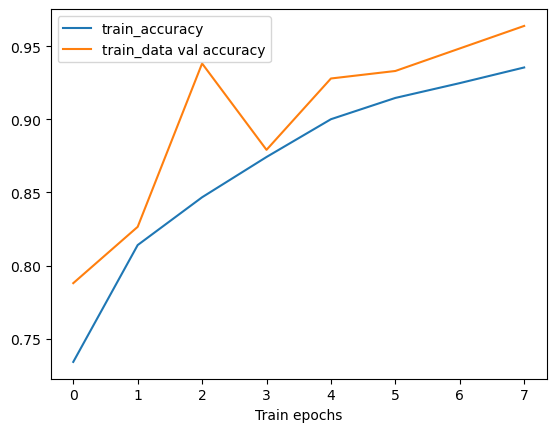

29/29 [==============================] - 0s 304us/step


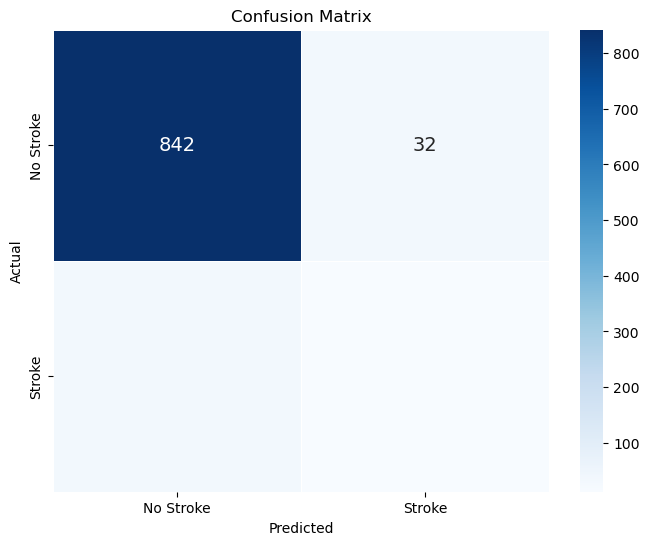

Experiment with Configuration: {'hidden_layer_sizes': [82], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.018556580032488137, 'num_epochs': 8, 'total_parameters': 2953, 'validation_accuracy': 0.9292709231376648, 'TP': 12, 'FP': 32, 'TN': 842, 'FN': 33, 'confusion_matrix': array([[842,  32],
       [ 33,  12]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


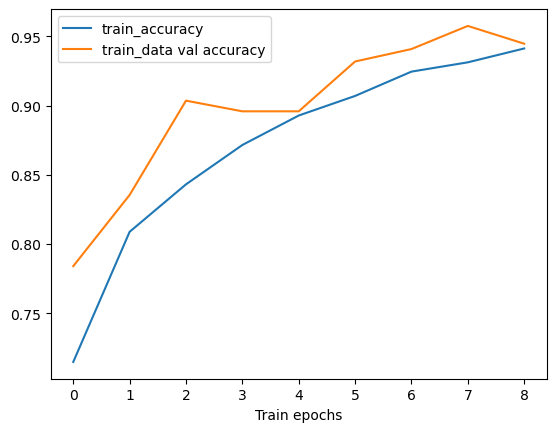

29/29 [==============================] - 0s 317us/step


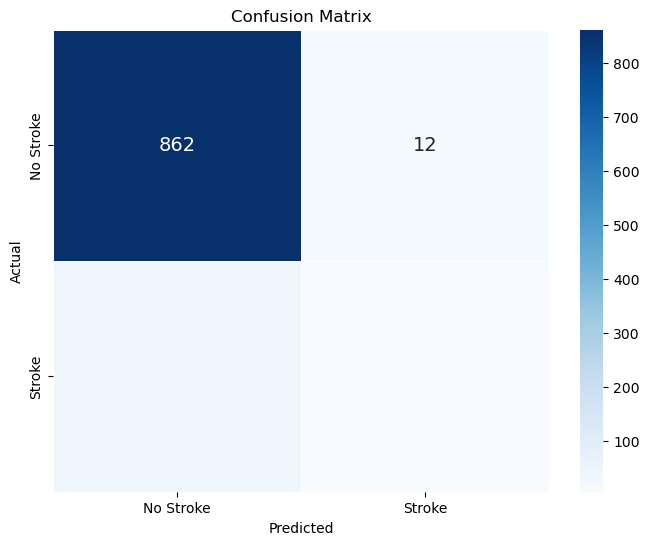

Experiment with Configuration: {'hidden_layer_sizes': [84], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.019154807186818695, 'num_epochs': 9, 'total_parameters': 3025, 'validation_accuracy': 0.9434167742729187, 'TP': 5, 'FP': 12, 'TN': 862, 'FN': 40, 'confusion_matrix': array([[862,  12],
       [ 40,   5]])}

X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


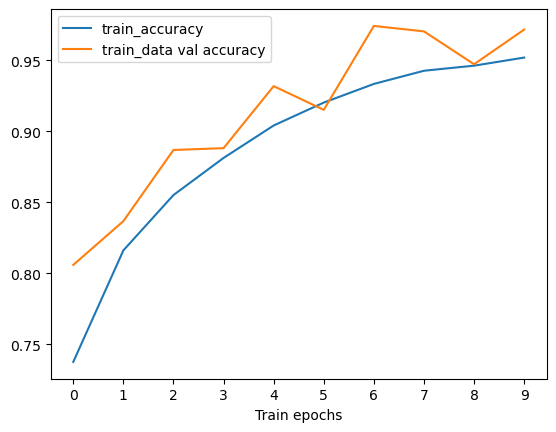

29/29 [==============================] - 0s 314us/step


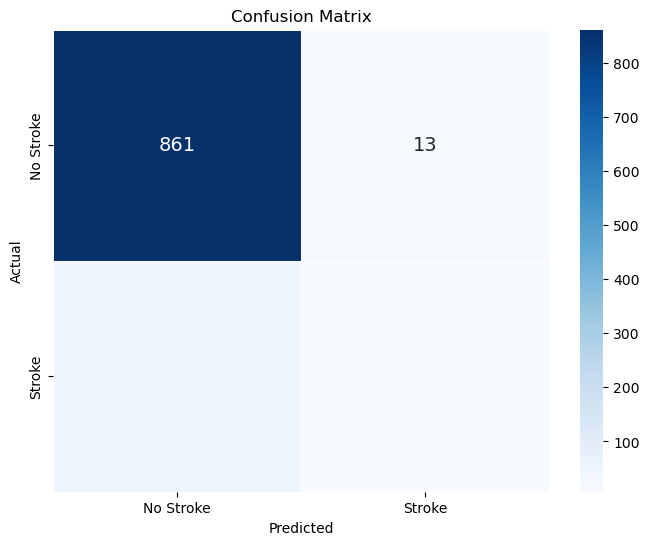

Experiment with Configuration: {'hidden_layer_sizes': [115], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.013250663299162593, 'num_epochs': 10, 'total_parameters': 4141, 'validation_accuracy': 0.9445049166679382, 'TP': 7, 'FP': 13, 'TN': 861, 'FN': 38, 'confusion_matrix': array([[861,  13],
       [ 38,   7]])}



In [42]:
# train and evaluate with parameter function and add FP,FN,TP and TN + confusion matrix to return function

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    # convert the numpy array to DataFrame
    cm_df = pd.DataFrame(cm,
                         index=['No Stroke', 'Stroke'],
                         columns=['No Stroke', 'Stroke'])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap='Blues', linewidths=.5, annot_kws={"size": 14})
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def train_and_evaluate(hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='SGD',
                       learning_rate=0.01,
                       num_epochs=5):


  # Build the model
  model = build_model(n_classes=1,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

  # Select the dataset
  X_DL_train = X_res
  X_DL_val = X_val
  Y_DL_train = y_res
  Y_DL_val = y_val

  print("X_DL_train.shape = ", X_DL_train.shape)
  print("X_DL_val.shape = ", X_DL_val.shape)
  print("Y_DL_train.shape = ", Y_DL_train.shape)
  print("Y_DL_val.shape = ", Y_DL_val.shape)

  # Train the model
  print('Training model ...')
  history = model.fit(
    x=X_DL_train,
    y=Y_DL_train,
    epochs=num_epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

  # Retrieve the training metrics after each train epoch
  train_accuracy = history.history['accuracy']
  train_val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(train_val_accuracy, label='train_data val accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  #Evaluate on actual validation data
  actual_val_accuracy = model.evaluate(x=X_DL_val, y=Y_DL_val, verbose=0,
                                 return_dict=True)['accuracy']

  # Compute the parameter count
  total_params = model.count_params()

  # Evaluate on actual validation data
  actual_val_accuracy = model.evaluate(x=X_DL_val, y=Y_DL_val, verbose=0,
                                      return_dict=True)['accuracy']

  # Predictions for the validation set
  predictions = model.predict(X_DL_val)
  # Convert probabilities to binary labels (0 or 1) based on a 0.5 threshold
  predicted_labels = (predictions > 0.5).astype(int)

  # Calculate confusion matrix
  cm = confusion_matrix(Y_DL_val, predicted_labels)
  tn, fp, fn, tp = cm.ravel()

  # Plot the confusion matrix
  plot_confusion_matrix(cm, title='Confusion Matrix')

  # Return a summary dictionary instead of individual prints
  return {
      'hidden_layer_sizes': hidden_layer_sizes,
      'activation': activation,
      'optimizer': optimizer,
      'learning_rate': learning_rate,
      'num_epochs': num_epochs,
      'total_parameters': total_params,
      'validation_accuracy': actual_val_accuracy,
      'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn,
      'confusion_matrix': cm
  }

# List of experiments to run
experiments = [
    {'hidden_layer_sizes': [], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.01, 'num_epochs': 5},
    {'hidden_layer_sizes': [8], 'activation': 'relu', 'optimizer': 'SGD', 'learning_rate': 0.01, 'num_epochs': 5},
    {'hidden_layer_sizes': [16], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.01, 'num_epochs': 5},
    {'hidden_layer_sizes': [16], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.01, 'num_epochs': 5},
    {'hidden_layer_sizes': [64], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.1, 'num_epochs': 5},
    
    {'hidden_layer_sizes': [81], 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.08260765279918306, 'num_epochs': 9},
    {'hidden_layer_sizes': [81], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.020248551640979554, 'num_epochs': 9},
    {'hidden_layer_sizes': [82], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.018556580032488137, 'num_epochs': 8},
    {'hidden_layer_sizes': [84], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.019154807186818695, 'num_epochs': 9},
    {'hidden_layer_sizes': [115], 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.013250663299162593, 'num_epochs': 10},
]

# Running all experiments and printing results
for exp in experiments:
    result = train_and_evaluate(**exp)
    print('Experiment with Configuration:', result)
    print()

## Visualizations

In [ ]:
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))

In [ ]:
# Learning Curve
train_sizes, train_scores, validation_scores = learning_curve(
    estimator = best_estimator,
    X = X_train,
    y = y_train,
    train_sizes = [0.1, 0.33, 0.55, 0.78, 1. ],
    cv = 5,
    scoring = 'accuracy'
)

# Calculating mean and standard deviation for train and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# For the ROC and precision-recall curves, you need probability scores
y_train_scores = grid.predict_proba(X_train)[:, 1]  # Probabilities for the positive class on the training set
y_val_scores = grid.predict_proba(X_val)[:, 1]      # Probabilities for the positive class on the validation set

# ROC Curve for Validation Set
fpr, tpr, _ = roc_curve(y_val, y_val_scores)
roc_auc = roc_auc_score(y_val, y_val_scores)

# Precision-Recall Curve for Validation Set
precision, recall, _ = precision_recall_curve(y_val, y_val_scores)

# Calibration Curve for Validation Set
prob_true, prob_pred = calibration_curve(y_val, y_val_scores, n_bins=10)

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Learning Curve
axes[0, 0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="r")
axes[0, 0].fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                        validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
axes[0, 0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
axes[0, 0].plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
axes[0, 0].set_title("Learning Curve")
axes[0, 0].set_xlabel("Training examples")
axes[0, 0].set_ylabel("Score")
axes[0, 0].legend(loc="best")

# Update the precision-recall curve plot to a continuous line graph
axes[0, 1].clear()  # Clearing the previous step plot
axes[0, 1].plot(recall, precision, color='b', label='Precision-Recall curve')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].legend(loc="best")

# ROC Curve
axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('Receiver Operating Characteristic')
axes[1, 0].legend(loc="lower right")

# Calibration Curve
axes[1, 1].plot(prob_pred, prob_true, 's-', label='Calibration (bins=10)')
axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
axes[1, 1].set_ylabel('Fraction of positives')
axes[1, 1].set_xlabel('Mean predicted value')
axes[1, 1].set_title('Calibration Curve')
axes[1, 1].legend(loc="best")

plt.tight_layout()
plt.show()


In [ ]:
# Extracting coefficients
coefficients = best_estimator.coef_[0]

# Assuming 'X_train' columns are the feature names
feature_names = X_train.columns

# Creating a DataFrame for features and coefficients
coef_df = pd.DataFrame({'feat': feature_names, 'coef': coefficients})

# Sorting coefficients
coef_df.sort_values('coef', ascending=True, inplace=True)

# Selecting top 10 and bottom 10 features
num_to_show = 15
top = coef_df.head(num_to_show)
bottom = coef_df.tail(num_to_show)

# Concatenating for the plot
selected_features = pd.concat([top, bottom])

# Coloring top and bottom bars differently
plt.figure(figsize=(10, 10))
plt.barh(top['feat'], top['coef'], color='red')
plt.barh(bottom['feat'], bottom['coef'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title(f'Top {num_to_show} and Bottom {num_to_show} Features by Coefficient Size')
plt.show()

In [ ]:
# coef_df.sort_values('coef',ascending=False).head()
coef_df.max()

In [ ]:
# Function to generate plots

def plot_evaluation_curves(train_sizes, train_scores, validation_scores, y_train, y_train_scores, y_val, y_val_scores):
    """
    Plots Learning Curve, ROC Curve, Precision-Recall Curve, and Calibration Curve.

    Args:
    train_sizes: Sizes of the training set.
    train_scores: Training scores from the learning curve.
    validation_scores: Validation scores from the learning curve.
    y_train: True labels for the training set.
    y_train_scores: Model scores on the training set.
    y_val: True labels for the validation set.
    y_val_scores: Model scores on the validation set.
    """
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    fpr, tpr, _ = roc_curve(y_val, y_val_scores)
    roc_auc = roc_auc_score(y_val, y_val_scores)

    # Precision-Recall Curve for Validation Set
    precision, recall, _ = precision_recall_curve(y_val, y_val_scores)

    # Calibration Curve for Validation Set
    prob_true, prob_pred = calibration_curve(y_val, y_val_scores, n_bins=10)

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    # Learning Curve
    axes[0, 0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                            train_scores_mean + train_scores_std, alpha=0.1,
                            color="r")
    axes[0, 0].fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                            validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    axes[0, 0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[0, 0].plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes[0, 0].set_title("Learning Curve")
    axes[0, 0].set_xlabel("Training examples")
    axes[0, 0].set_ylabel("Score")
    axes[0, 0].legend(loc="best")

    # Precision-Recall Curve
    axes[0, 1].plot(recall, precision, color='b', label='Precision-Recall curve')
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_ylim([0.0, 1.05])
    axes[0, 1].set_xlim([0.0, 1.0])
    axes[0, 1].set_title('Precision-Recall Curve')
    axes[0, 1].legend(loc="best")

    # ROC Curve
    axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title('Receiver Operating Characteristic')
    axes[1, 0].legend(loc="lower right")

    # Calibration Curve
    axes[1, 1].plot(prob_pred, prob_true, 's-', label='Calibration (bins=10)')
    axes[1, 1].plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    axes[1, 1].set_ylabel('Fraction of positives')
    axes[1, 1].set_xlabel('Mean predicted value')
    axes[1, 1].set_title('Calibration Curve')
    axes[1, 1].legend(loc="best")

    plt.tight_layout()
    plt.show()

plot_evaluation_curves(
    train_sizes=train_sizes,
    train_scores=train_scores,
    validation_scores=validation_scores,
    y_train=y_train,
    y_train_scores=y_train_scores,
    y_val=y_val,
    y_val_scores=y_val_scores
)

In [ ]:
# Function that returns optimal number of epochs to run to arrive at a stable validation accuracy

model = build_model(n_classes=1, hidden_layer_sizes=[64], activation='relu', optimizer='Adam', learning_rate=0.01)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), verbose=0)

def find_optimal_epochs(history, min_improvement=0.01, patience=3):
    """
    Determines the optimal number of epochs to train for stable validation accuracy.

    Args:
    history: The history object from Keras model training.
    min_improvement: Minimum improvement between epochs to consider as significant.
    patience: Number of epochs to wait for an improvement before stopping.

    Returns:
    int: Optimal number of epochs for training.
    """
    val_accuracy = history.history['val_accuracy']
    best_accuracy = 0
    best_epoch = 0
    epochs_without_improvement = 0

    for epoch, accuracy in enumerate(val_accuracy):
        if accuracy > best_accuracy + min_improvement:
            best_accuracy = accuracy
            best_epoch = epoch
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            break

    return best_epoch + 1  # Adding 1 because epochs are zero-indexed

optimal_epochs = find_optimal_epochs(history, min_improvement=0.01, patience=3)
print(f'Optimal number of epochs: {optimal_epochs}')

[I 2023-11-30 12:57:02,191] A new study created in memory with name: no-name-629c06fe-2662-4dc3-a40b-2d12db720032


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


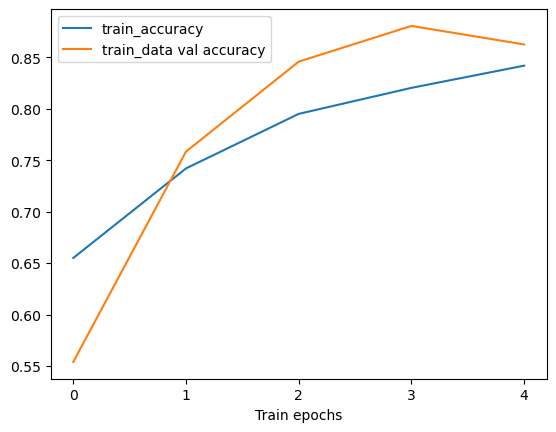

29/29 [==============================] - 0s 293us/step


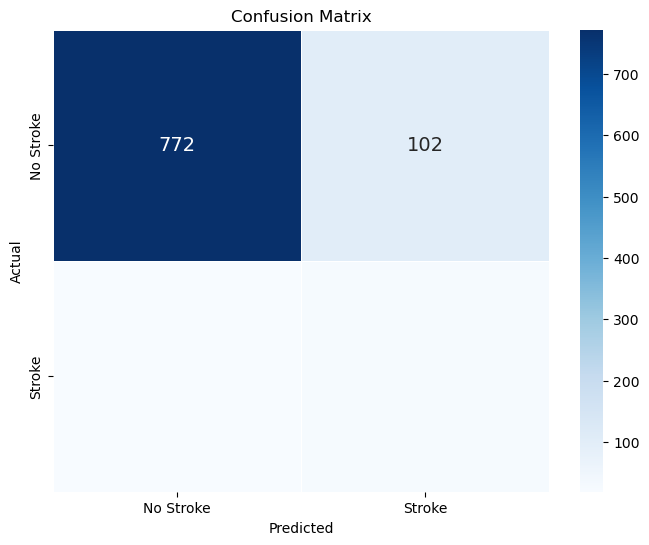

[I 2023-11-30 12:57:02,997] Trial 0 finished with value: 0.8683351278305054 and parameters: {'units_layer': 12, 'activation': 'relu', 'optimizer': 'SGD', 'learning_rate': 0.04593082061864425, 'num_epochs': 5}. Best is trial 0 with value: 0.8683351278305054.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


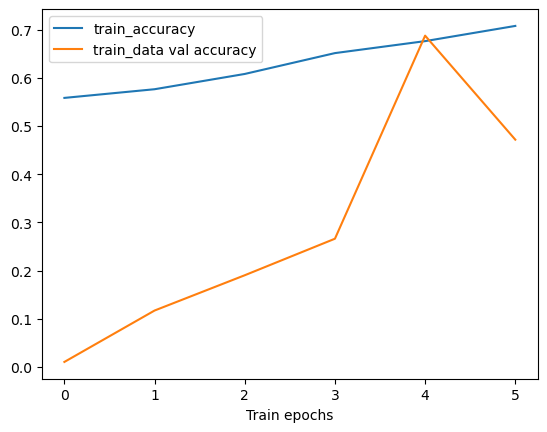

29/29 [==============================] - 0s 303us/step


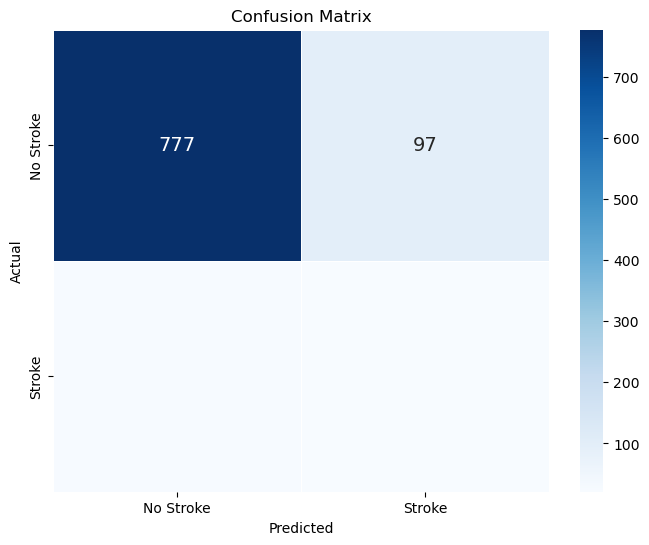

[I 2023-11-30 12:57:03,826] Trial 1 finished with value: 0.8683351278305054 and parameters: {'units_layer': 65, 'activation': 'sigmoid', 'optimizer': 'SGD', 'learning_rate': 0.023813725181093738, 'num_epochs': 6}. Best is trial 0 with value: 0.8683351278305054.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


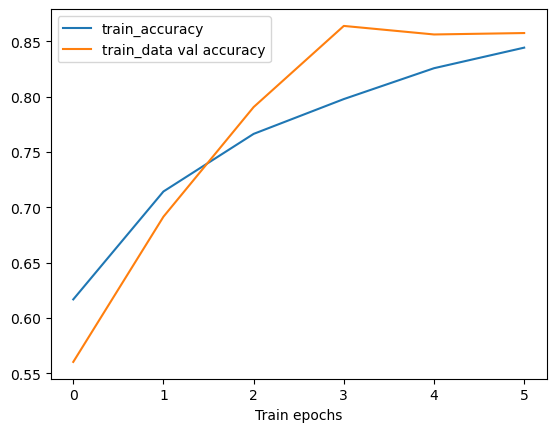

29/29 [==============================] - 0s 297us/step


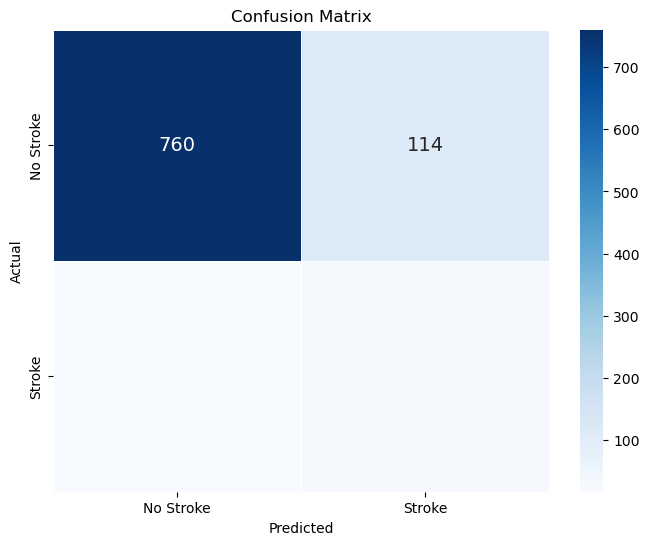

[I 2023-11-30 12:57:04,709] Trial 2 finished with value: 0.8574537634849548 and parameters: {'units_layer': 9, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.010792970710247698, 'num_epochs': 6}. Best is trial 0 with value: 0.8683351278305054.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


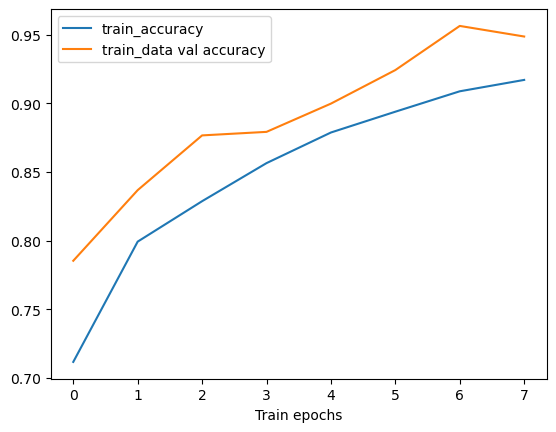

29/29 [==============================] - 0s 301us/step


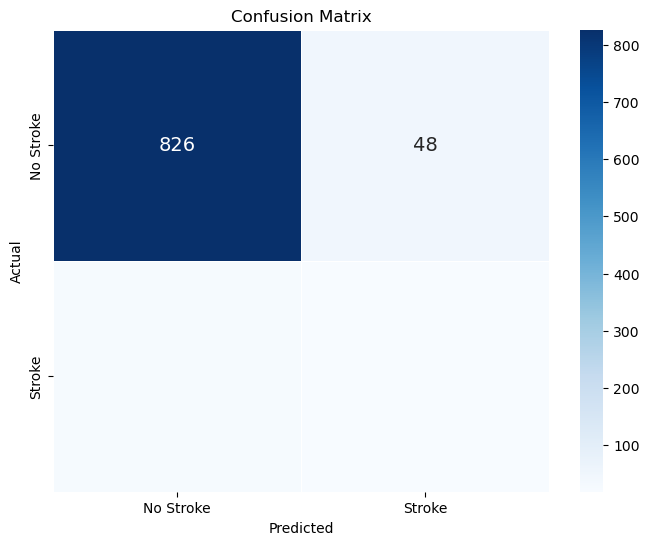

[I 2023-11-30 12:57:05,719] Trial 3 finished with value: 0.9194777011871338 and parameters: {'units_layer': 50, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.013530892424916298, 'num_epochs': 8}. Best is trial 3 with value: 0.9194777011871338.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


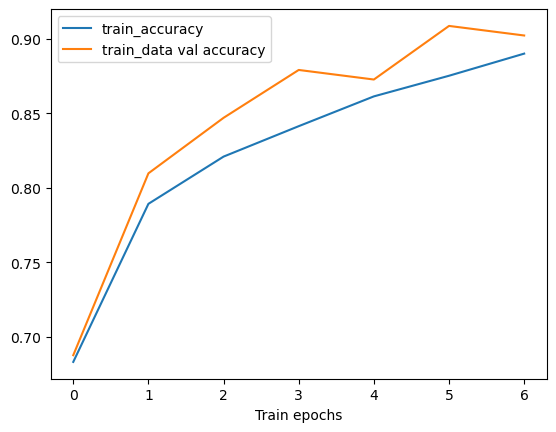

29/29 [==============================] - 0s 293us/step


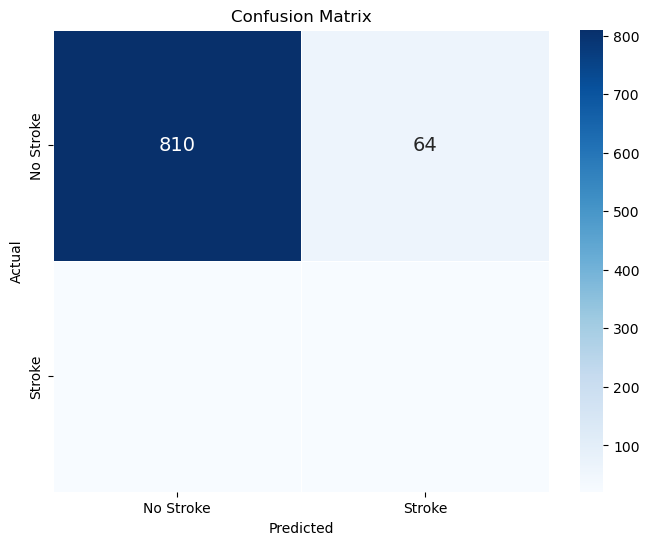

[I 2023-11-30 12:57:06,671] Trial 4 finished with value: 0.9042437672615051 and parameters: {'units_layer': 27, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.03791919445154349, 'num_epochs': 7}. Best is trial 3 with value: 0.9194777011871338.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


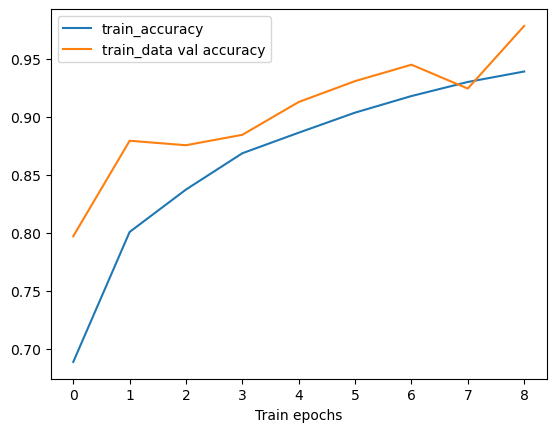

29/29 [==============================] - 0s 309us/step


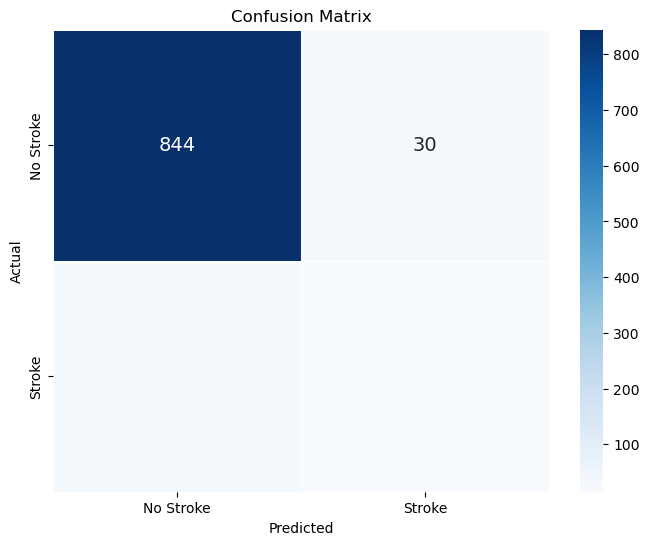

[I 2023-11-30 12:57:07,754] Trial 5 finished with value: 0.9347116351127625 and parameters: {'units_layer': 85, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.019159831168143873, 'num_epochs': 9}. Best is trial 5 with value: 0.9347116351127625.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


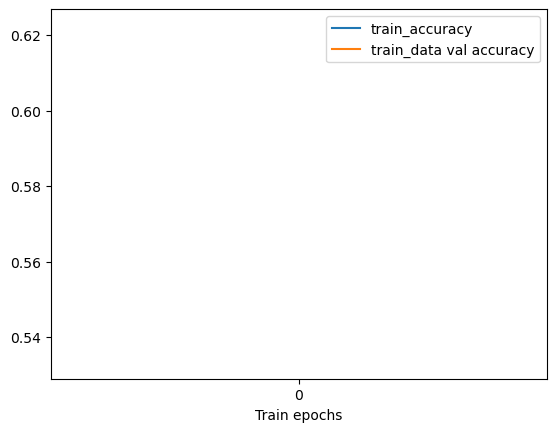

29/29 [==============================] - 0s 318us/step


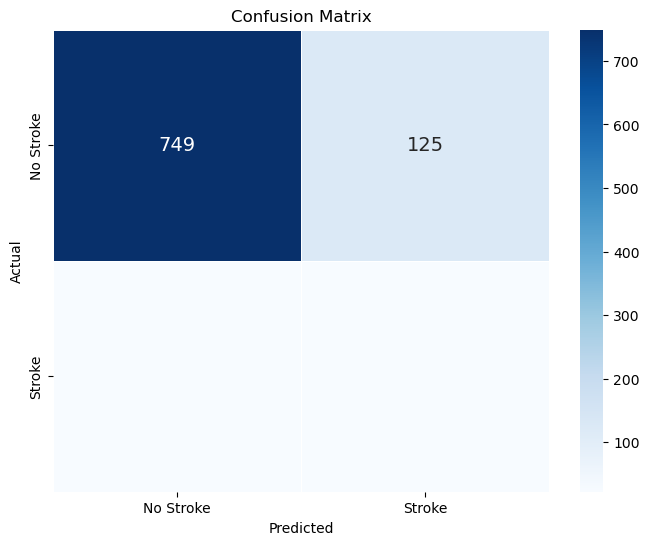

[I 2023-11-30 12:57:08,338] Trial 6 finished with value: 0.8400435447692871 and parameters: {'units_layer': 115, 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.014625959006662064, 'num_epochs': 1}. Best is trial 5 with value: 0.9347116351127625.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


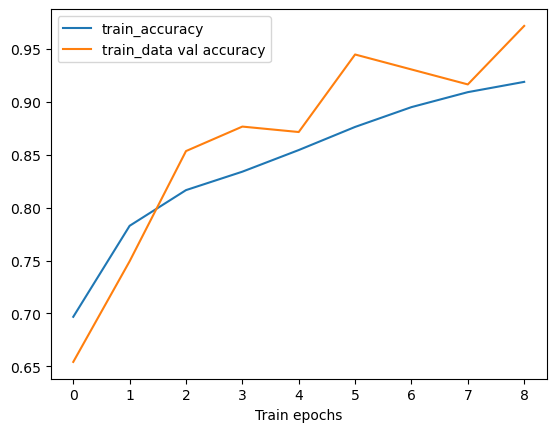

29/29 [==============================] - 0s 302us/step


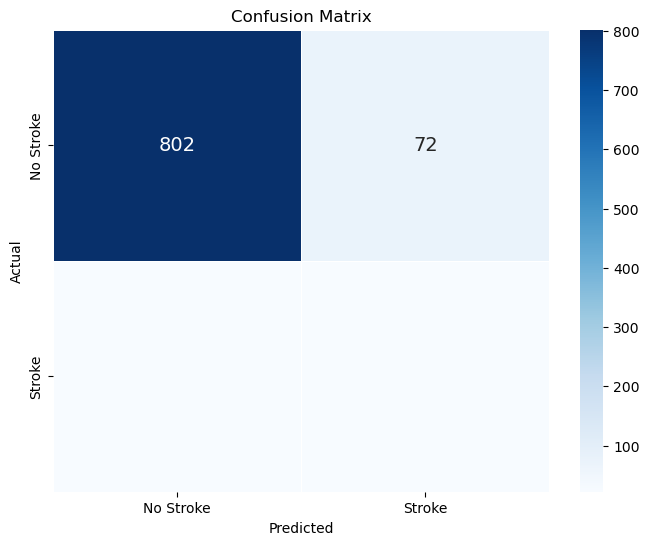

[I 2023-11-30 12:57:09,346] Trial 7 finished with value: 0.8977149128913879 and parameters: {'units_layer': 87, 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.05711377929146229, 'num_epochs': 9}. Best is trial 5 with value: 0.9347116351127625.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


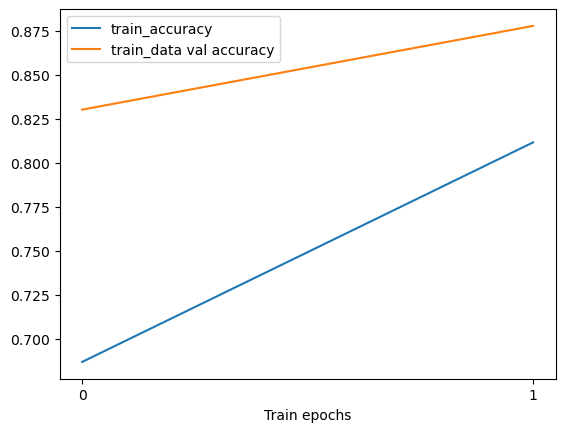

29/29 [==============================] - 0s 294us/step


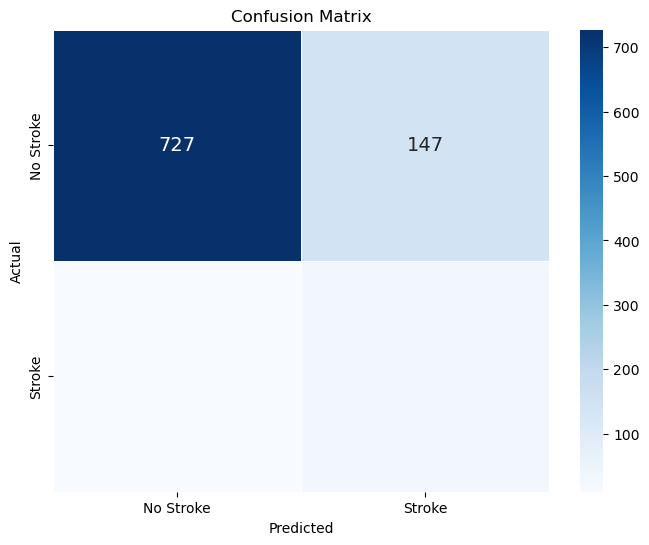

[I 2023-11-30 12:57:10,215] Trial 8 finished with value: 0.8291621208190918 and parameters: {'units_layer': 67, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.017681857333281762, 'num_epochs': 2}. Best is trial 5 with value: 0.9347116351127625.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


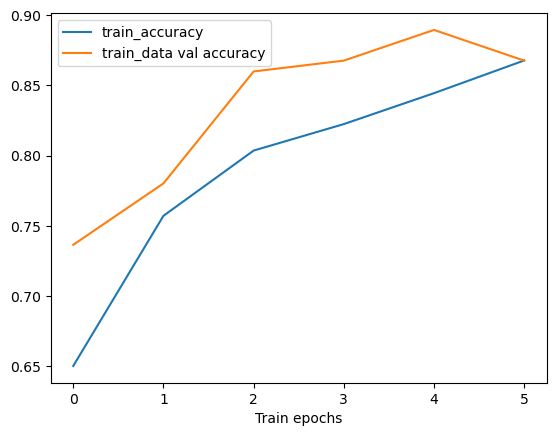

29/29 [==============================] - 0s 304us/step


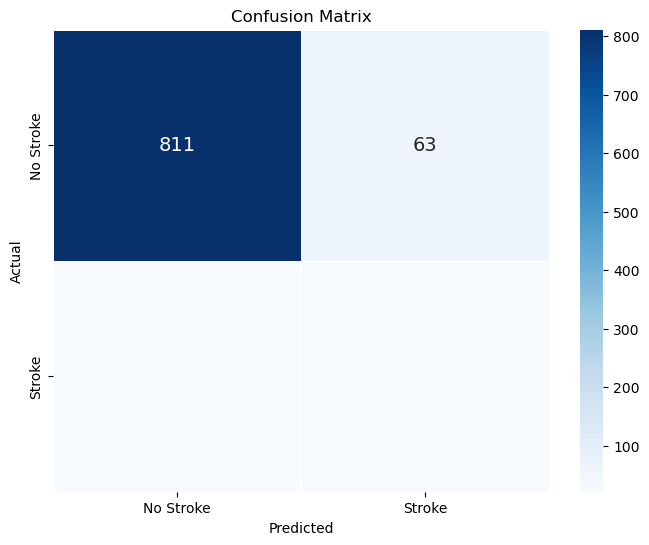

[I 2023-11-30 12:57:11,021] Trial 9 finished with value: 0.9053319096565247 and parameters: {'units_layer': 10, 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.06315932810027425, 'num_epochs': 6}. Best is trial 5 with value: 0.9347116351127625.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


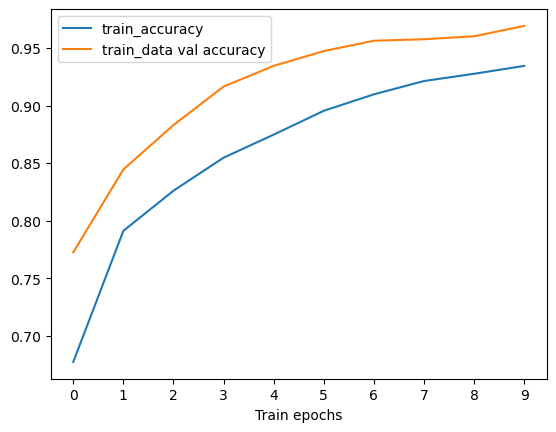

29/29 [==============================] - 0s 312us/step


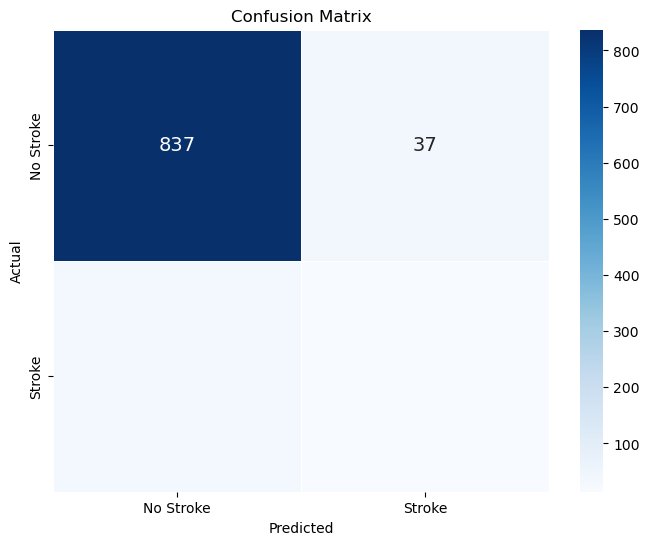

[I 2023-11-30 12:57:12,200] Trial 10 finished with value: 0.926006555557251 and parameters: {'units_layer': 121, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.027094281267751156, 'num_epochs': 10}. Best is trial 5 with value: 0.9347116351127625.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


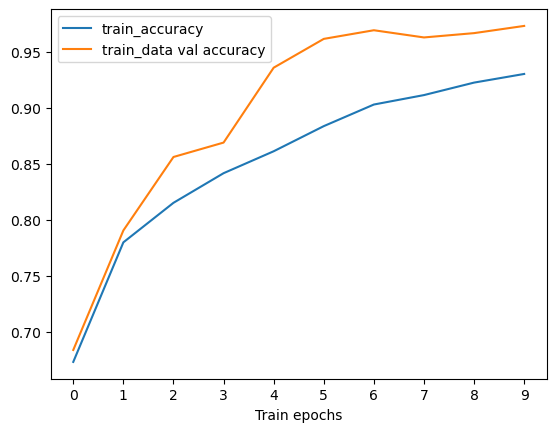

29/29 [==============================] - 0s 317us/step


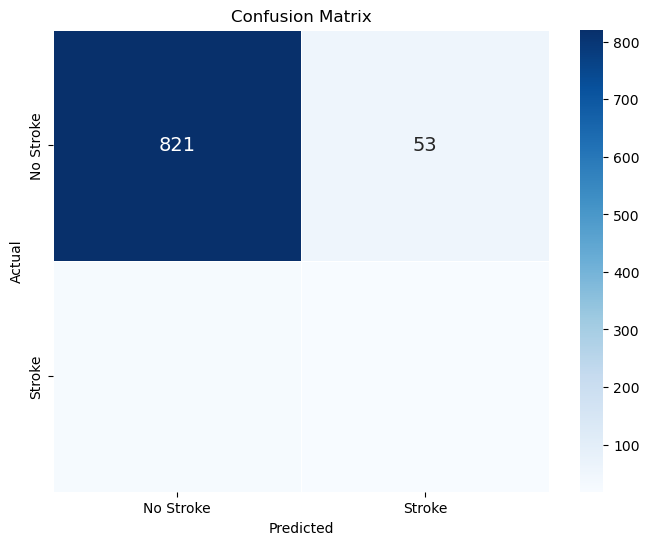

[I 2023-11-30 12:57:13,368] Trial 11 finished with value: 0.9129488468170166 and parameters: {'units_layer': 114, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.027427024924060513, 'num_epochs': 10}. Best is trial 5 with value: 0.9347116351127625.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


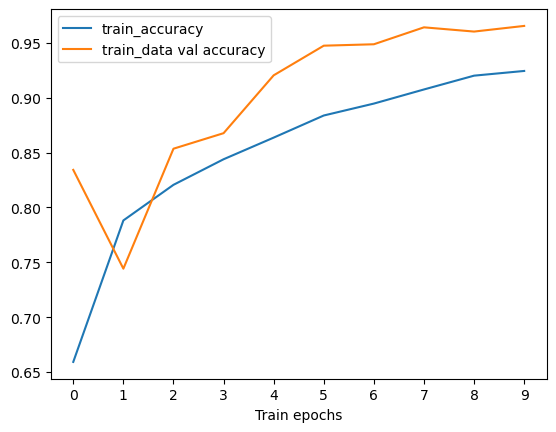

29/29 [==============================] - 0s 304us/step


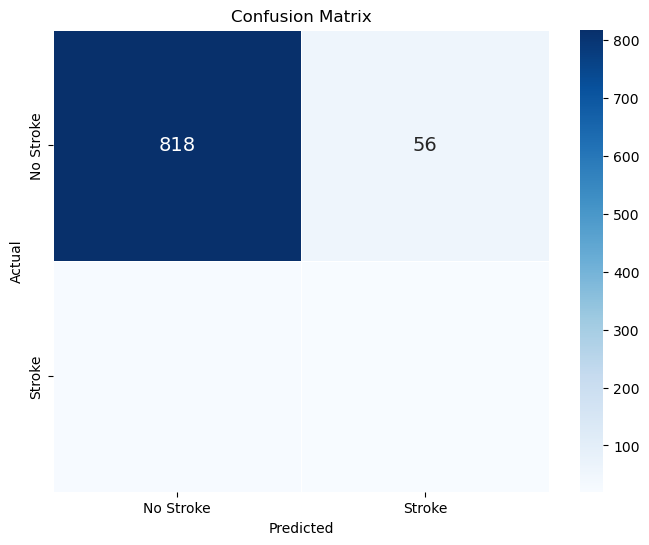

[I 2023-11-30 12:57:14,521] Trial 12 finished with value: 0.9118607044219971 and parameters: {'units_layer': 94, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.021736857906865713, 'num_epochs': 10}. Best is trial 5 with value: 0.9347116351127625.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


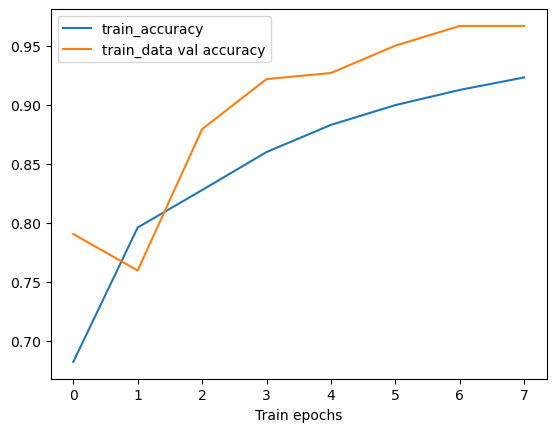

29/29 [==============================] - 0s 315us/step


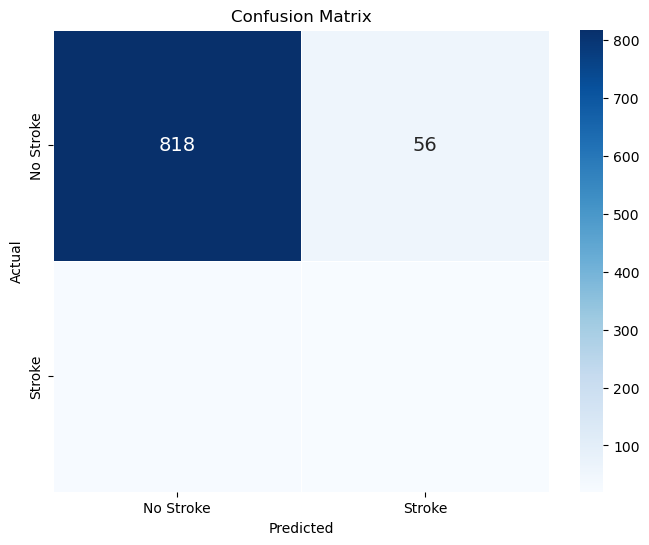

[I 2023-11-30 12:57:15,580] Trial 13 finished with value: 0.9118607044219971 and parameters: {'units_layer': 128, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.09634954772417074, 'num_epochs': 8}. Best is trial 5 with value: 0.9347116351127625.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


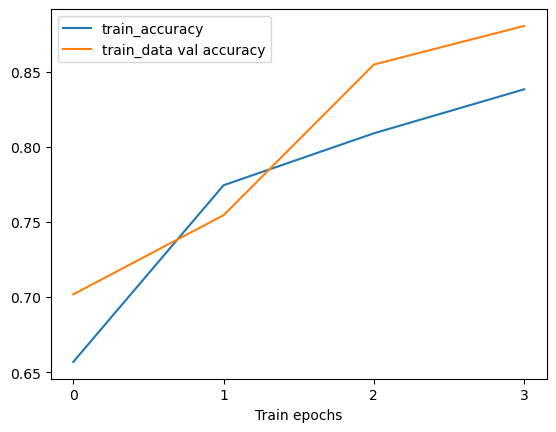

29/29 [==============================] - 0s 315us/step


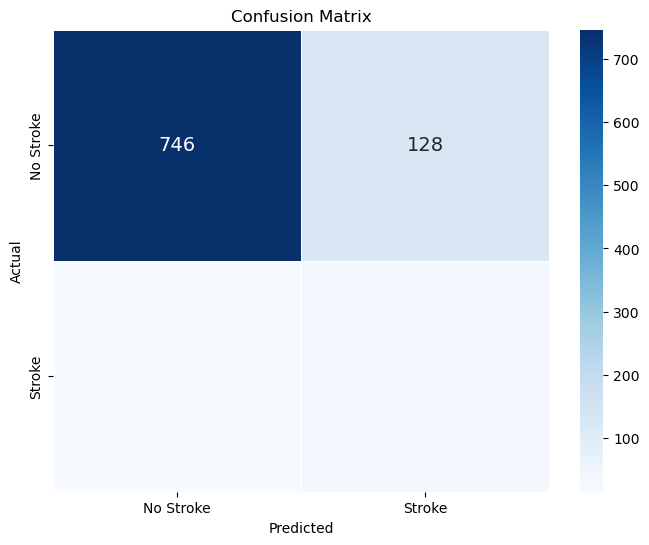

[I 2023-11-30 12:57:16,393] Trial 14 finished with value: 0.8443960547447205 and parameters: {'units_layer': 97, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.031338450927367256, 'num_epochs': 4}. Best is trial 5 with value: 0.9347116351127625.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


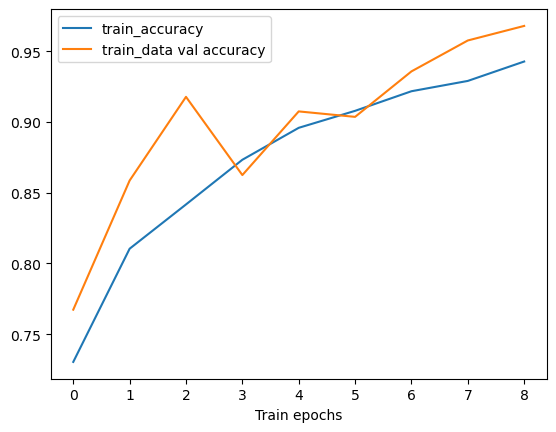

29/29 [==============================] - 0s 314us/step


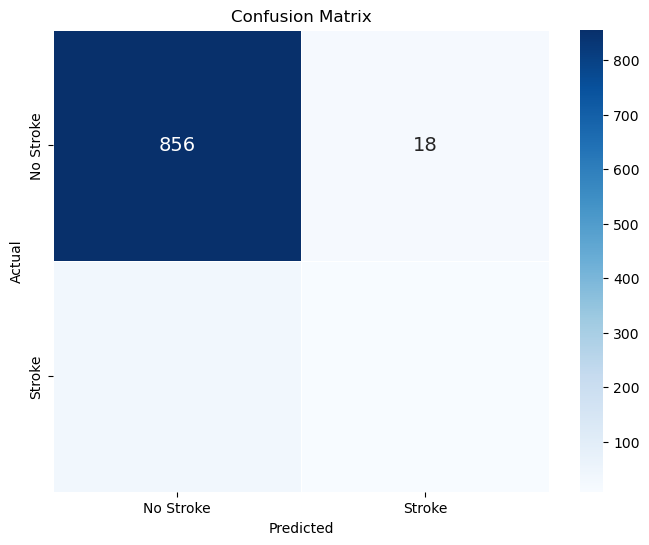

[I 2023-11-30 12:57:17,481] Trial 15 finished with value: 0.9401523470878601 and parameters: {'units_layer': 81, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.020248551640979554, 'num_epochs': 9}. Best is trial 15 with value: 0.9401523470878601.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


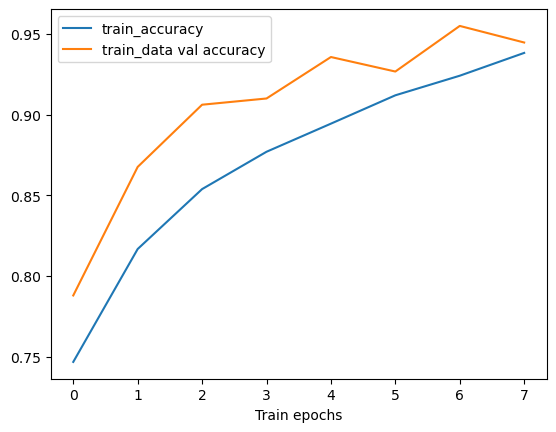

29/29 [==============================] - 0s 314us/step


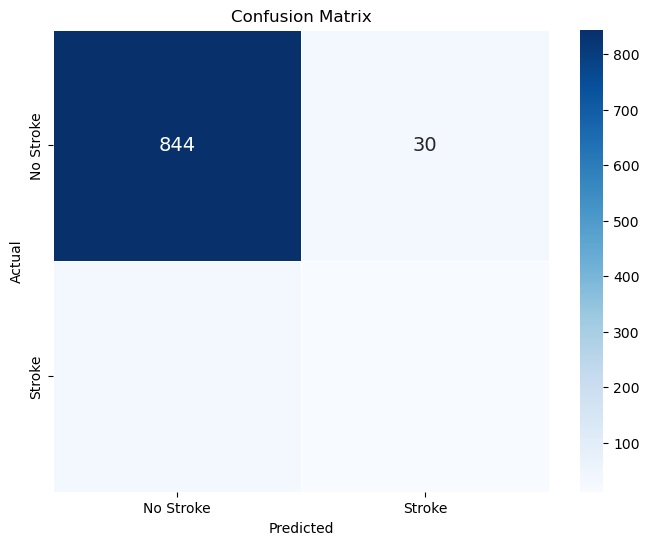

[I 2023-11-30 12:57:18,512] Trial 16 finished with value: 0.9314472079277039 and parameters: {'units_layer': 80, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.0192528749166072, 'num_epochs': 8}. Best is trial 15 with value: 0.9401523470878601.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


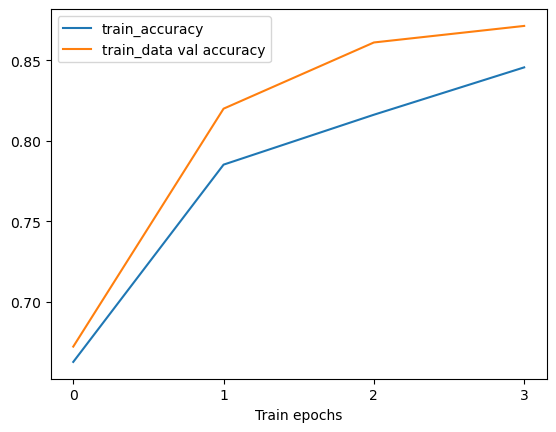

29/29 [==============================] - 0s 302us/step


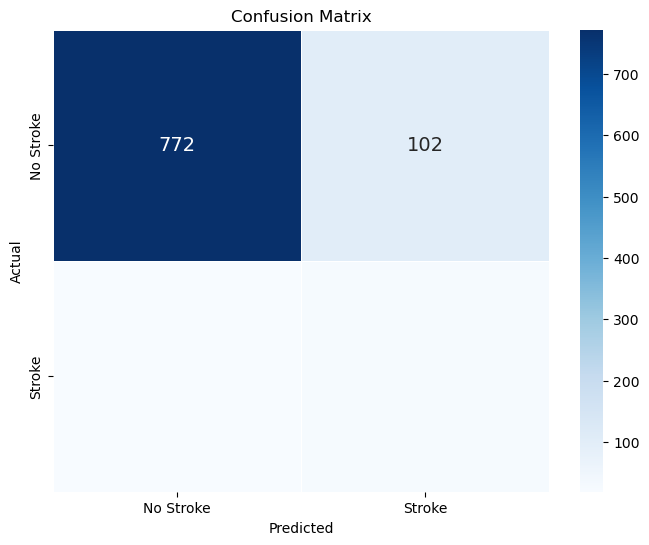

[I 2023-11-30 12:57:19,311] Trial 17 finished with value: 0.8683351278305054 and parameters: {'units_layer': 47, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.017798900432537037, 'num_epochs': 4}. Best is trial 15 with value: 0.9401523470878601.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


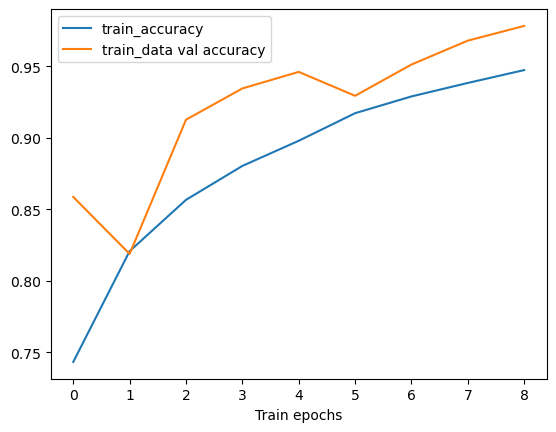

29/29 [==============================] - 0s 313us/step


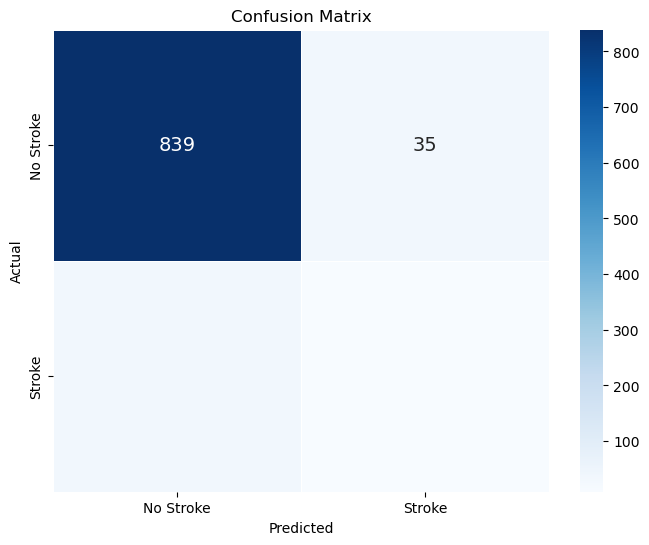

[I 2023-11-30 12:57:20,413] Trial 18 finished with value: 0.9227421283721924 and parameters: {'units_layer': 103, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.023667422566273612, 'num_epochs': 9}. Best is trial 15 with value: 0.9401523470878601.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


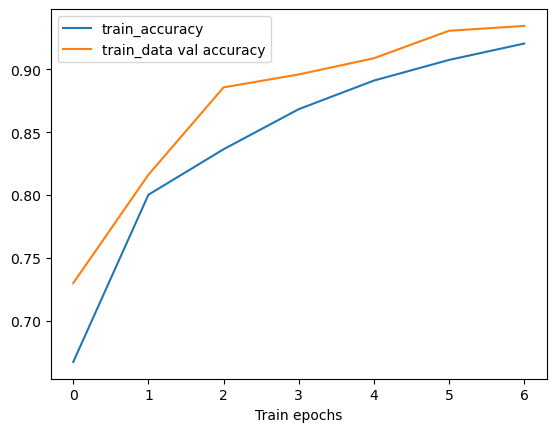

29/29 [==============================] - 0s 302us/step


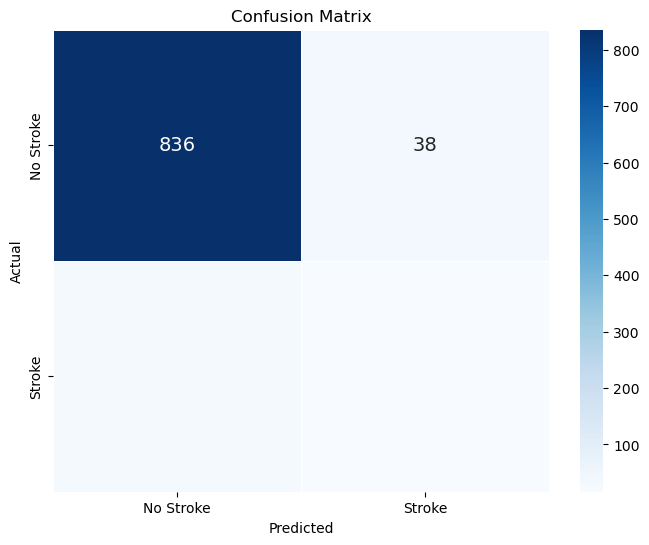

[I 2023-11-30 12:57:21,571] Trial 19 finished with value: 0.9270946383476257 and parameters: {'units_layer': 72, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.010791065025326322, 'num_epochs': 7}. Best is trial 15 with value: 0.9401523470878601.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


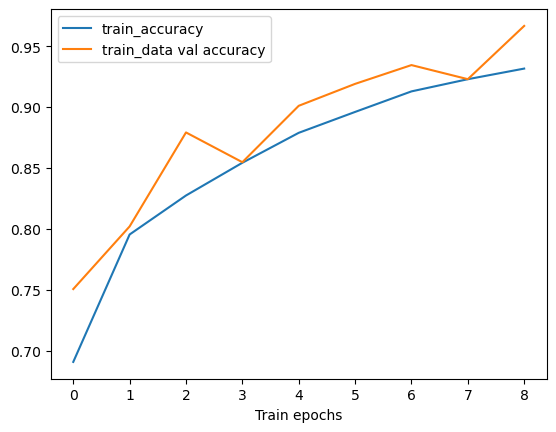

29/29 [==============================] - 0s 303us/step


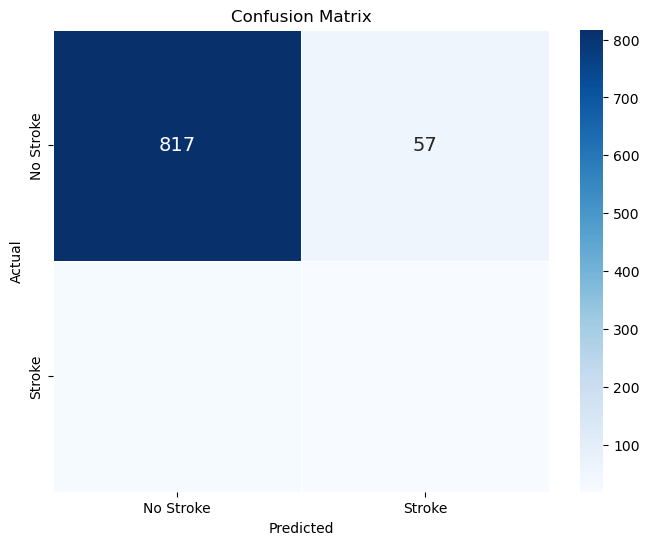

[I 2023-11-30 12:57:22,643] Trial 20 finished with value: 0.909684419631958 and parameters: {'units_layer': 52, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.014813080951088659, 'num_epochs': 9}. Best is trial 15 with value: 0.9401523470878601.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


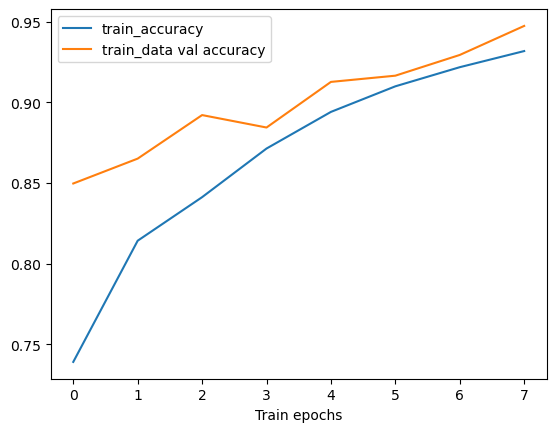

29/29 [==============================] - 0s 312us/step


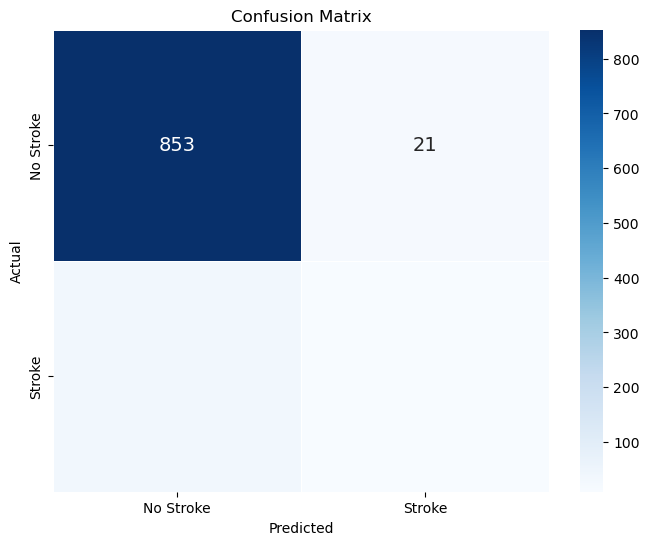

[I 2023-11-30 12:57:23,667] Trial 21 finished with value: 0.937976062297821 and parameters: {'units_layer': 78, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.01872540841096251, 'num_epochs': 8}. Best is trial 15 with value: 0.9401523470878601.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


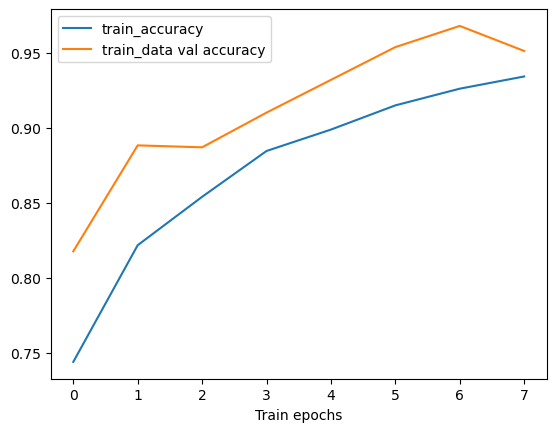

29/29 [==============================] - 0s 306us/step


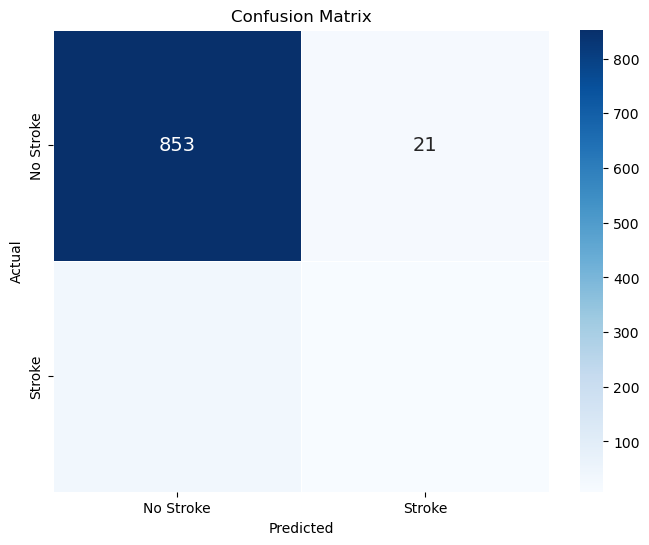

[I 2023-11-30 12:57:24,699] Trial 22 finished with value: 0.9368879199028015 and parameters: {'units_layer': 82, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.018556580032488137, 'num_epochs': 8}. Best is trial 15 with value: 0.9401523470878601.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


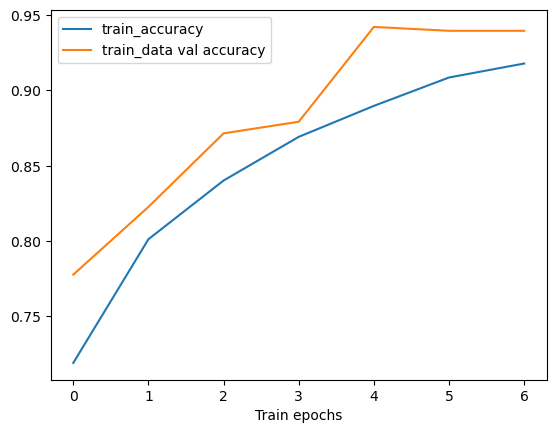

29/29 [==============================] - 0s 306us/step


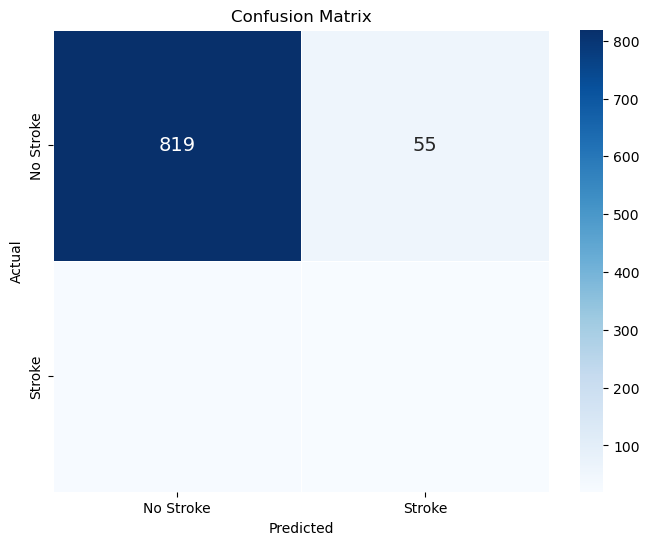

[I 2023-11-30 12:57:25,671] Trial 23 finished with value: 0.9129488468170166 and parameters: {'units_layer': 75, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.022225572772949558, 'num_epochs': 7}. Best is trial 15 with value: 0.9401523470878601.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


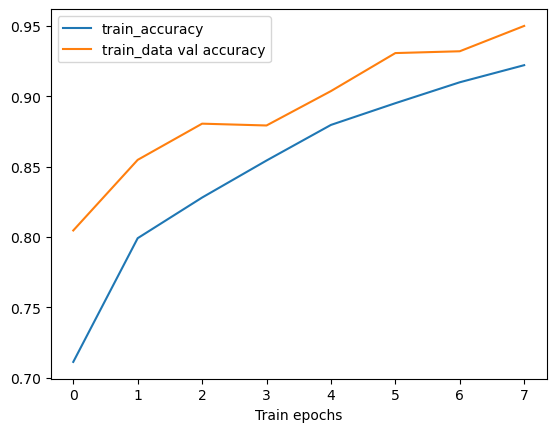

29/29 [==============================] - 0s 317us/step


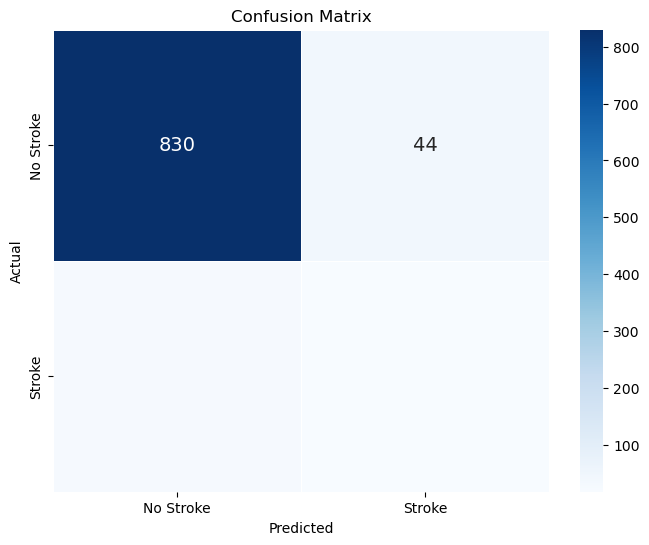

[I 2023-11-30 12:57:26,724] Trial 24 finished with value: 0.9216539859771729 and parameters: {'units_layer': 55, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.01568641030314273, 'num_epochs': 8}. Best is trial 15 with value: 0.9401523470878601.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


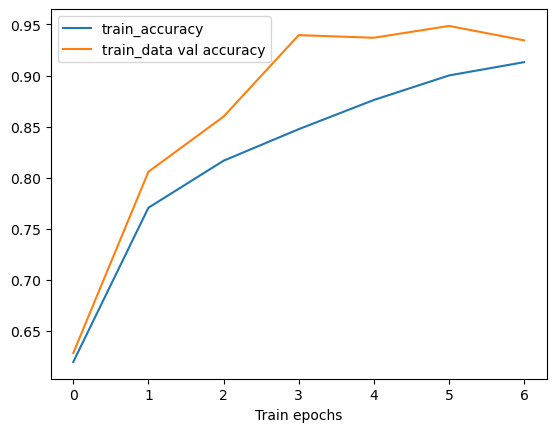

29/29 [==============================] - 0s 302us/step


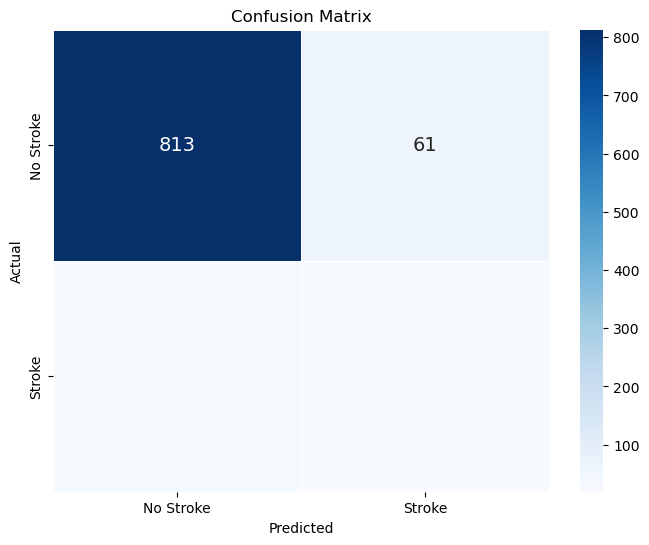

[I 2023-11-30 12:57:27,691] Trial 25 finished with value: 0.9053319096565247 and parameters: {'units_layer': 38, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.013610617473511371, 'num_epochs': 7}. Best is trial 15 with value: 0.9401523470878601.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


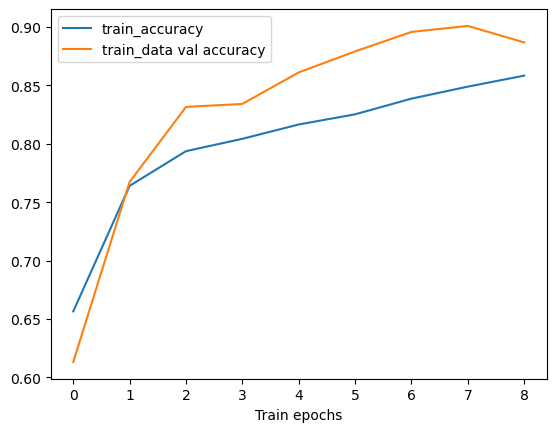

29/29 [==============================] - 0s 314us/step


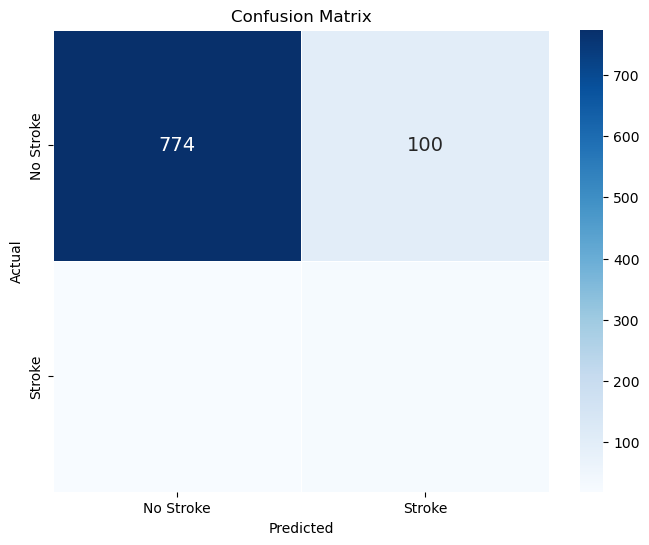

[I 2023-11-30 12:57:28,719] Trial 26 finished with value: 0.8705114126205444 and parameters: {'units_layer': 97, 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.029761059381729217, 'num_epochs': 9}. Best is trial 15 with value: 0.9401523470878601.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


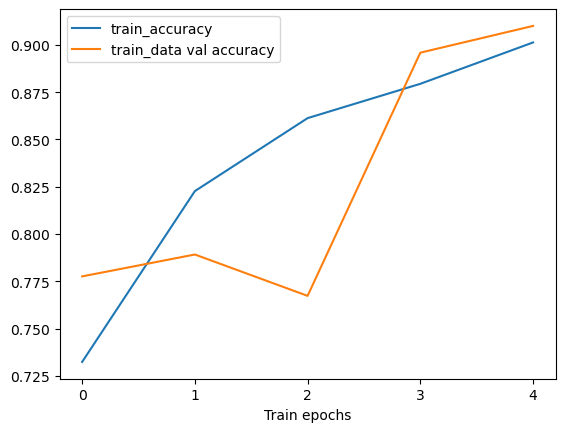

29/29 [==============================] - 0s 322us/step


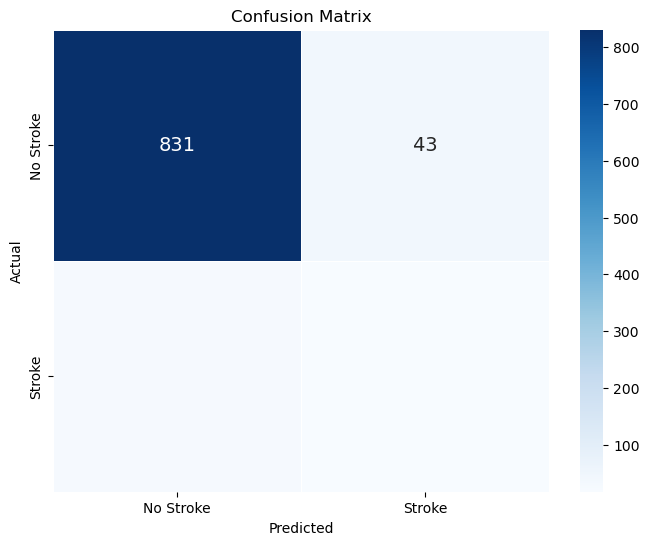

[I 2023-11-30 12:57:29,600] Trial 27 finished with value: 0.9227421283721924 and parameters: {'units_layer': 107, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.020618999833504608, 'num_epochs': 5}. Best is trial 15 with value: 0.9401523470878601.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


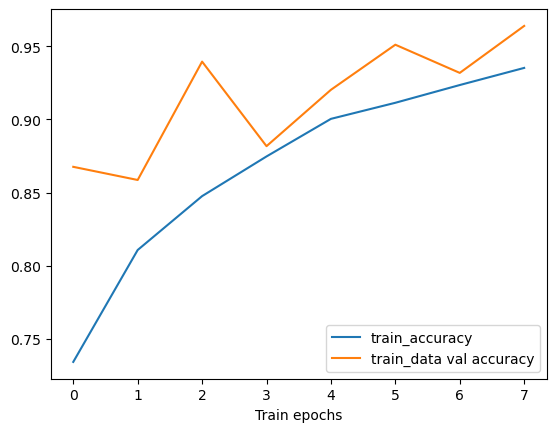

29/29 [==============================] - 0s 316us/step


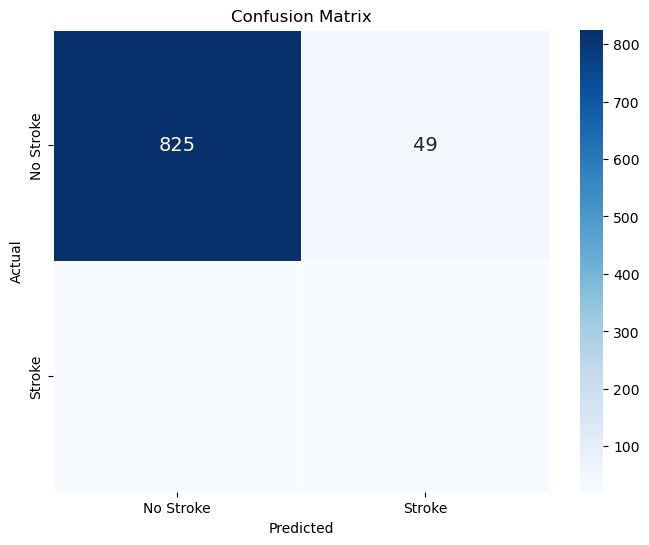

[I 2023-11-30 12:57:30,637] Trial 28 finished with value: 0.9205658435821533 and parameters: {'units_layer': 88, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.016347428886931876, 'num_epochs': 8}. Best is trial 15 with value: 0.9401523470878601.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


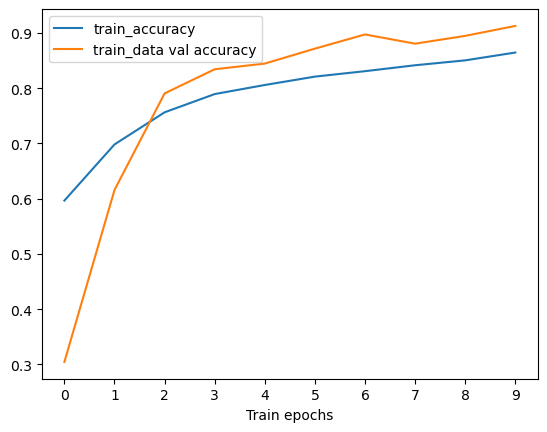

29/29 [==============================] - 0s 308us/step


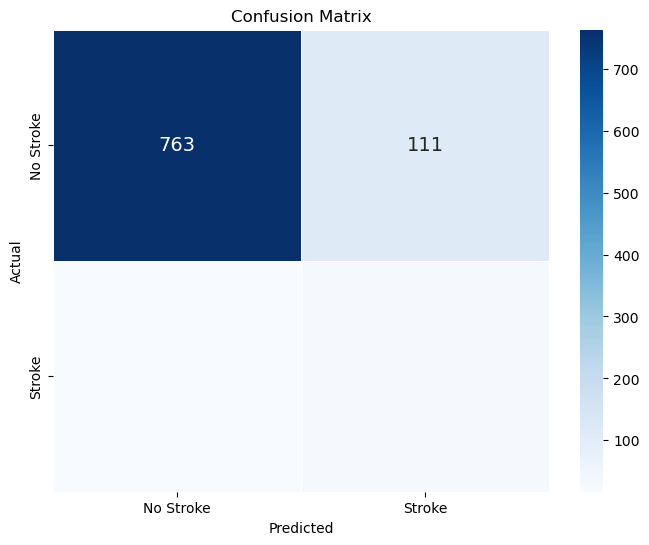

[I 2023-11-30 12:57:31,706] Trial 29 finished with value: 0.8607181906700134 and parameters: {'units_layer': 61, 'activation': 'relu', 'optimizer': 'SGD', 'learning_rate': 0.026251639151793363, 'num_epochs': 10}. Best is trial 15 with value: 0.9401523470878601.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


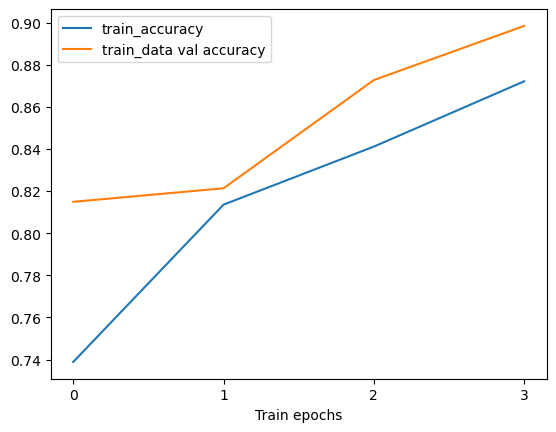

29/29 [==============================] - 0s 307us/step


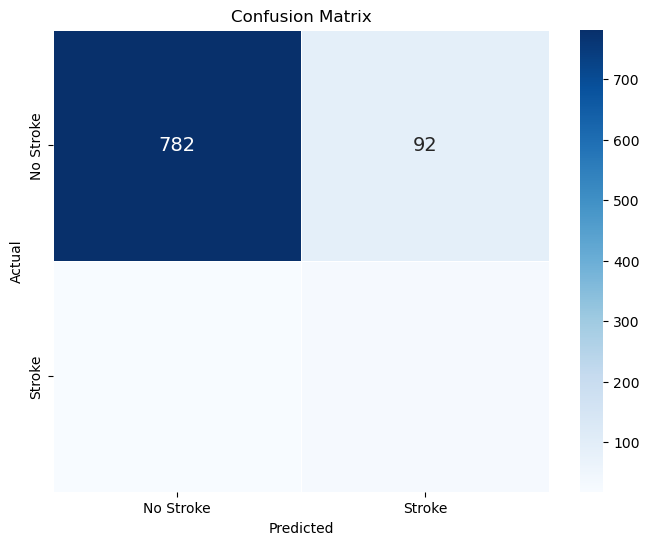

[I 2023-11-30 12:57:32,518] Trial 30 finished with value: 0.8803046941757202 and parameters: {'units_layer': 77, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.0349208044489417, 'num_epochs': 4}. Best is trial 15 with value: 0.9401523470878601.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


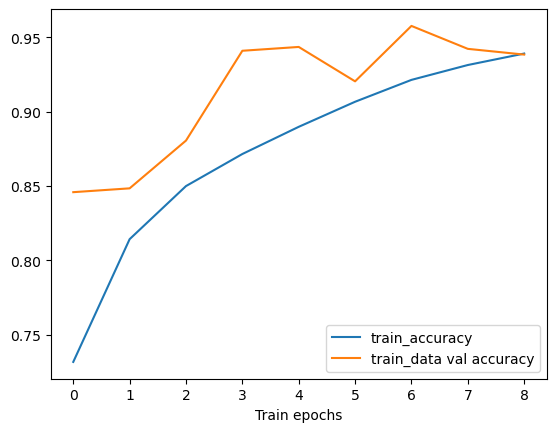

29/29 [==============================] - 0s 306us/step


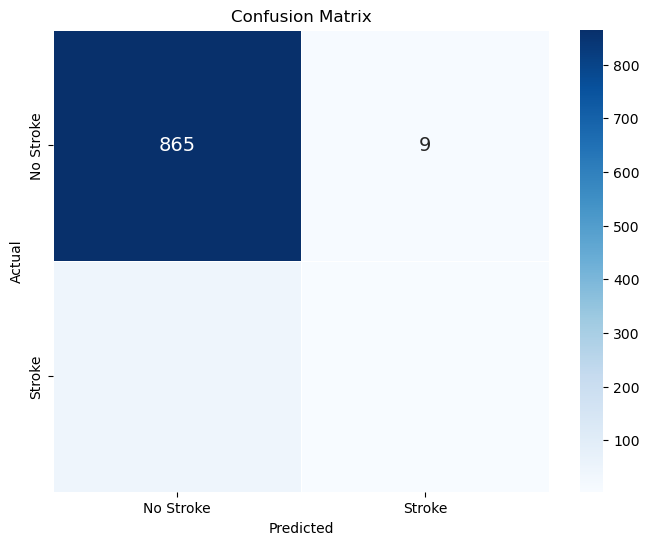

[I 2023-11-30 12:57:33,800] Trial 31 finished with value: 0.9455930590629578 and parameters: {'units_layer': 84, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.019154807186818695, 'num_epochs': 9}. Best is trial 31 with value: 0.9455930590629578.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


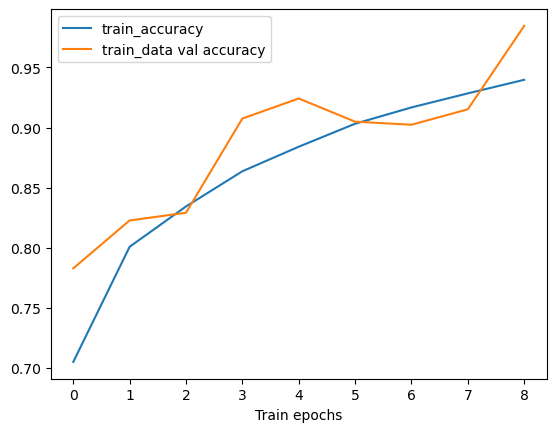

29/29 [==============================] - 0s 308us/step


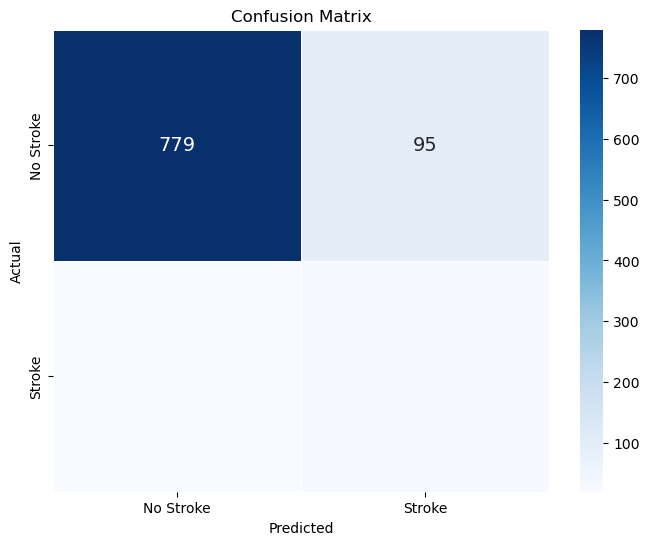

[I 2023-11-30 12:57:34,886] Trial 32 finished with value: 0.8748639822006226 and parameters: {'units_layer': 67, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.020895531145424938, 'num_epochs': 9}. Best is trial 31 with value: 0.9455930590629578.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


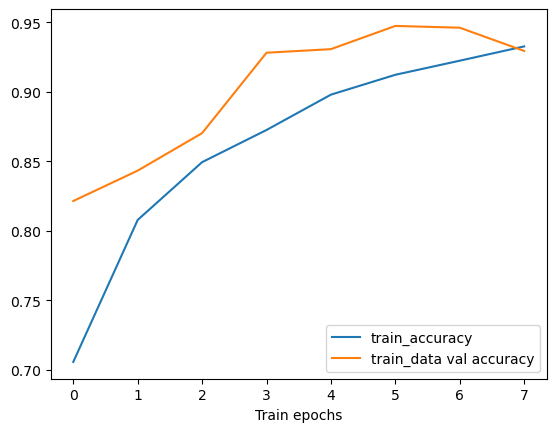

29/29 [==============================] - 0s 301us/step


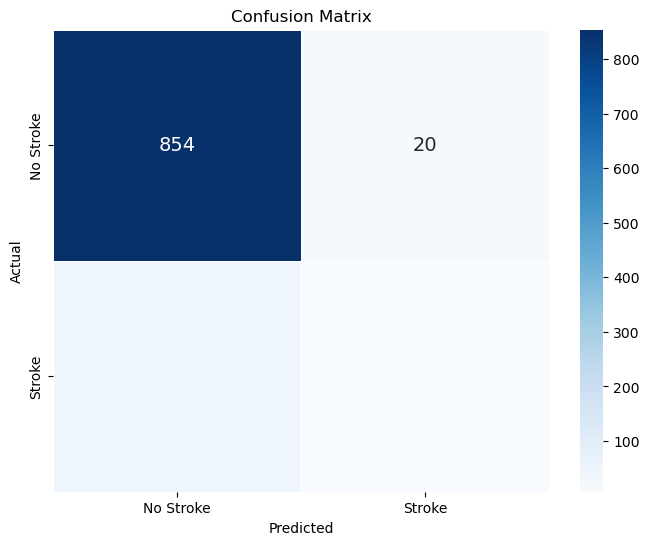

[I 2023-11-30 12:57:35,919] Trial 33 finished with value: 0.9368879199028015 and parameters: {'units_layer': 83, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.023904095208729464, 'num_epochs': 8}. Best is trial 31 with value: 0.9455930590629578.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


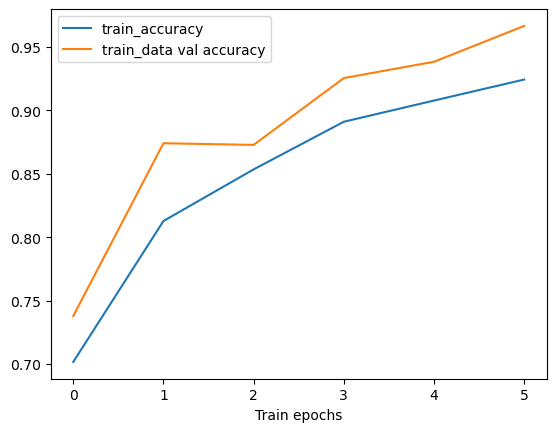

29/29 [==============================] - 0s 313us/step


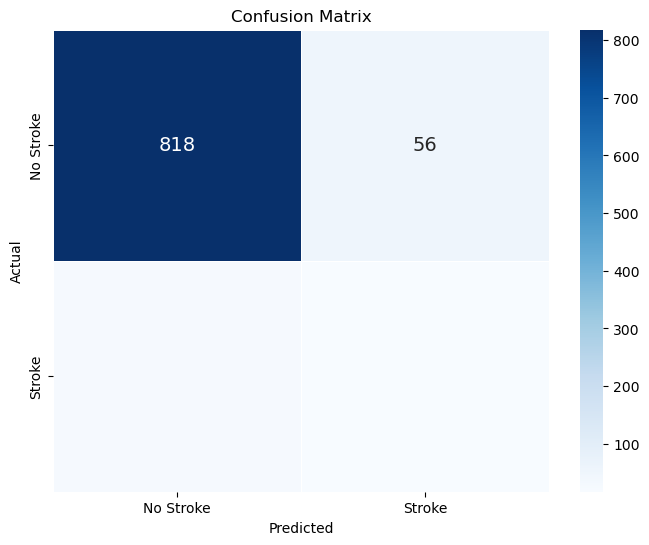

[I 2023-11-30 12:57:36,831] Trial 34 finished with value: 0.9085962772369385 and parameters: {'units_layer': 60, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.012428737769621284, 'num_epochs': 6}. Best is trial 31 with value: 0.9455930590629578.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


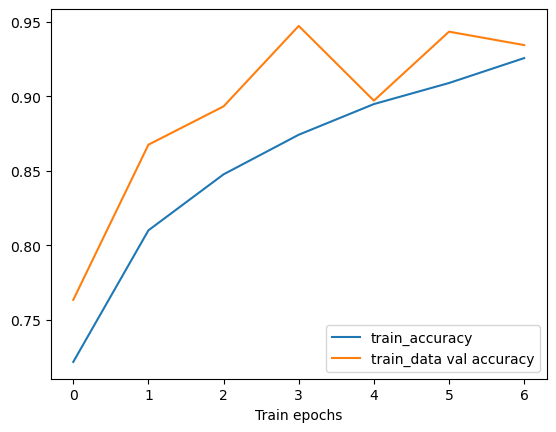

29/29 [==============================] - 0s 312us/step


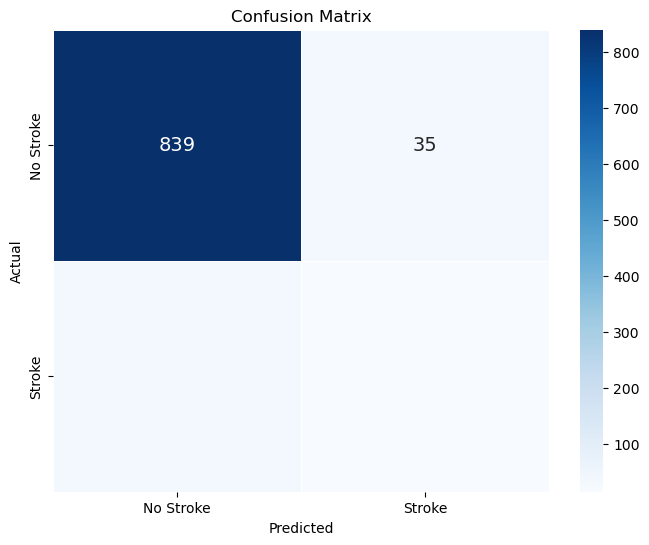

[I 2023-11-30 12:57:37,817] Trial 35 finished with value: 0.9281827807426453 and parameters: {'units_layer': 91, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.016680684267782787, 'num_epochs': 7}. Best is trial 31 with value: 0.9455930590629578.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


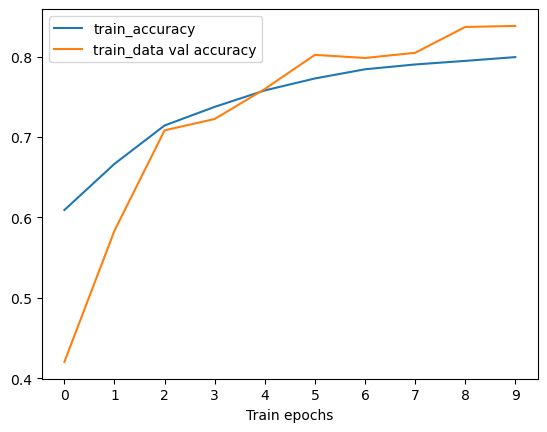

29/29 [==============================] - 0s 304us/step


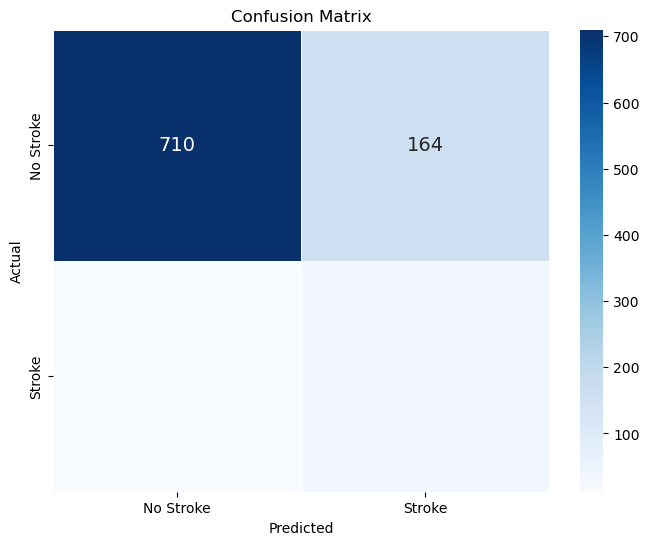

[I 2023-11-30 12:57:38,881] Trial 36 finished with value: 0.8084874749183655 and parameters: {'units_layer': 72, 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.01263758517596291, 'num_epochs': 10}. Best is trial 31 with value: 0.9455930590629578.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


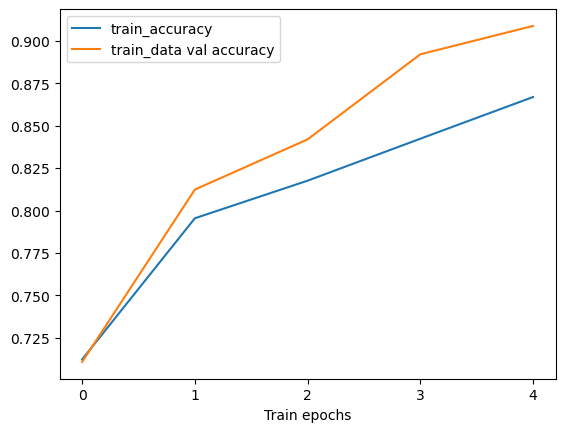

29/29 [==============================] - 0s 304us/step


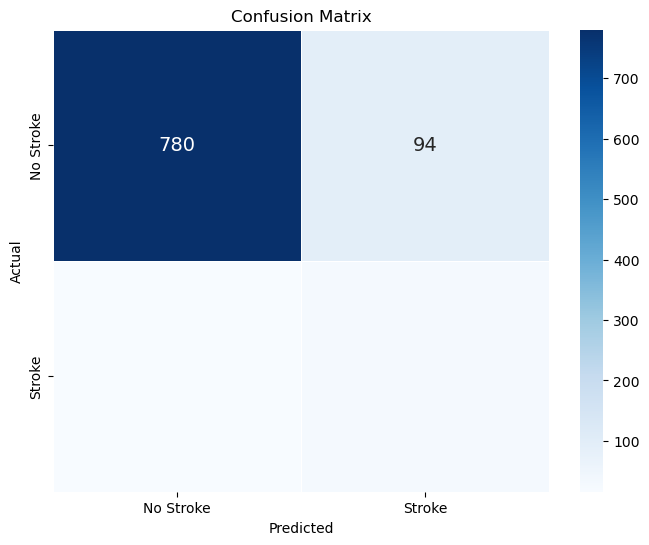

[I 2023-11-30 12:57:39,736] Trial 37 finished with value: 0.8803046941757202 and parameters: {'units_layer': 25, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.01851635221083904, 'num_epochs': 5}. Best is trial 31 with value: 0.9455930590629578.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


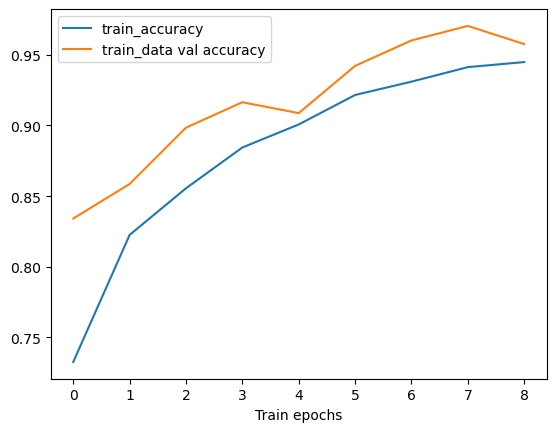

29/29 [==============================] - 0s 300us/step


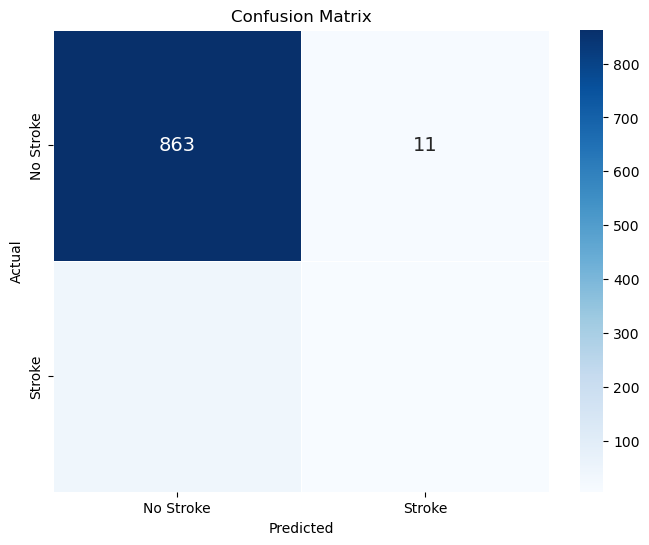

[I 2023-11-30 12:57:40,860] Trial 38 finished with value: 0.9445049166679382 and parameters: {'units_layer': 105, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.010147306328432549, 'num_epochs': 9}. Best is trial 31 with value: 0.9455930590629578.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


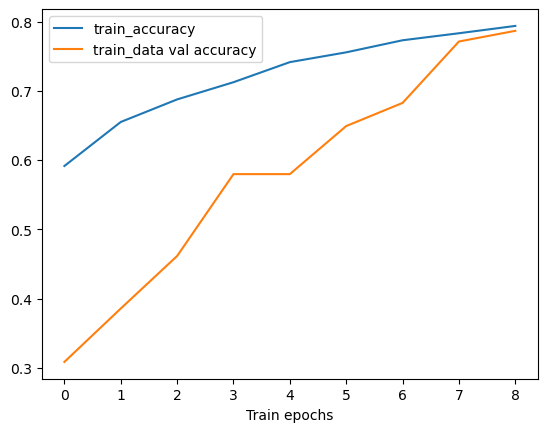

29/29 [==============================] - 0s 299us/step


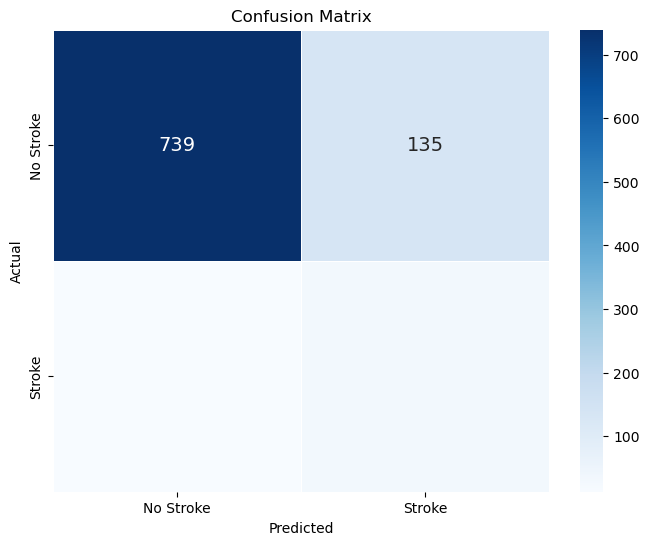

[I 2023-11-30 12:57:41,886] Trial 39 finished with value: 0.8389554023742676 and parameters: {'units_layer': 106, 'activation': 'relu', 'optimizer': 'SGD', 'learning_rate': 0.010460190889006536, 'num_epochs': 9}. Best is trial 31 with value: 0.9455930590629578.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


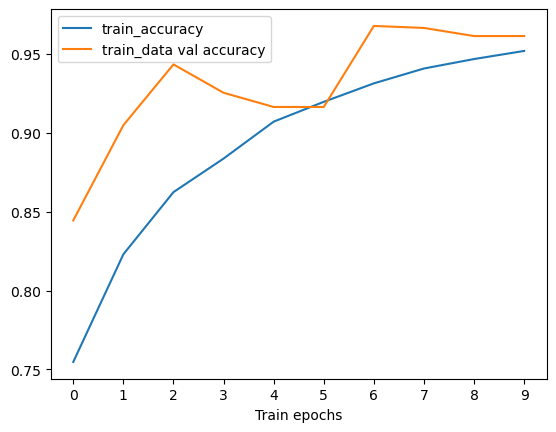

29/29 [==============================] - 0s 314us/step


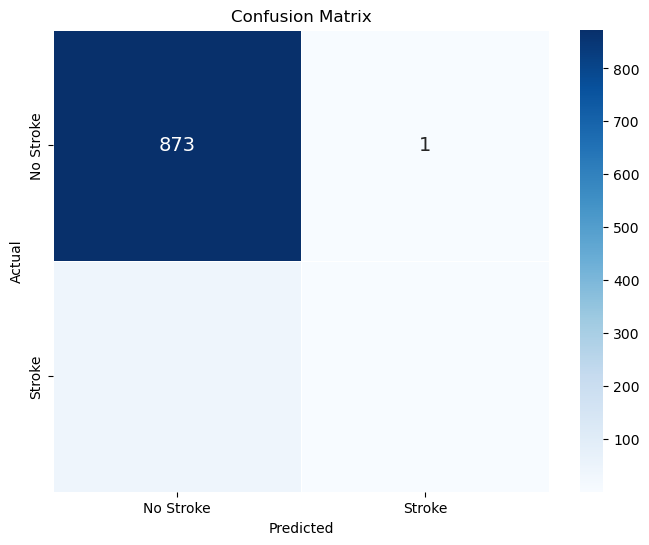

[I 2023-11-30 12:57:43,057] Trial 40 finished with value: 0.9532099962234497 and parameters: {'units_layer': 115, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.013250663299162593, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


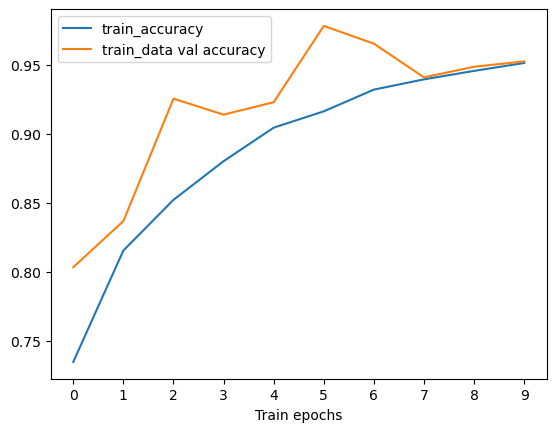

29/29 [==============================] - 0s 316us/step


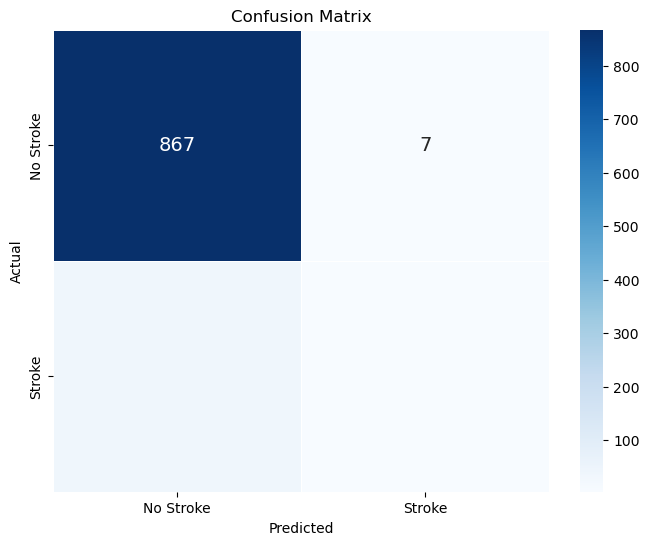

[I 2023-11-30 12:57:44,222] Trial 41 finished with value: 0.9477693438529968 and parameters: {'units_layer': 100, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.011701861240190936, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


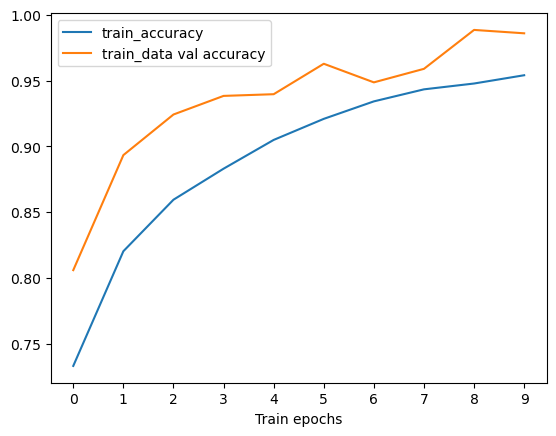

29/29 [==============================] - 0s 320us/step


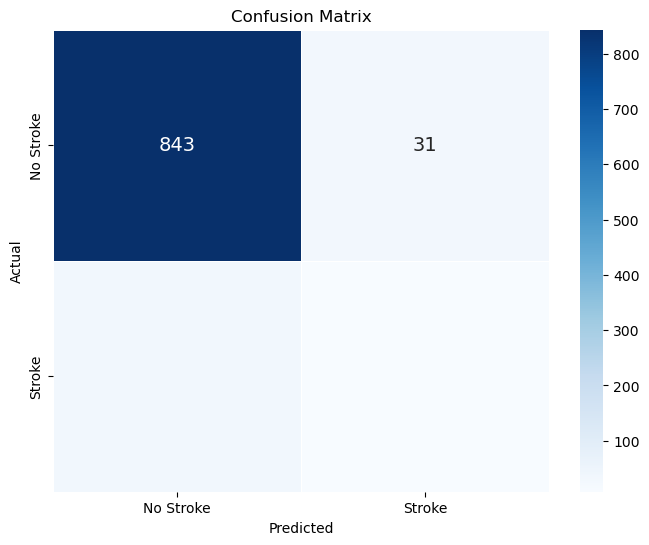

[I 2023-11-30 12:57:45,589] Trial 42 finished with value: 0.926006555557251 and parameters: {'units_layer': 116, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.011972413085250794, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


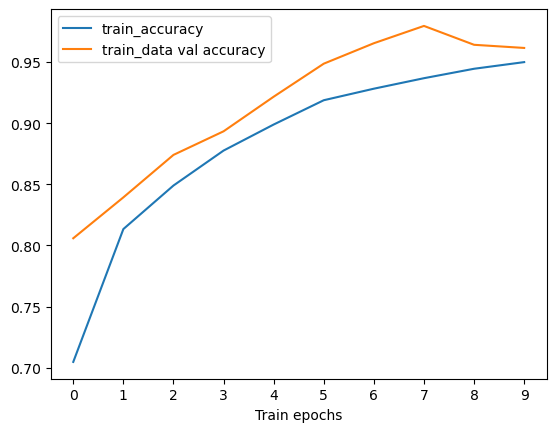

29/29 [==============================] - 0s 314us/step


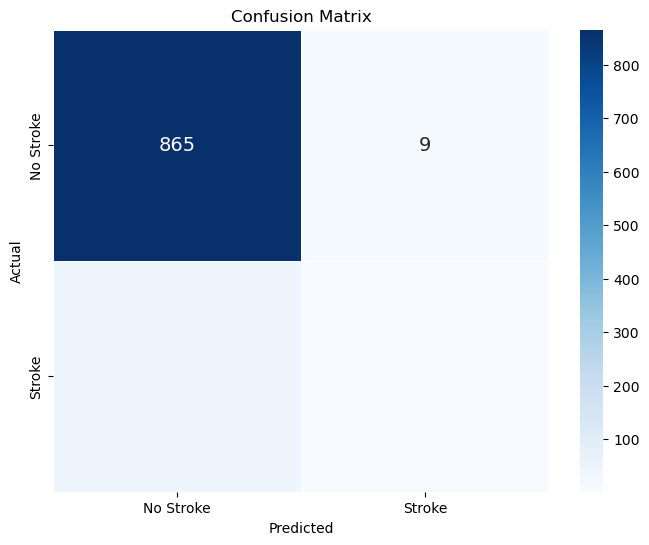

[I 2023-11-30 12:57:46,747] Trial 43 finished with value: 0.9434167742729187 and parameters: {'units_layer': 103, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.010291982626368313, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


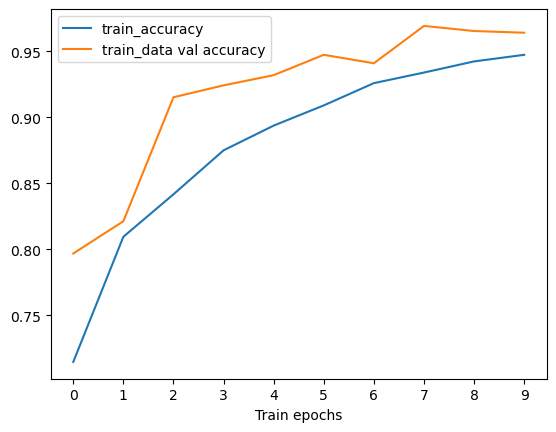

29/29 [==============================] - 0s 311us/step


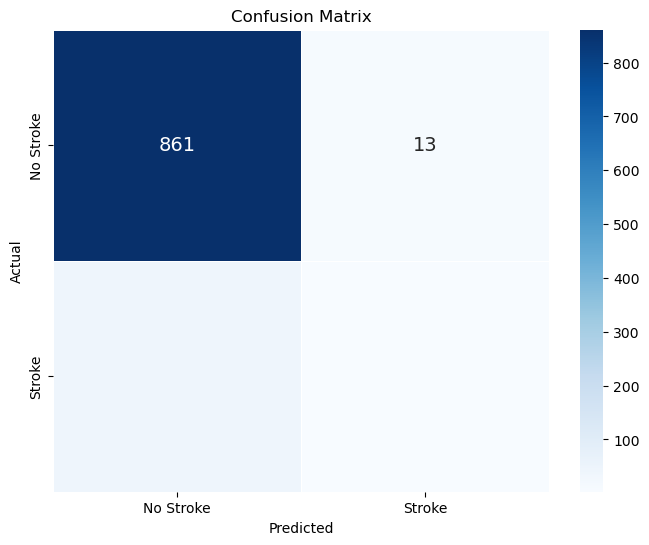

[I 2023-11-30 12:57:47,907] Trial 44 finished with value: 0.9401523470878601 and parameters: {'units_layer': 104, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.010103838550603178, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


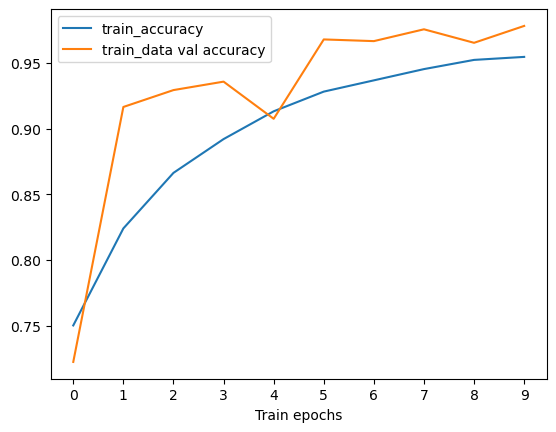

29/29 [==============================] - 0s 328us/step


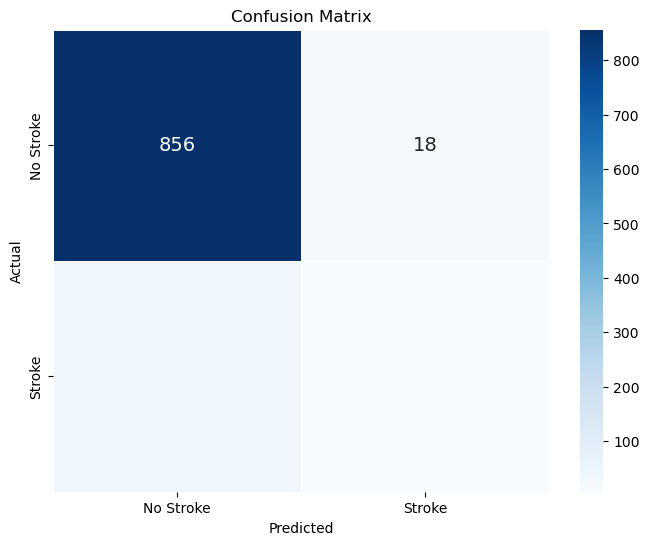

[I 2023-11-30 12:57:49,076] Trial 45 finished with value: 0.9390642046928406 and parameters: {'units_layer': 126, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.011604725536056607, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


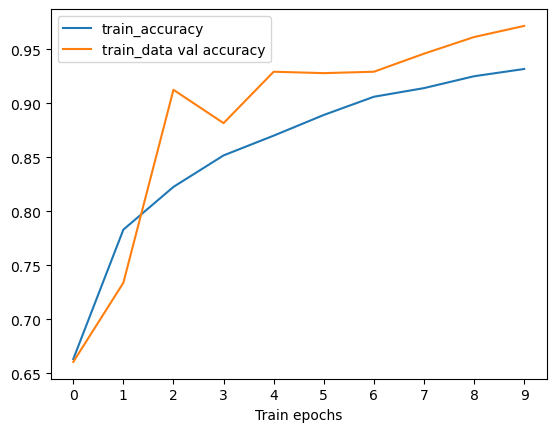

29/29 [==============================] - 0s 315us/step


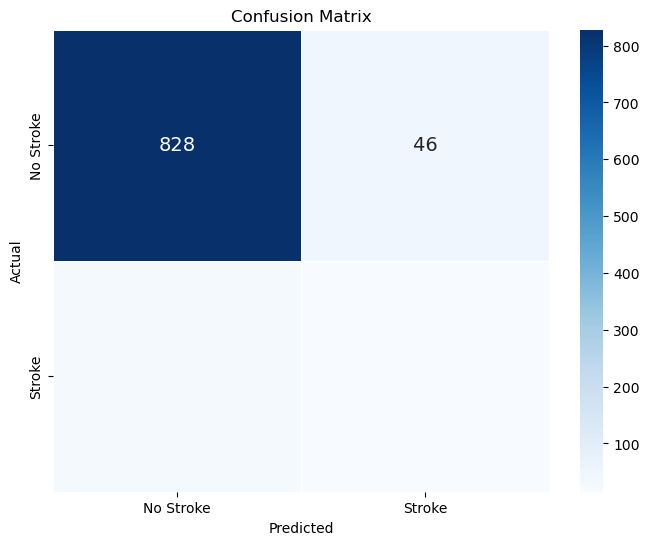

[I 2023-11-30 12:57:50,250] Trial 46 finished with value: 0.9173014163970947 and parameters: {'units_layer': 112, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.01382571657886449, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


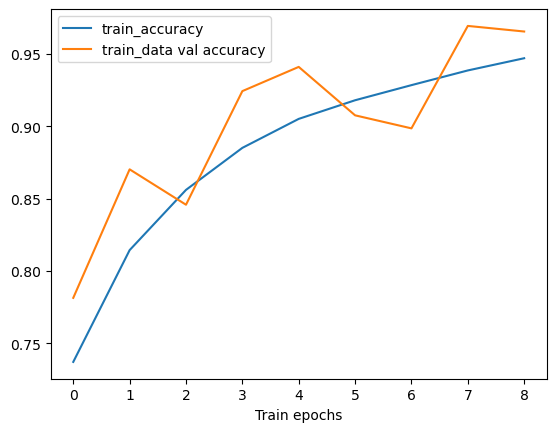

29/29 [==============================] - 0s 305us/step


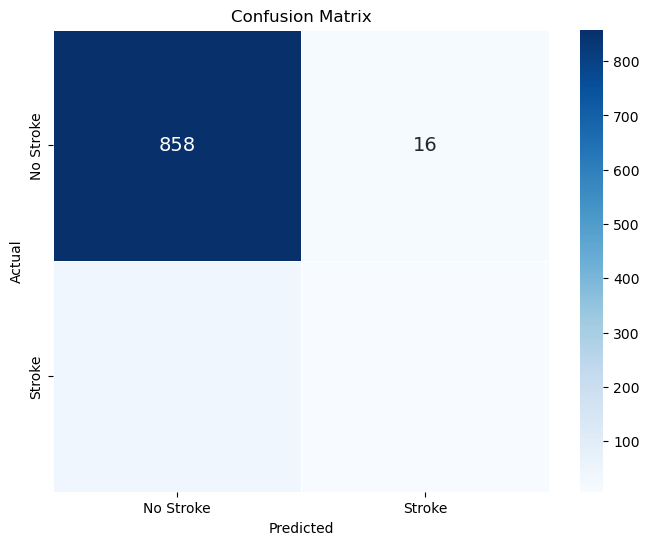

[I 2023-11-30 12:57:51,360] Trial 47 finished with value: 0.9412404894828796 and parameters: {'units_layer': 120, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.011304350297179593, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


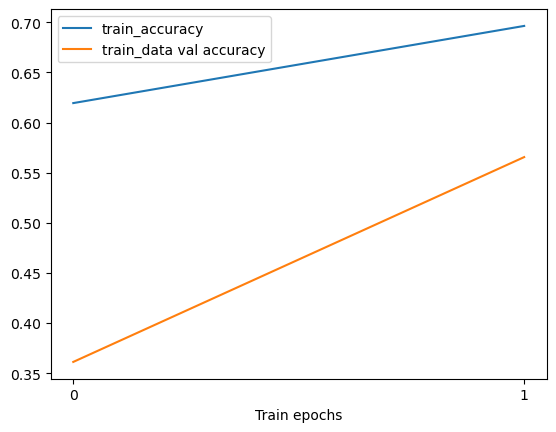

29/29 [==============================] - 0s 313us/step


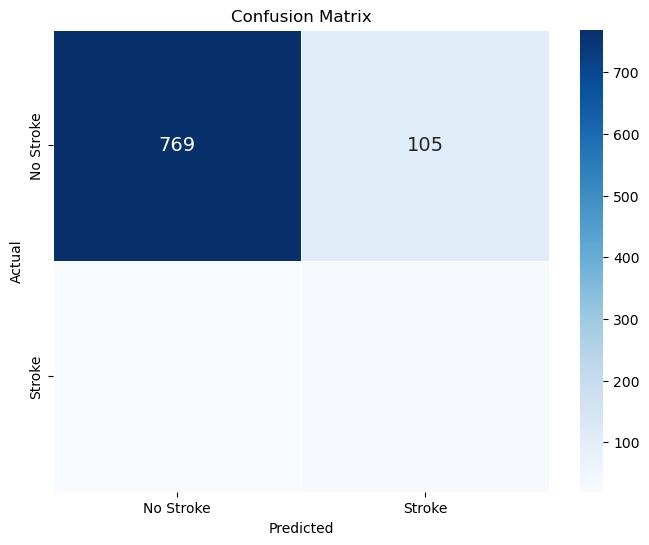

[I 2023-11-30 12:57:51,996] Trial 48 finished with value: 0.863982617855072 and parameters: {'units_layer': 99, 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.010162965865842356, 'num_epochs': 2}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


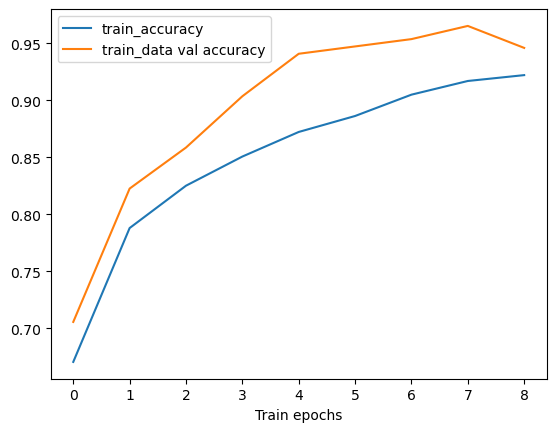

29/29 [==============================] - 0s 315us/step


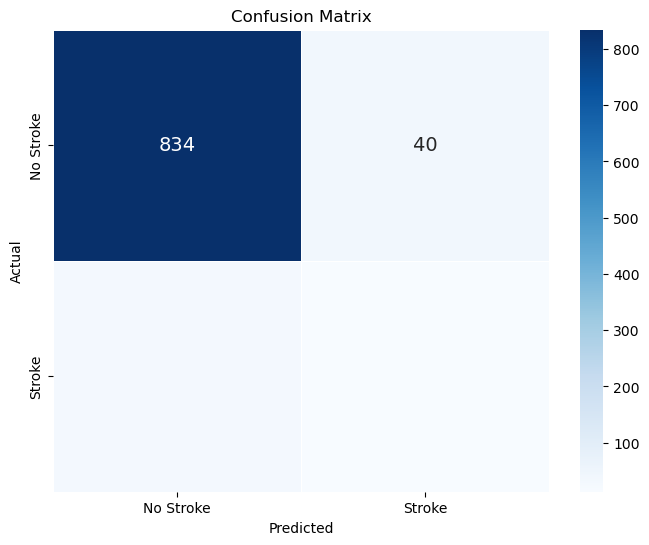

[I 2023-11-30 12:57:53,113] Trial 49 finished with value: 0.9216539859771729 and parameters: {'units_layer': 108, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.013215959145453926, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


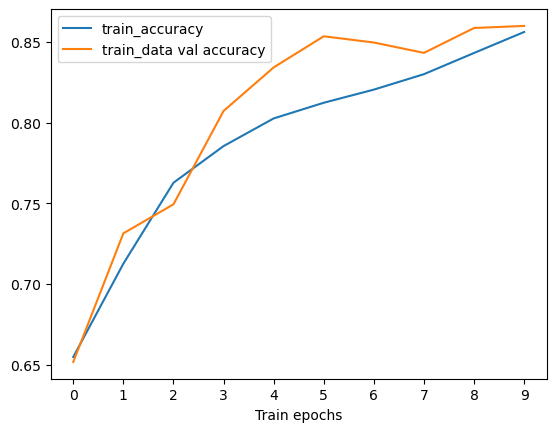

29/29 [==============================] - 0s 303us/step


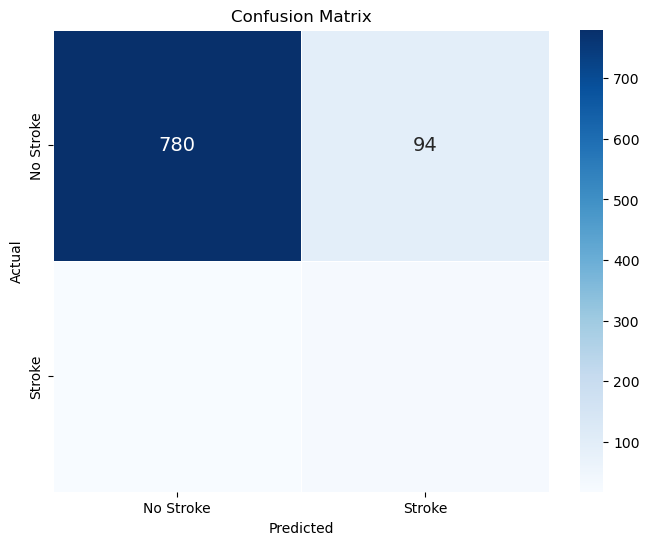

[I 2023-11-30 12:57:54,219] Trial 50 finished with value: 0.8781284093856812 and parameters: {'units_layer': 3, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.011335998351897204, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


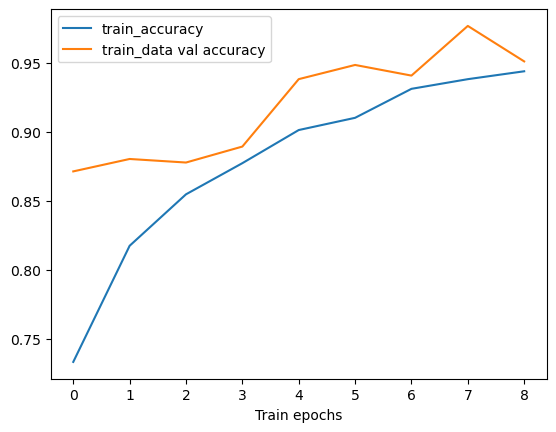

29/29 [==============================] - 0s 323us/step


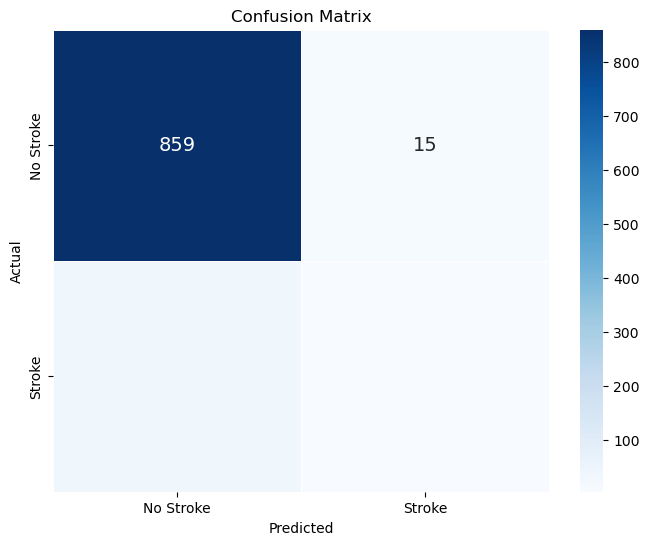

[I 2023-11-30 12:57:55,332] Trial 51 finished with value: 0.9401523470878601 and parameters: {'units_layer': 120, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.011239534845159825, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


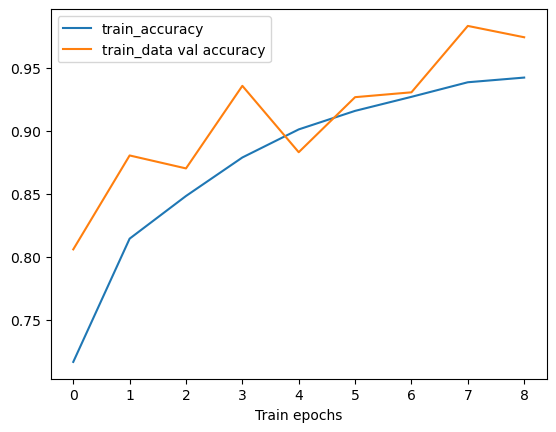

29/29 [==============================] - 0s 311us/step


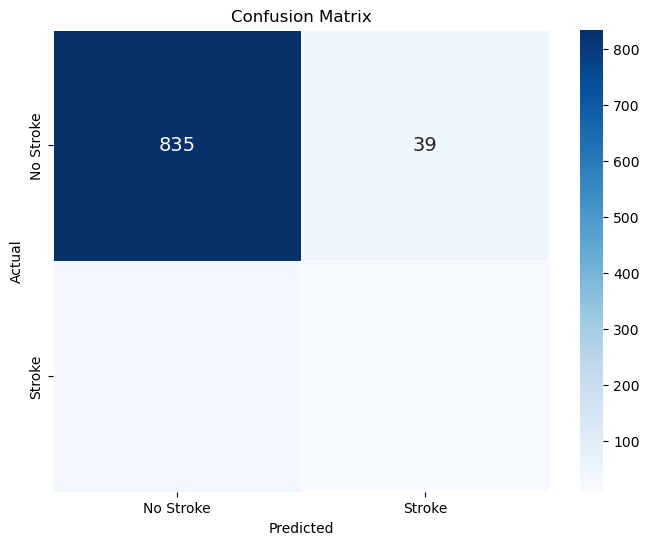

[I 2023-11-30 12:57:56,440] Trial 52 finished with value: 0.9183895587921143 and parameters: {'units_layer': 112, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.012256471680155598, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


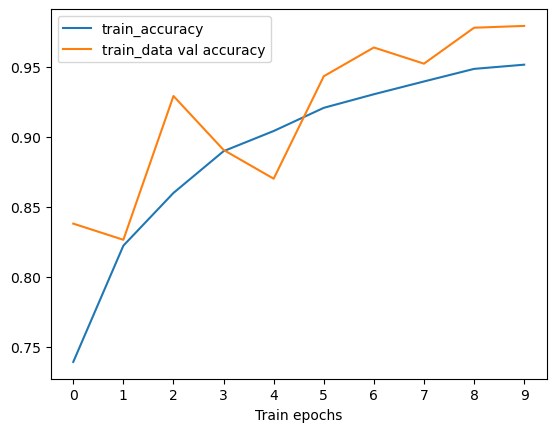

29/29 [==============================] - 0s 307us/step


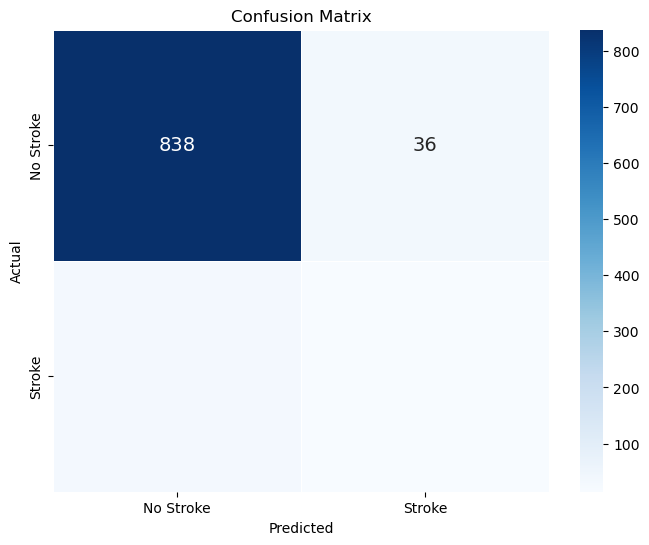

[I 2023-11-30 12:57:57,619] Trial 53 finished with value: 0.9270946383476257 and parameters: {'units_layer': 122, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.014275824278270188, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


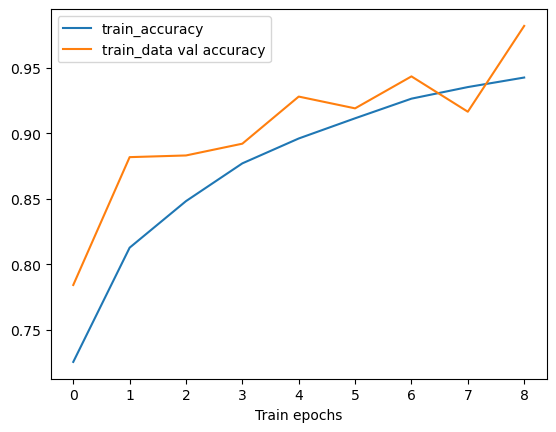

29/29 [==============================] - 0s 307us/step


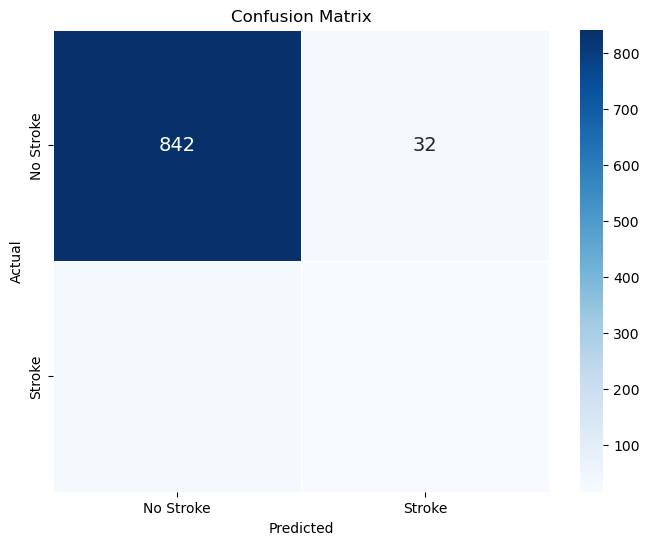

[I 2023-11-30 12:57:58,938] Trial 54 finished with value: 0.9336234927177429 and parameters: {'units_layer': 100, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.015008225315063857, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


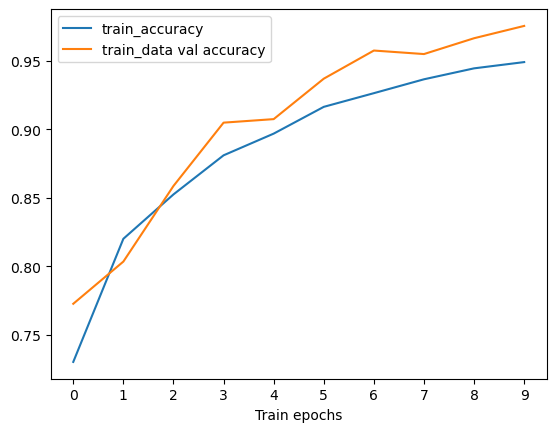

29/29 [==============================] - 0s 317us/step


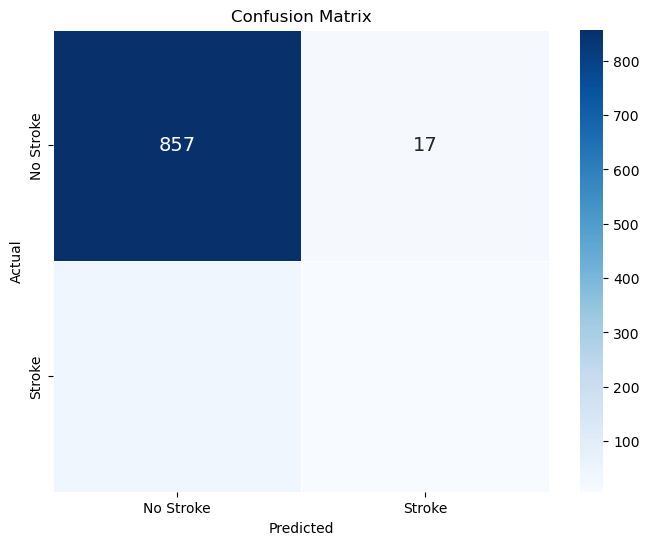

[I 2023-11-30 12:58:00,092] Trial 55 finished with value: 0.9401523470878601 and parameters: {'units_layer': 92, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.010013775266363262, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


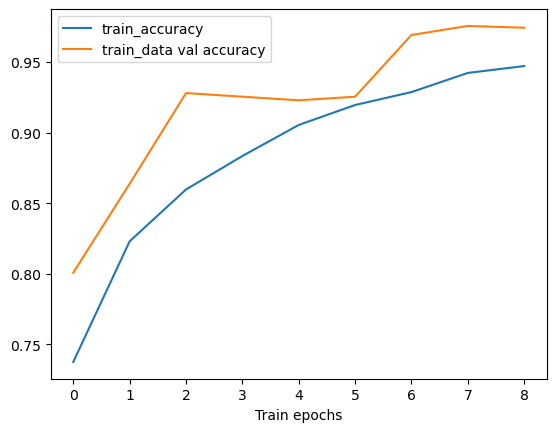

29/29 [==============================] - 0s 309us/step


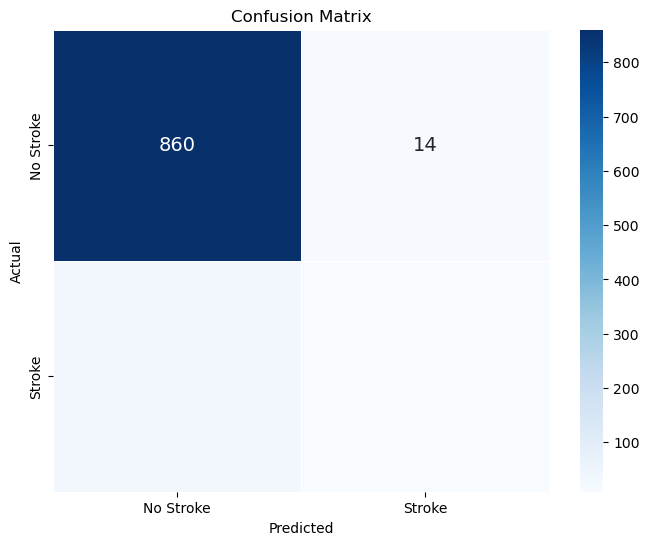

[I 2023-11-30 12:58:01,215] Trial 56 finished with value: 0.9455930590629578 and parameters: {'units_layer': 118, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.011255234175154696, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


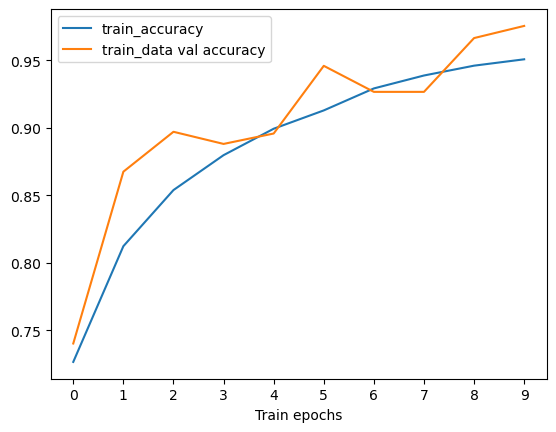

29/29 [==============================] - 0s 311us/step


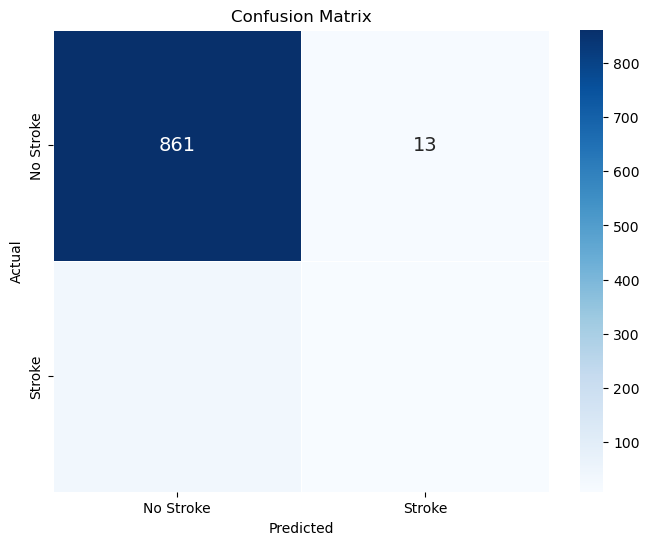

[I 2023-11-30 12:58:02,376] Trial 57 finished with value: 0.9466812014579773 and parameters: {'units_layer': 111, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.0131311880567658, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


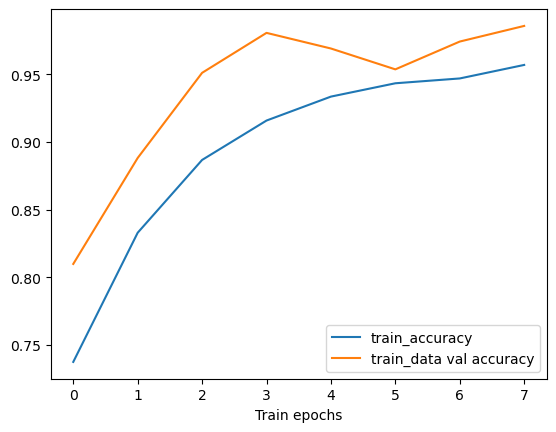

29/29 [==============================] - 0s 309us/step


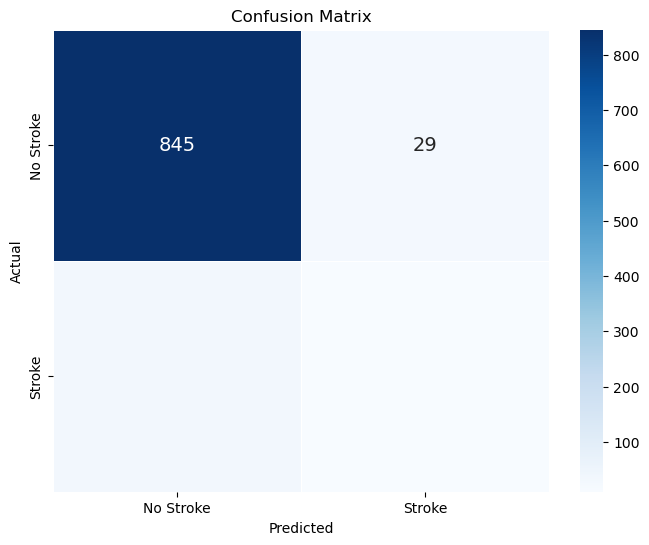

[I 2023-11-30 12:58:03,424] Trial 58 finished with value: 0.9303590655326843 and parameters: {'units_layer': 110, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.013488014111509695, 'num_epochs': 8}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


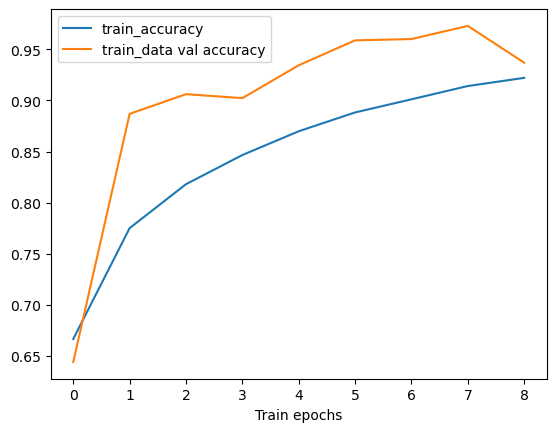

29/29 [==============================] - 0s 318us/step


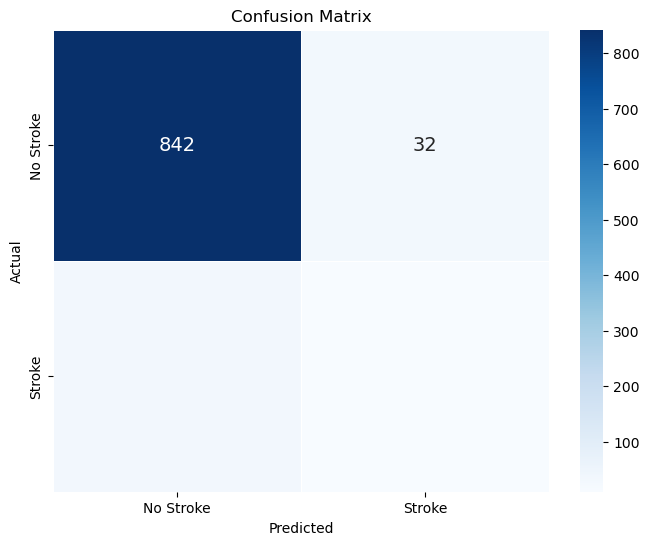

[I 2023-11-30 12:58:04,555] Trial 59 finished with value: 0.9270946383476257 and parameters: {'units_layer': 115, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.015298242286473826, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


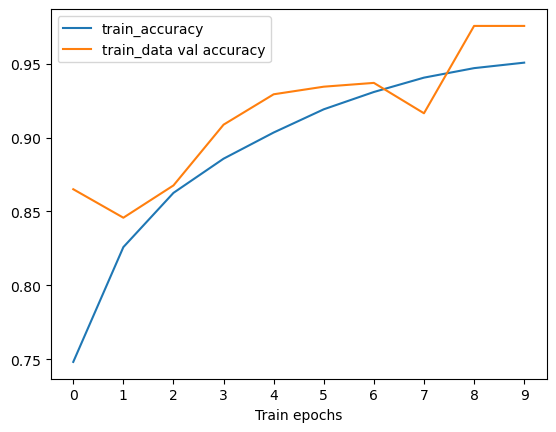

29/29 [==============================] - 0s 316us/step


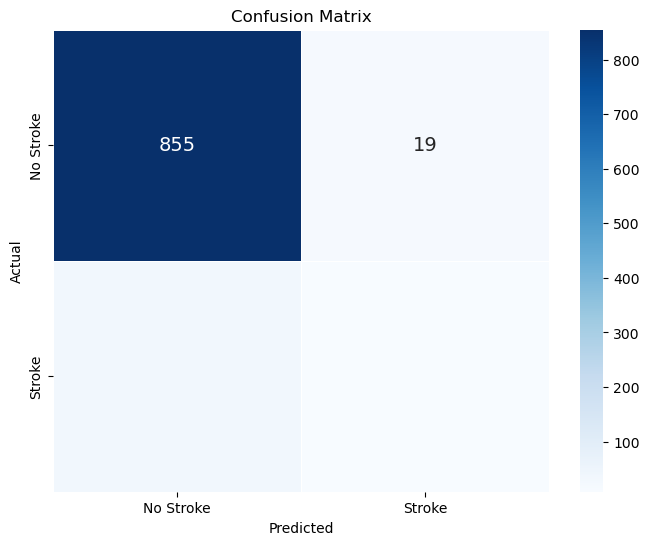

[I 2023-11-30 12:58:05,728] Trial 60 finished with value: 0.9390642046928406 and parameters: {'units_layer': 126, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.012024940073652448, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


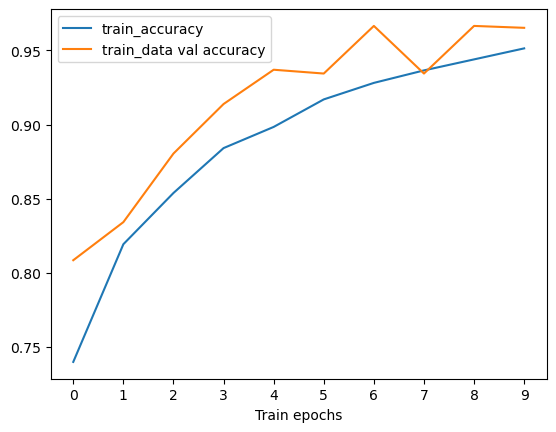

29/29 [==============================] - 0s 315us/step


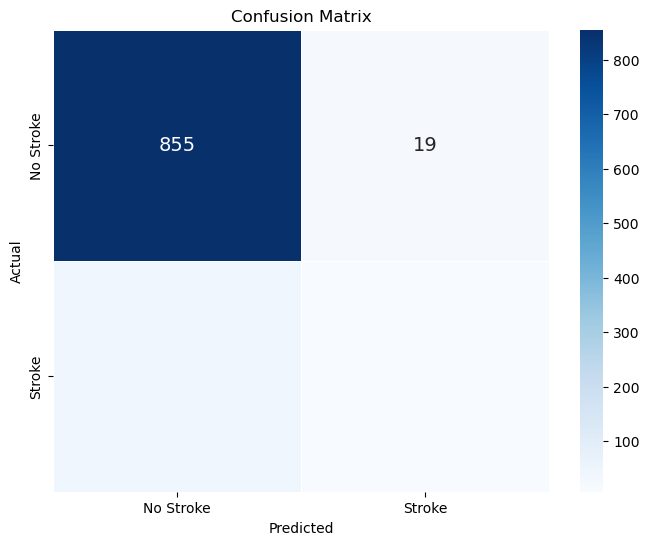

[I 2023-11-30 12:58:06,894] Trial 61 finished with value: 0.937976062297821 and parameters: {'units_layer': 103, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.01080531162560805, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


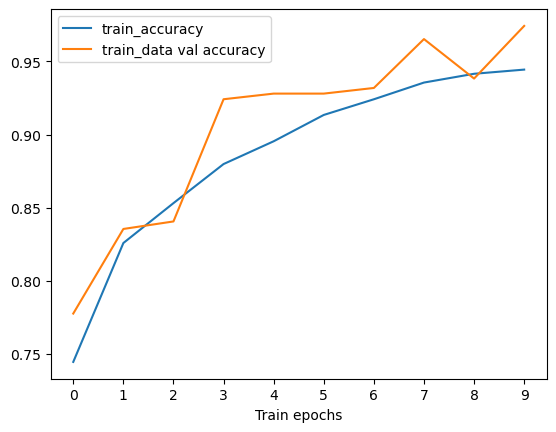

29/29 [==============================] - 0s 324us/step


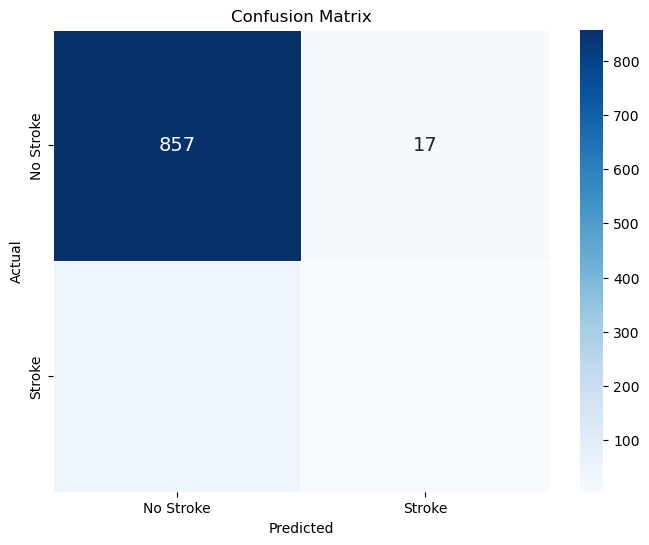

[I 2023-11-30 12:58:08,052] Trial 62 finished with value: 0.937976062297821 and parameters: {'units_layer': 95, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.012522733512749825, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


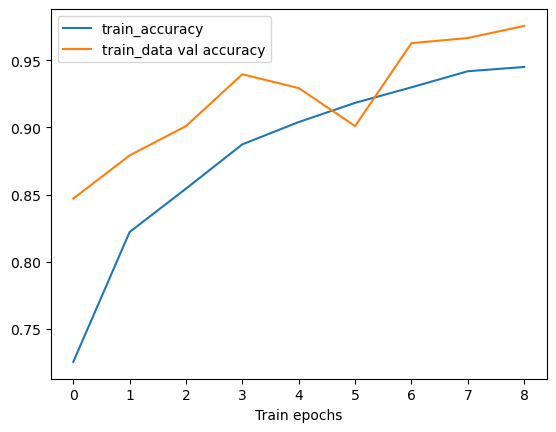

29/29 [==============================] - 0s 311us/step


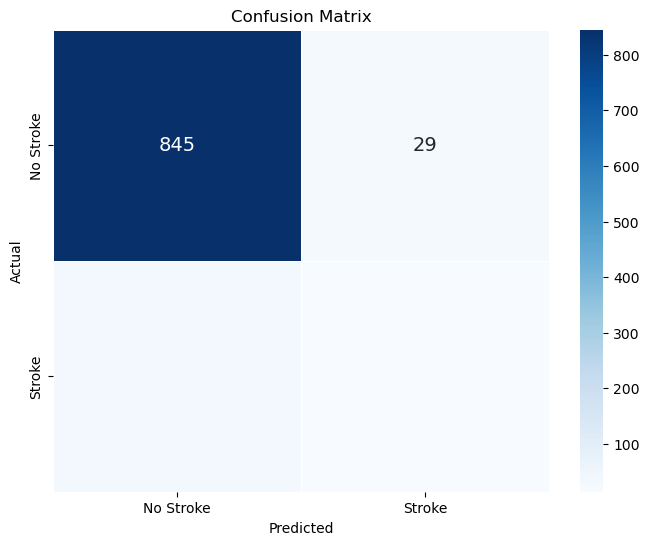

[I 2023-11-30 12:58:09,162] Trial 63 finished with value: 0.9347116351127625 and parameters: {'units_layer': 101, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.010866441703301423, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


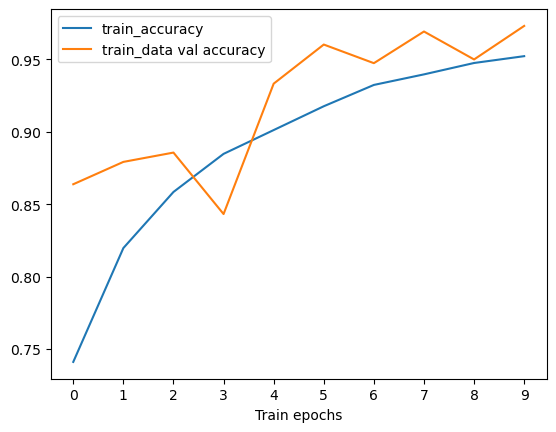

29/29 [==============================] - 0s 308us/step


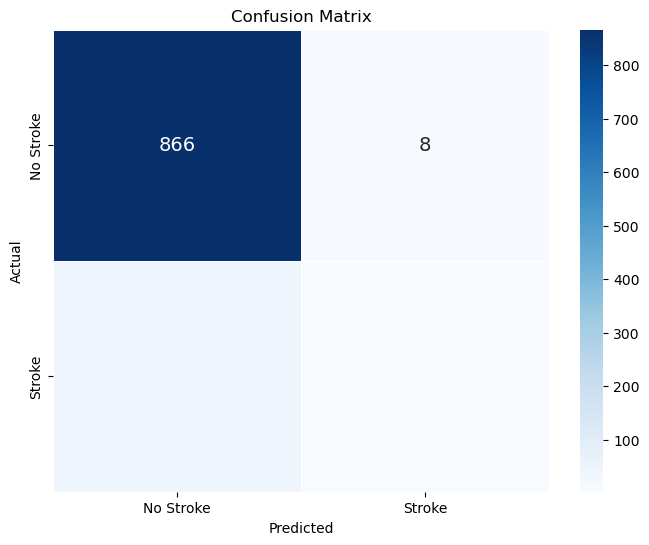

[I 2023-11-30 12:58:10,335] Trial 64 finished with value: 0.9455930590629578 and parameters: {'units_layer': 117, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.013378361656369684, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


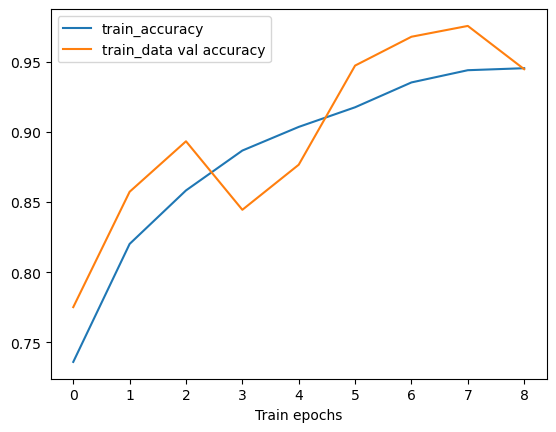

29/29 [==============================] - 0s 313us/step


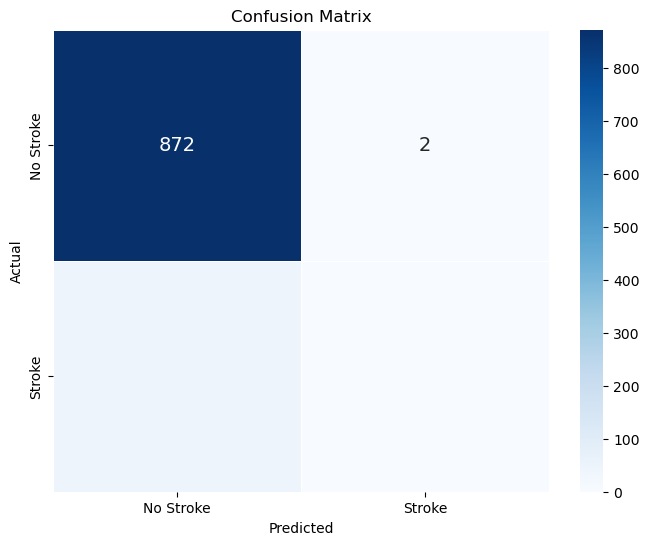

[I 2023-11-30 12:58:11,448] Trial 65 finished with value: 0.9488574266433716 and parameters: {'units_layer': 118, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.014412037562331188, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


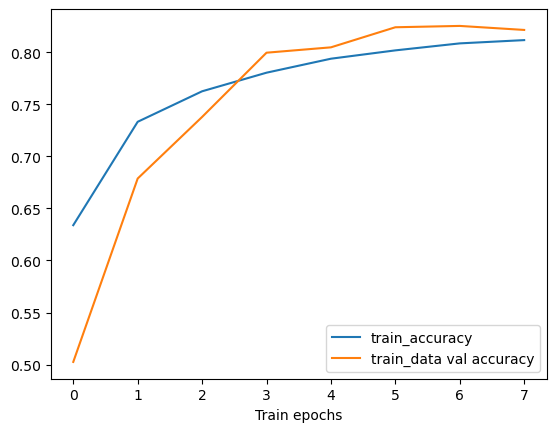

29/29 [==============================] - 0s 324us/step


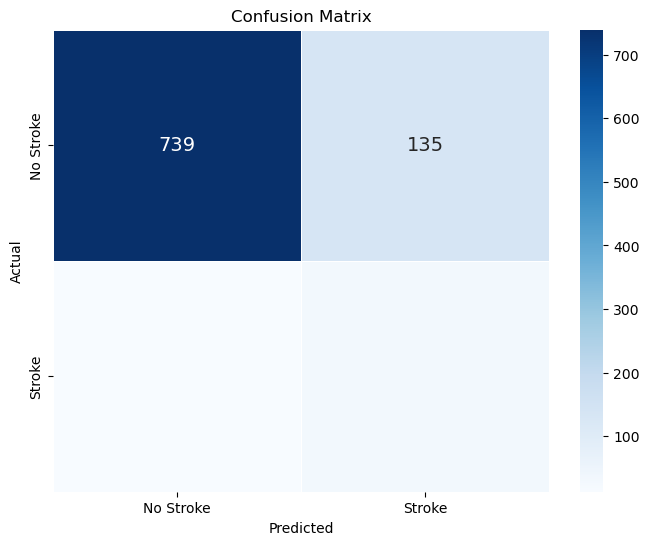

[I 2023-11-30 12:58:12,707] Trial 66 finished with value: 0.8389554023742676 and parameters: {'units_layer': 117, 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.016661339541516502, 'num_epochs': 8}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


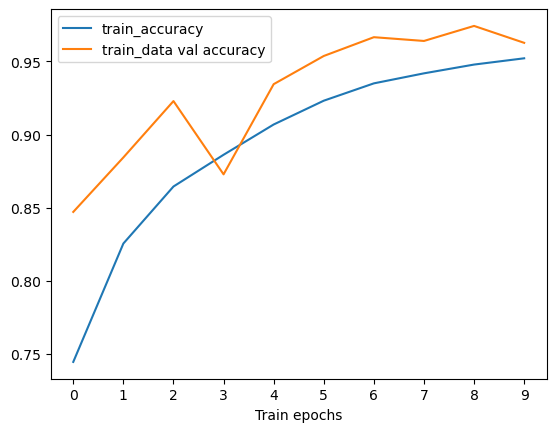

29/29 [==============================] - 0s 330us/step


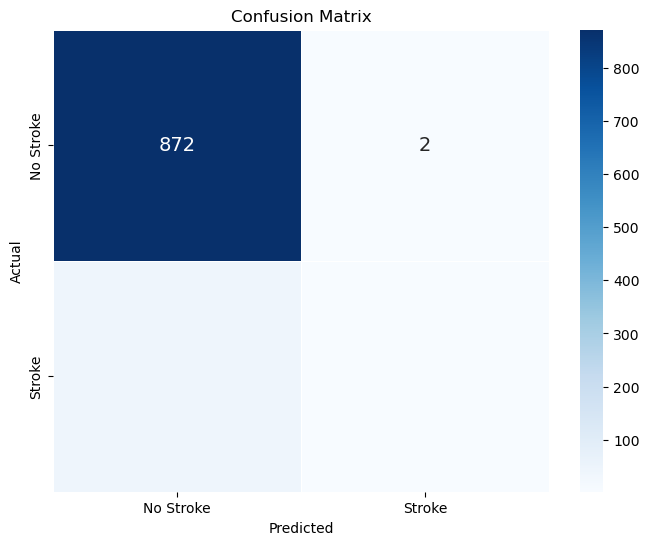

[I 2023-11-30 12:58:13,889] Trial 67 finished with value: 0.9521218538284302 and parameters: {'units_layer': 124, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.014437050726541547, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


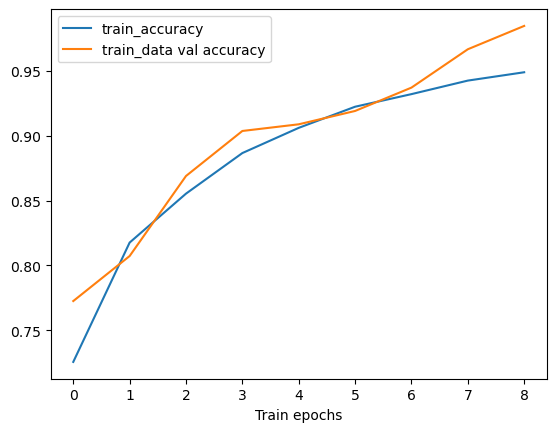

29/29 [==============================] - 0s 309us/step


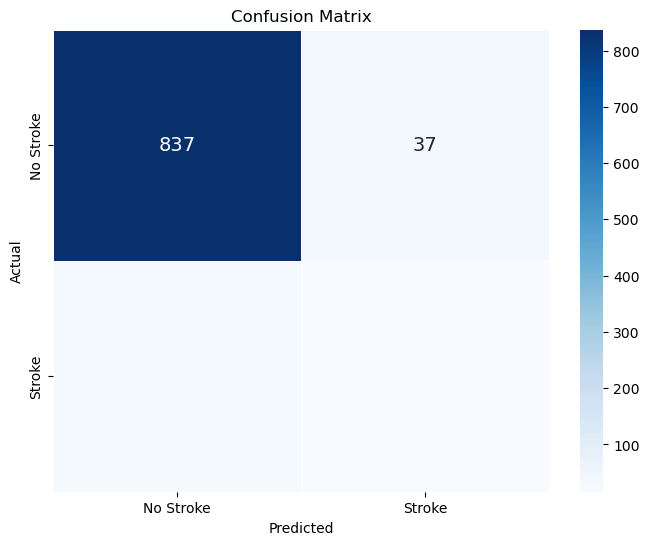

[I 2023-11-30 12:58:14,994] Trial 68 finished with value: 0.9281827807426453 and parameters: {'units_layer': 126, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.014647775468192903, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


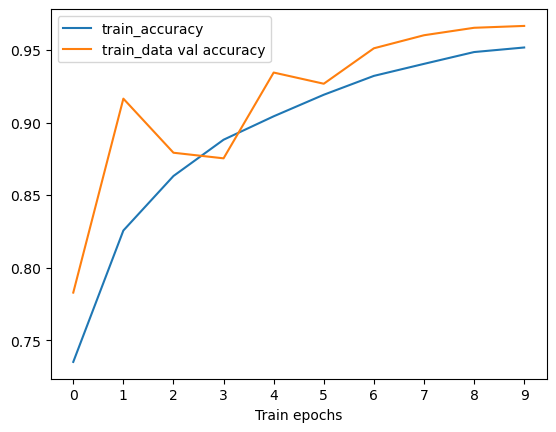

29/29 [==============================] - 0s 320us/step


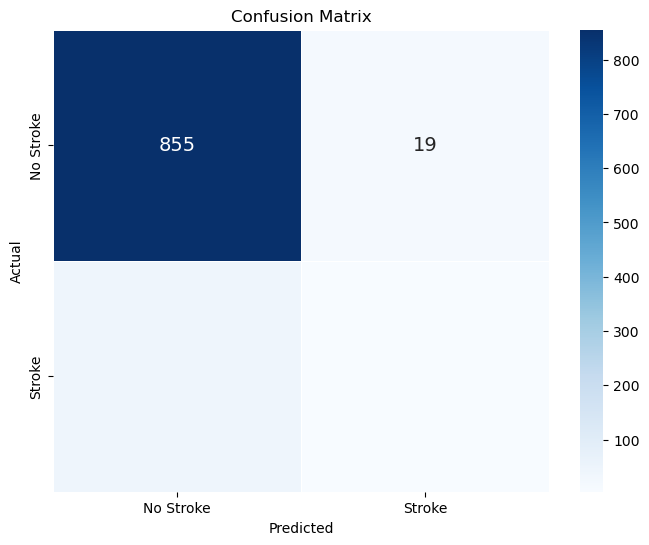

[I 2023-11-30 12:58:16,183] Trial 69 finished with value: 0.9347116351127625 and parameters: {'units_layer': 123, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.017116834833179, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


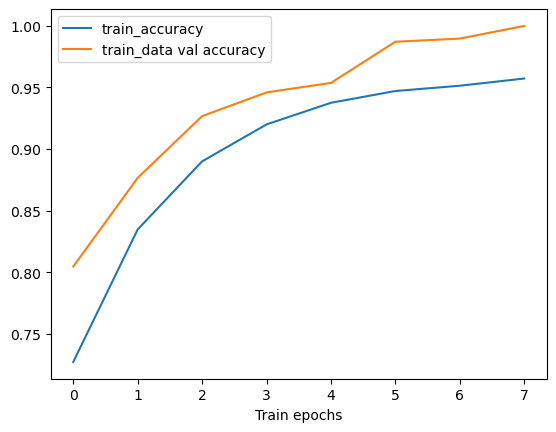

29/29 [==============================] - 0s 300us/step


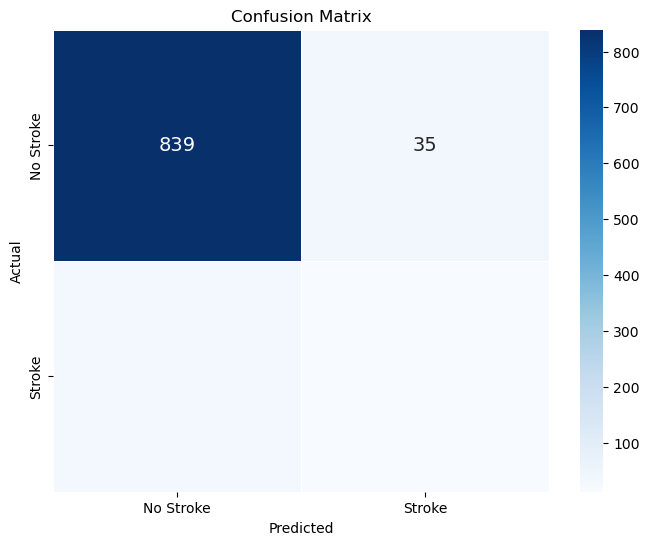

[I 2023-11-30 12:58:17,226] Trial 70 finished with value: 0.926006555557251 and parameters: {'units_layer': 111, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.01579206360974533, 'num_epochs': 8}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


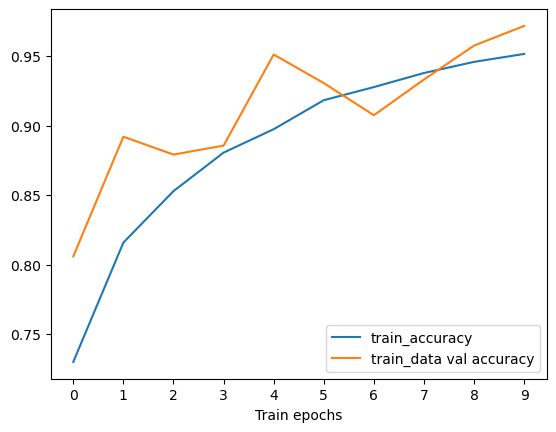

29/29 [==============================] - 0s 317us/step


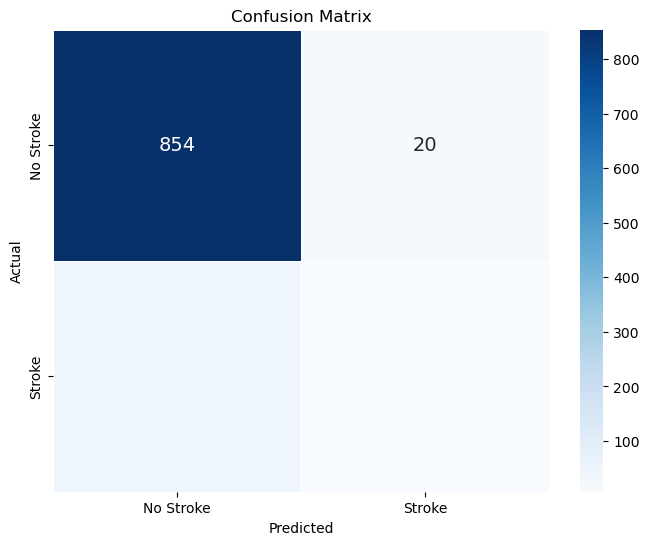

[I 2023-11-30 12:58:18,396] Trial 71 finished with value: 0.9368879199028015 and parameters: {'units_layer': 116, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.01324650138072477, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


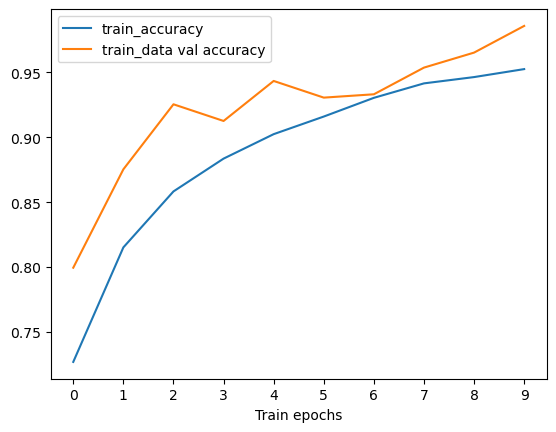

29/29 [==============================] - 0s 317us/step


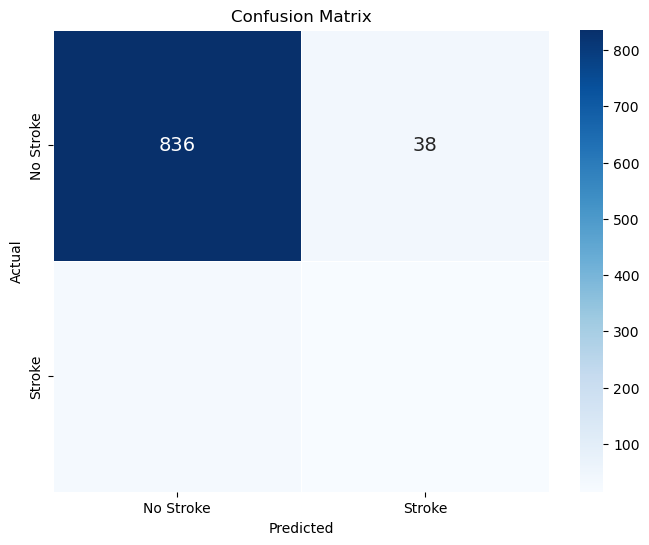

[I 2023-11-30 12:58:19,571] Trial 72 finished with value: 0.926006555557251 and parameters: {'units_layer': 119, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.013932151187077408, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


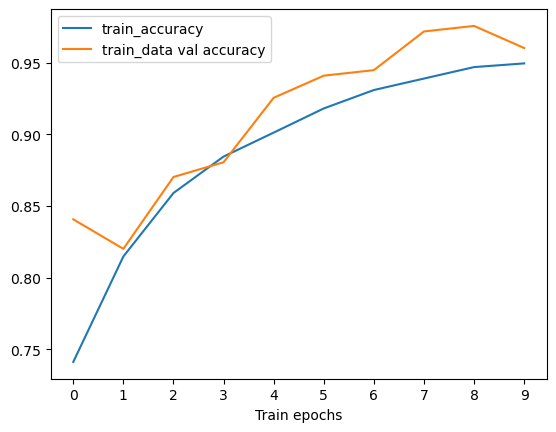

29/29 [==============================] - 0s 312us/step


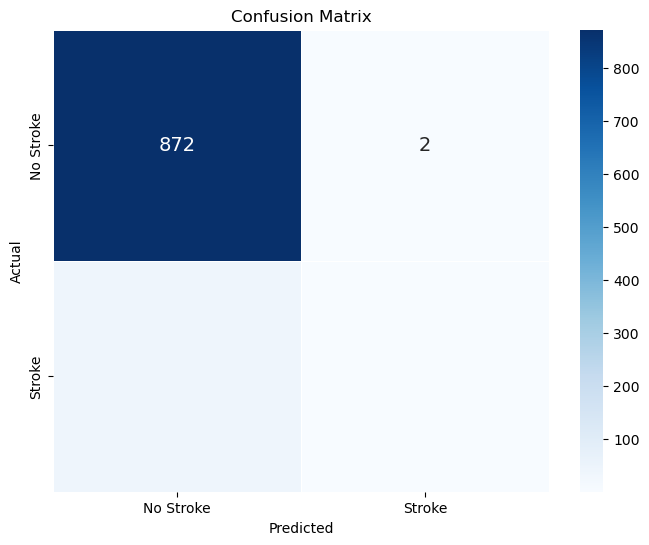

[I 2023-11-30 12:58:20,742] Trial 73 finished with value: 0.9499455690383911 and parameters: {'units_layer': 122, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.012790518069256305, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


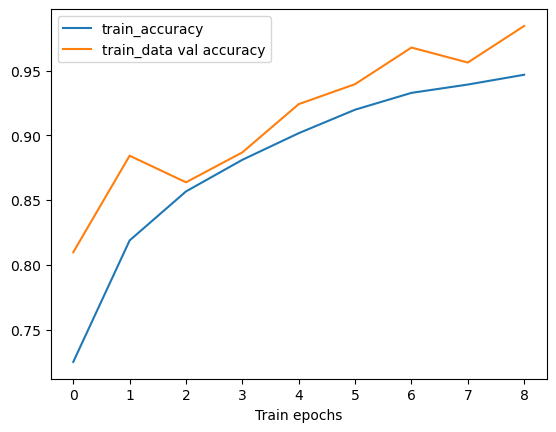

29/29 [==============================] - 0s 317us/step


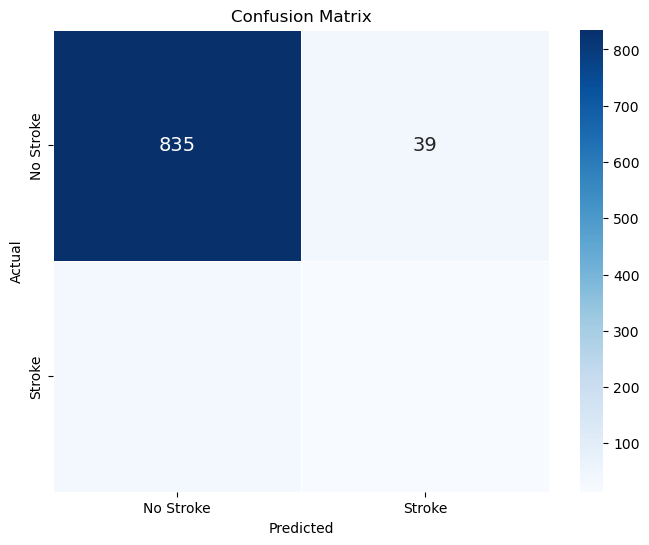

[I 2023-11-30 12:58:21,849] Trial 74 finished with value: 0.9238302707672119 and parameters: {'units_layer': 128, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.01574054002714686, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


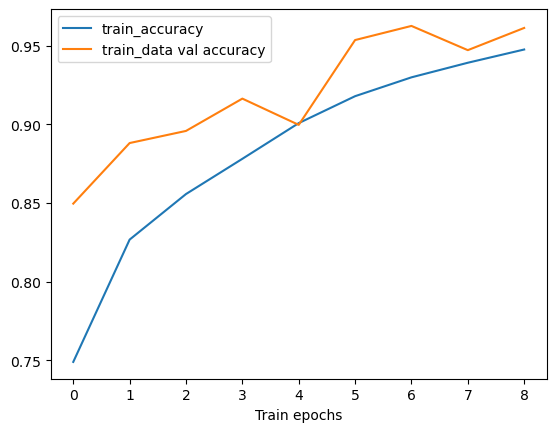

29/29 [==============================] - 0s 321us/step


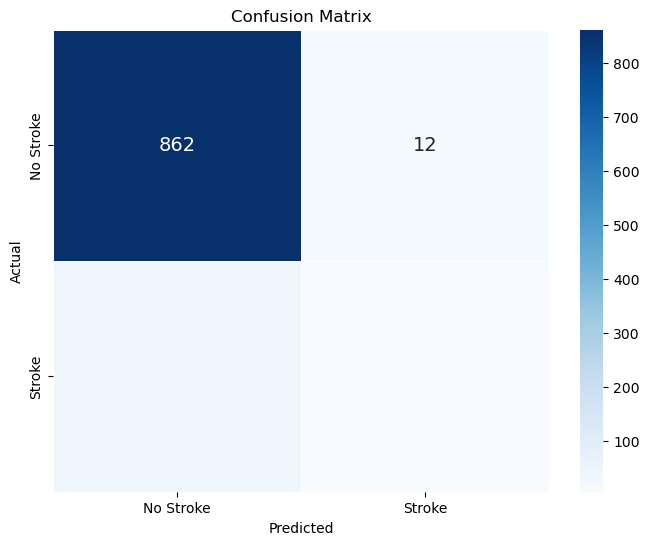

[I 2023-11-30 12:58:22,980] Trial 75 finished with value: 0.9434167742729187 and parameters: {'units_layer': 122, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.014537229104085008, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


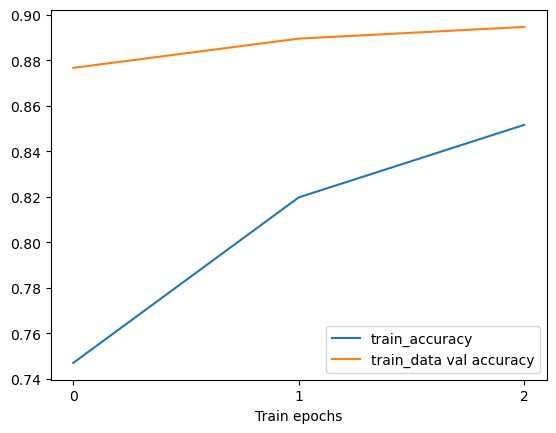

29/29 [==============================] - 0s 341us/step


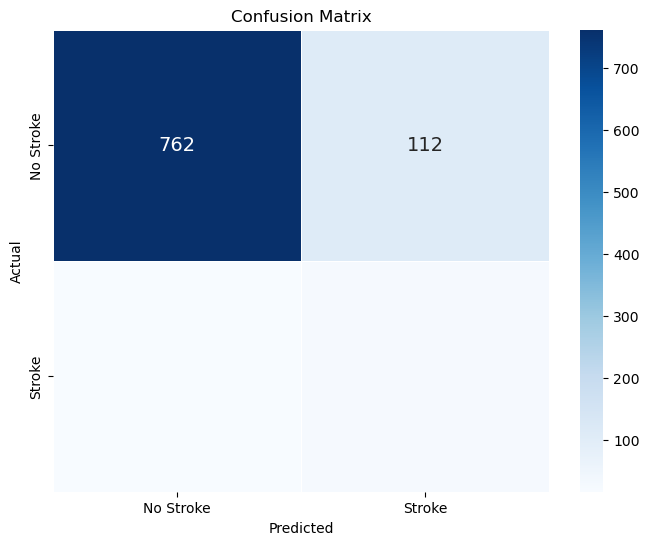

[I 2023-11-30 12:58:23,762] Trial 76 finished with value: 0.8596300482749939 and parameters: {'units_layer': 109, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.012732574904249743, 'num_epochs': 3}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


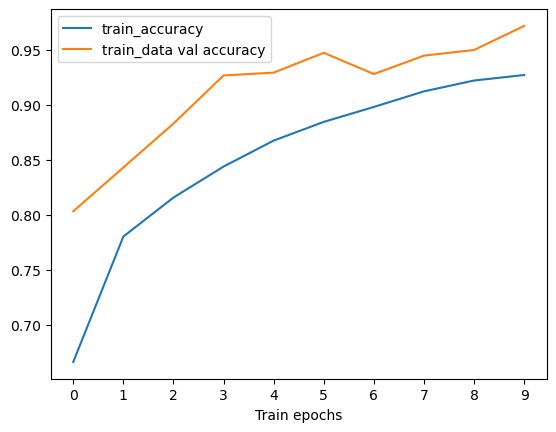

29/29 [==============================] - 0s 334us/step


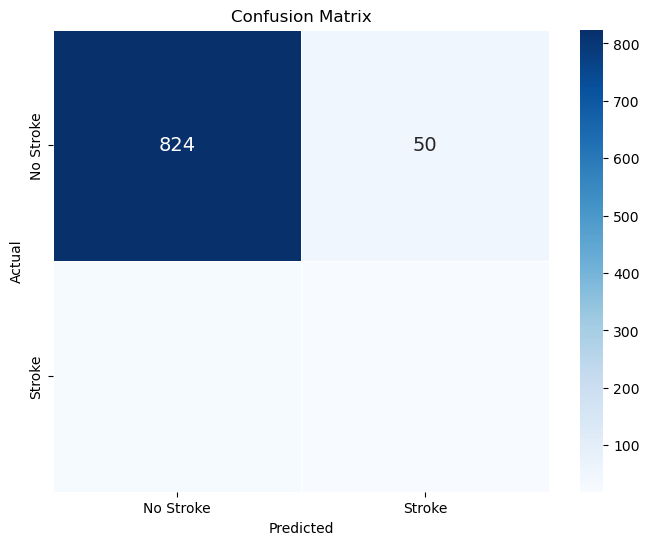

[I 2023-11-30 12:58:25,198] Trial 77 finished with value: 0.9173014163970947 and parameters: {'units_layer': 113, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.011812965434367518, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


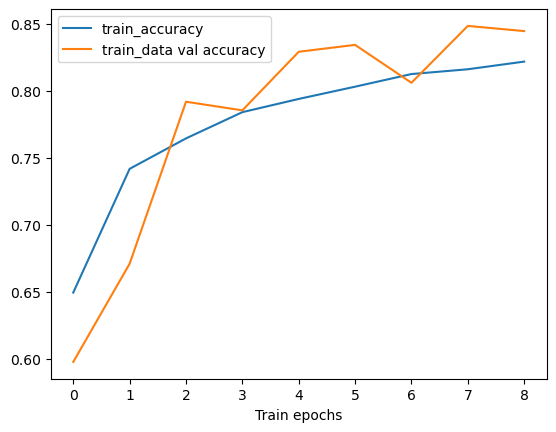

29/29 [==============================] - 0s 381us/step


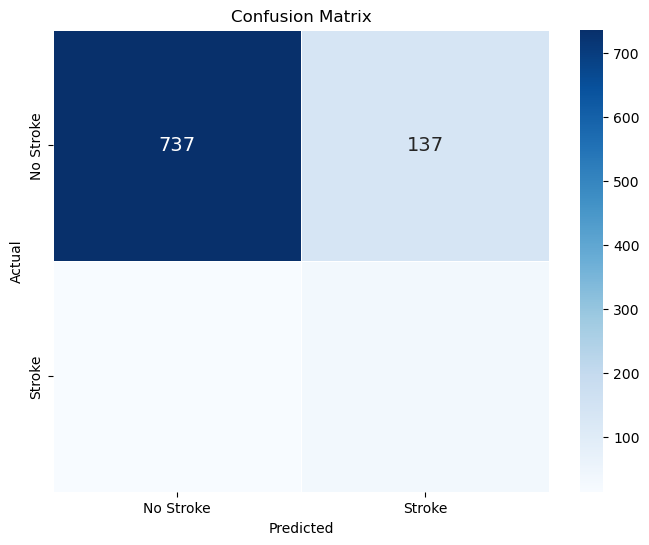

[I 2023-11-30 12:58:26,243] Trial 78 finished with value: 0.835690975189209 and parameters: {'units_layer': 124, 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.01762108961420616, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


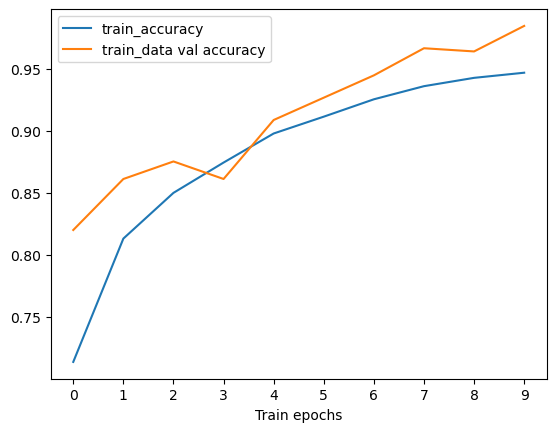

29/29 [==============================] - 0s 313us/step


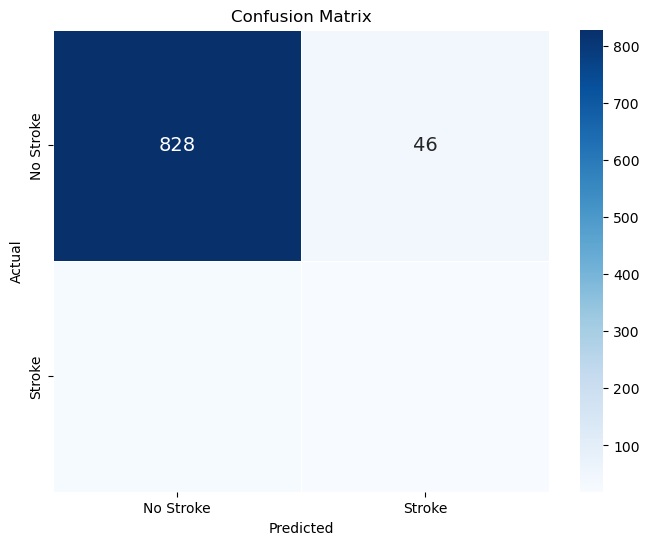

[I 2023-11-30 12:58:27,397] Trial 79 finished with value: 0.9216539859771729 and parameters: {'units_layer': 86, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.014395532581123012, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


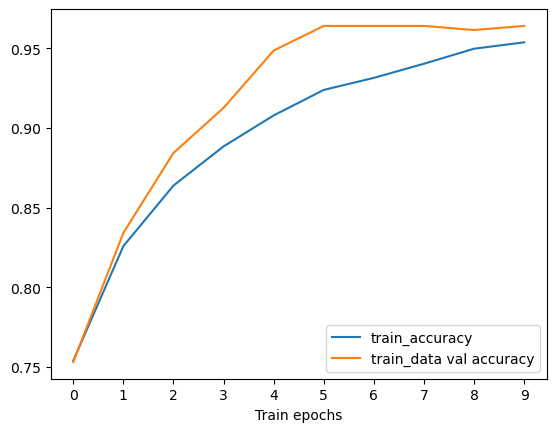

29/29 [==============================] - 0s 309us/step


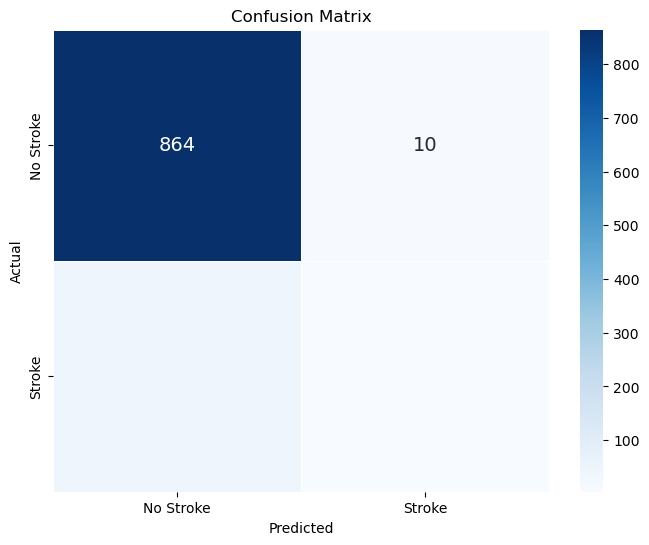

[I 2023-11-30 12:58:28,569] Trial 80 finished with value: 0.9445049166679382 and parameters: {'units_layer': 119, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.015974956909811107, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


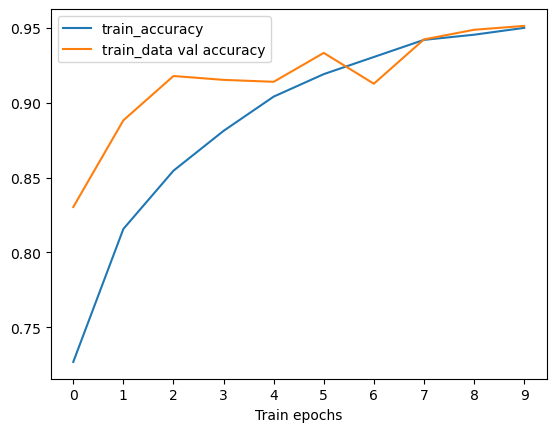

29/29 [==============================] - 0s 308us/step


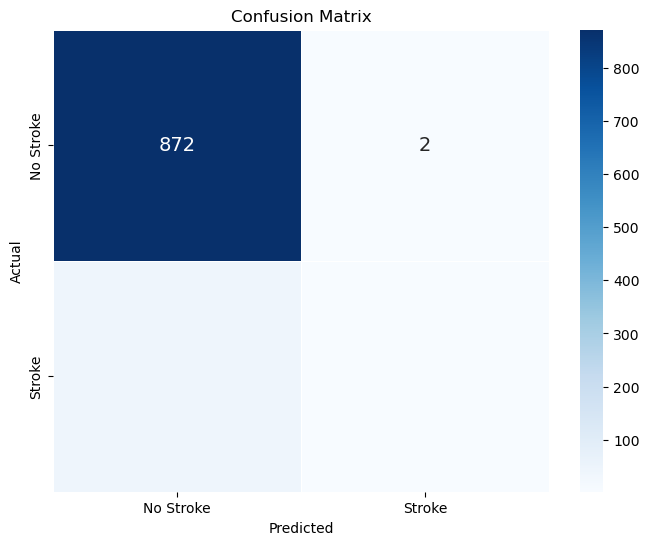

[I 2023-11-30 12:58:29,739] Trial 81 finished with value: 0.9532099962234497 and parameters: {'units_layer': 116, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.012962620700319949, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


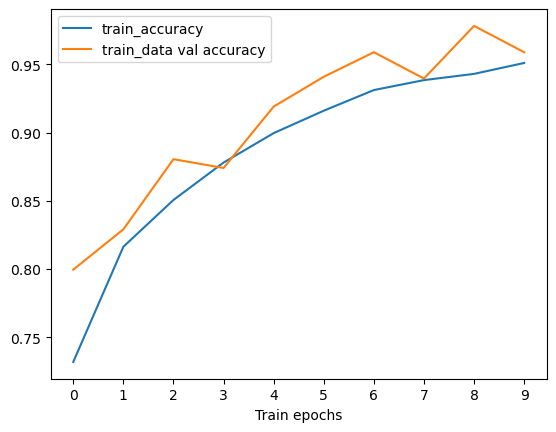

29/29 [==============================] - 0s 308us/step


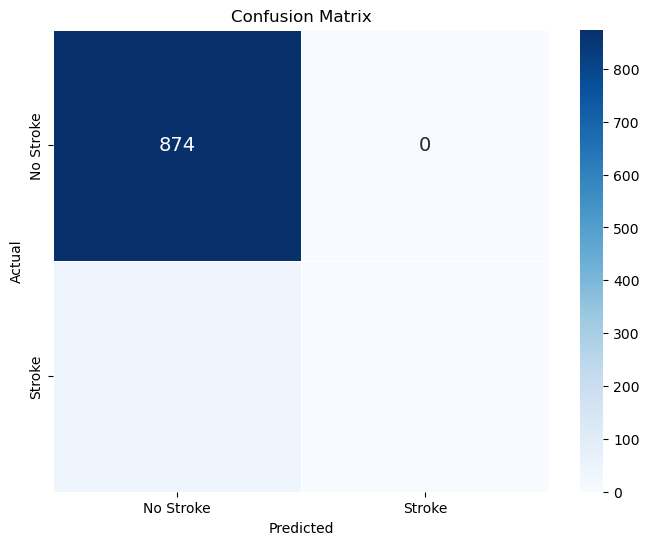

[I 2023-11-30 12:58:30,903] Trial 82 finished with value: 0.9521218538284302 and parameters: {'units_layer': 108, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.013029582433972623, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


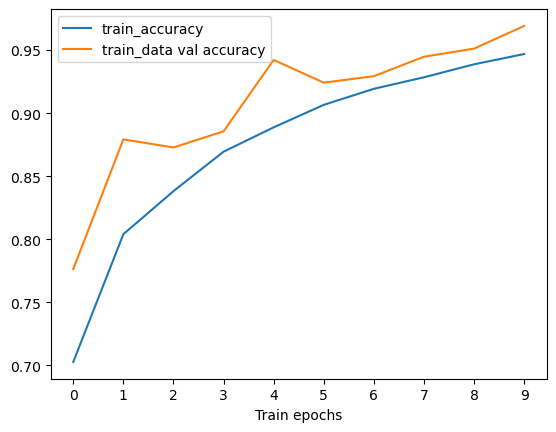

29/29 [==============================] - 0s 319us/step


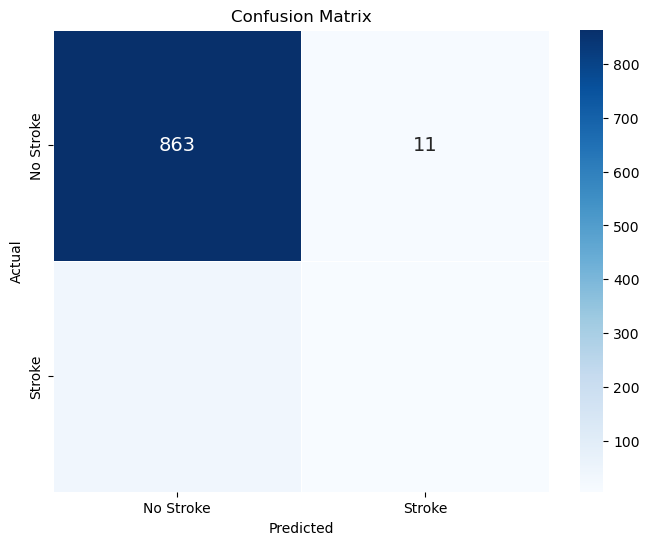

[I 2023-11-30 12:58:32,075] Trial 83 finished with value: 0.9455930590629578 and parameters: {'units_layer': 107, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.012453956919689728, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


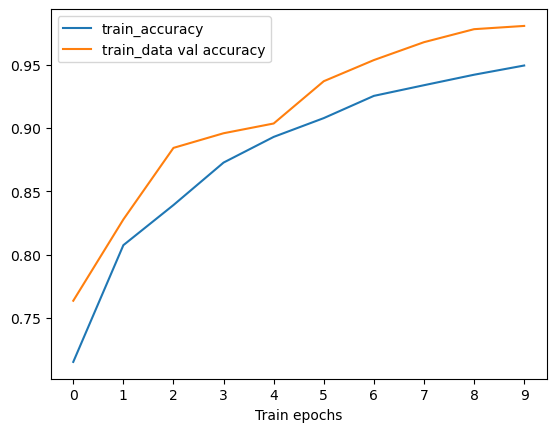

29/29 [==============================] - 0s 483us/step


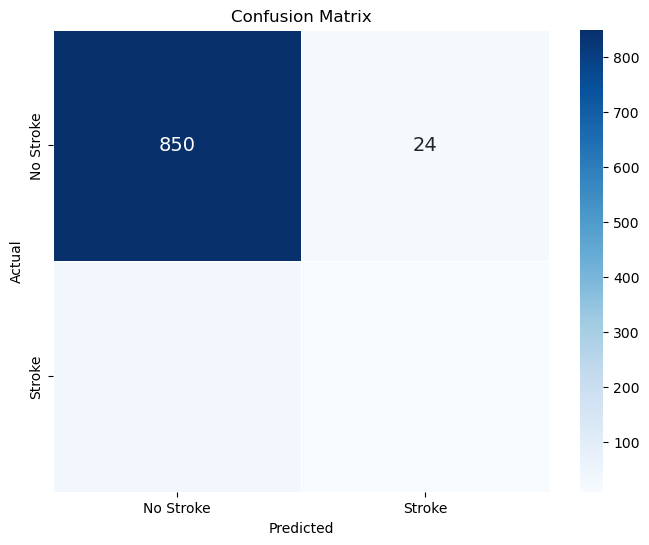

[I 2023-11-30 12:58:33,257] Trial 84 finished with value: 0.935799777507782 and parameters: {'units_layer': 114, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.012916869128205553, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


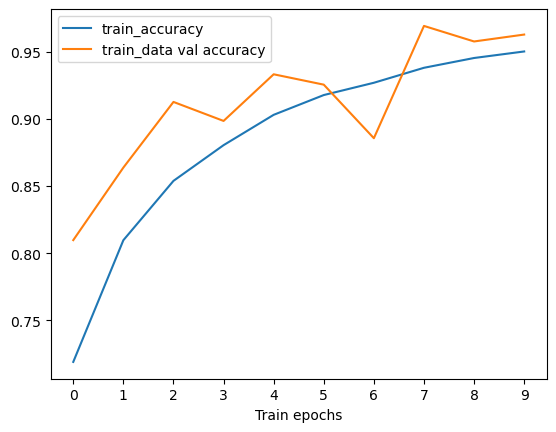

29/29 [==============================] - 0s 310us/step


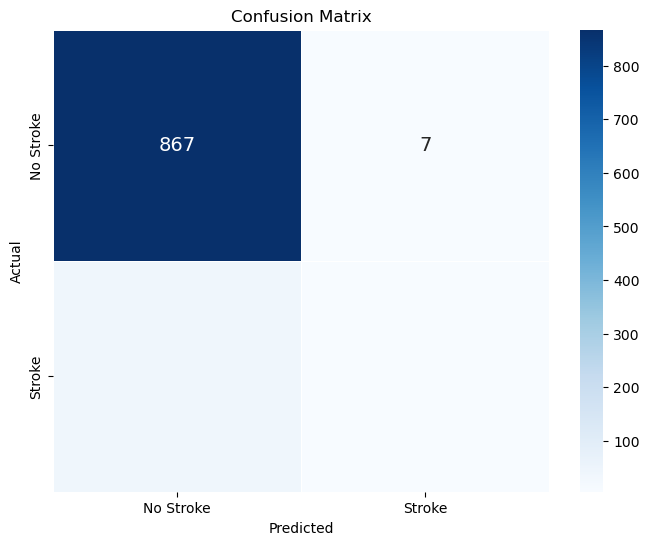

[I 2023-11-30 12:58:34,415] Trial 85 finished with value: 0.9488574266433716 and parameters: {'units_layer': 89, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.01374943836976886, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


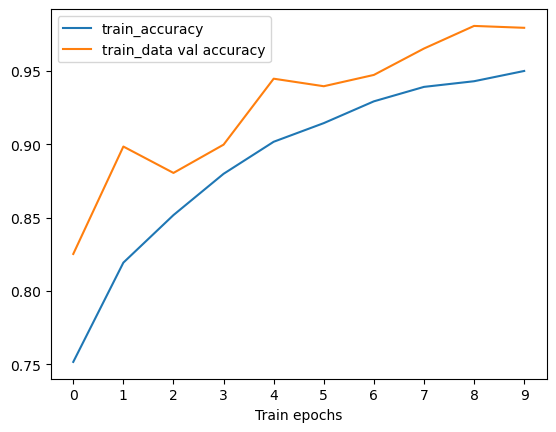

29/29 [==============================] - 0s 347us/step


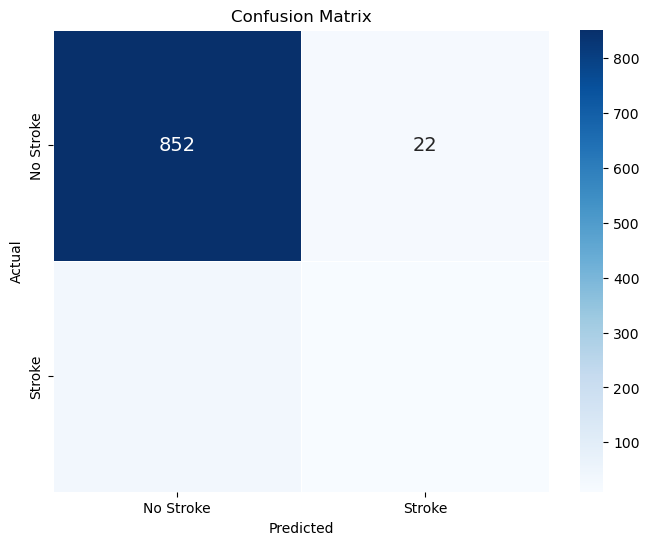

[I 2023-11-30 12:58:35,589] Trial 86 finished with value: 0.937976062297821 and parameters: {'units_layer': 98, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.015230263407934914, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


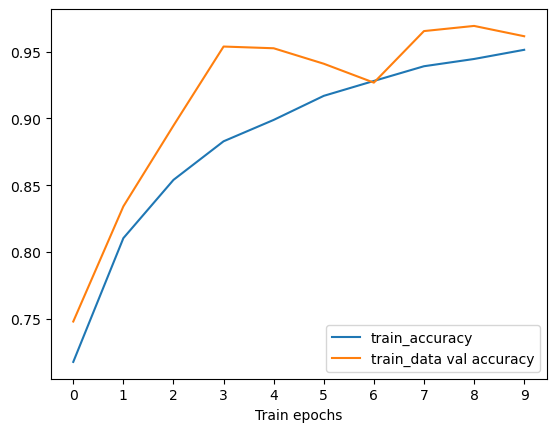

29/29 [==============================] - 0s 317us/step


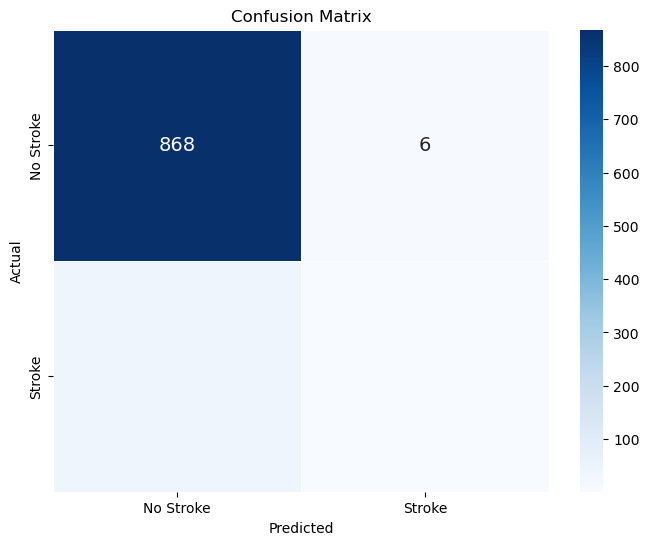

[I 2023-11-30 12:58:36,773] Trial 87 finished with value: 0.9455930590629578 and parameters: {'units_layer': 109, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.013821257604969365, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


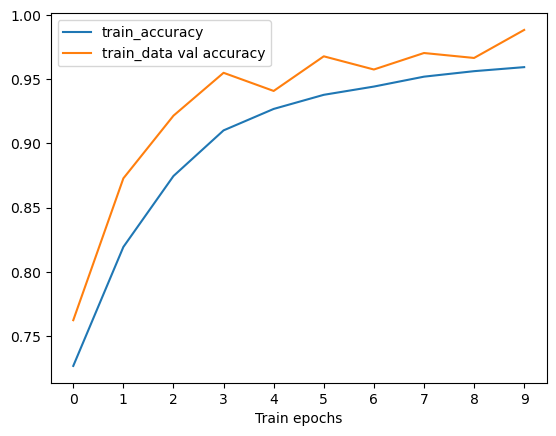

29/29 [==============================] - 0s 307us/step


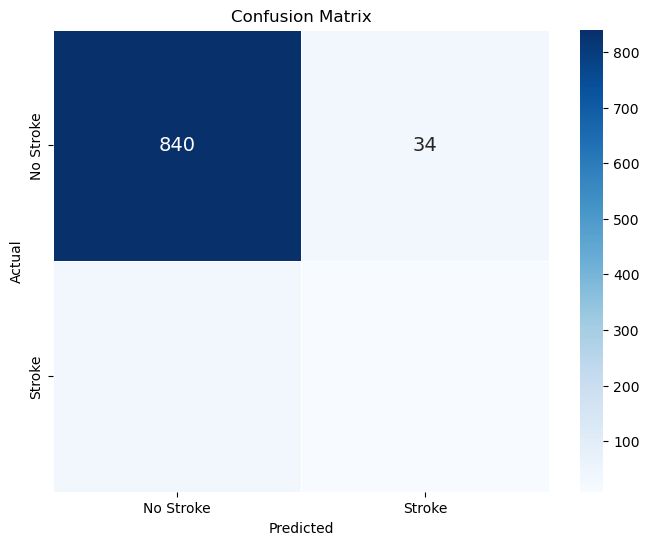

[I 2023-11-30 12:58:37,956] Trial 88 finished with value: 0.9238302707672119 and parameters: {'units_layer': 94, 'activation': 'relu', 'optimizer': 'Adam', 'learning_rate': 0.012120164878619662, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


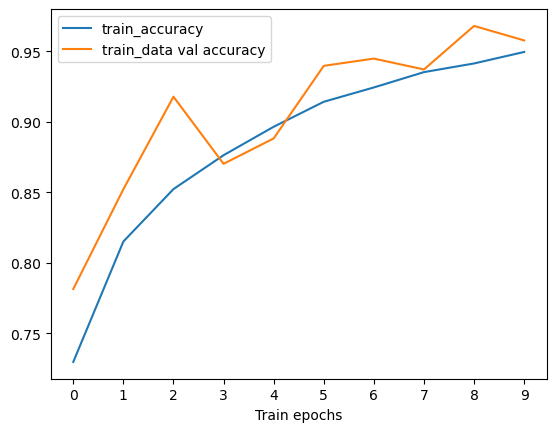

29/29 [==============================] - 0s 310us/step


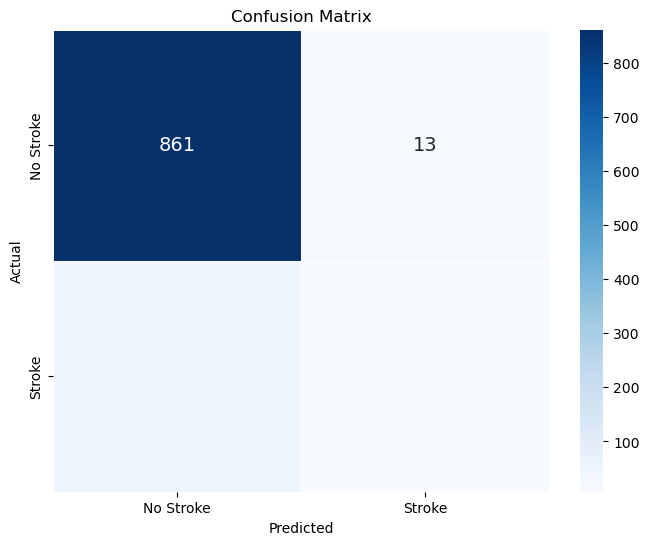

[I 2023-11-30 12:58:39,315] Trial 89 finished with value: 0.9445049166679382 and parameters: {'units_layer': 89, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.013200616909230209, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


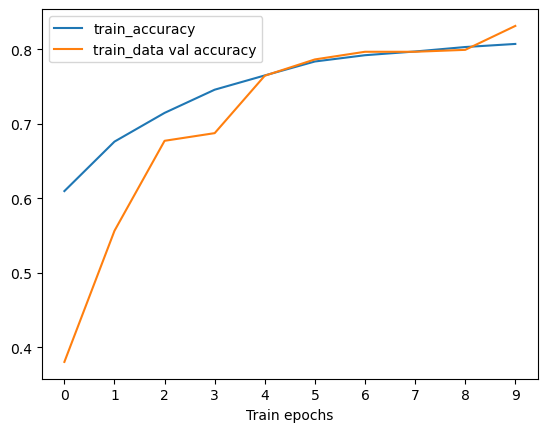

29/29 [==============================] - 0s 311us/step


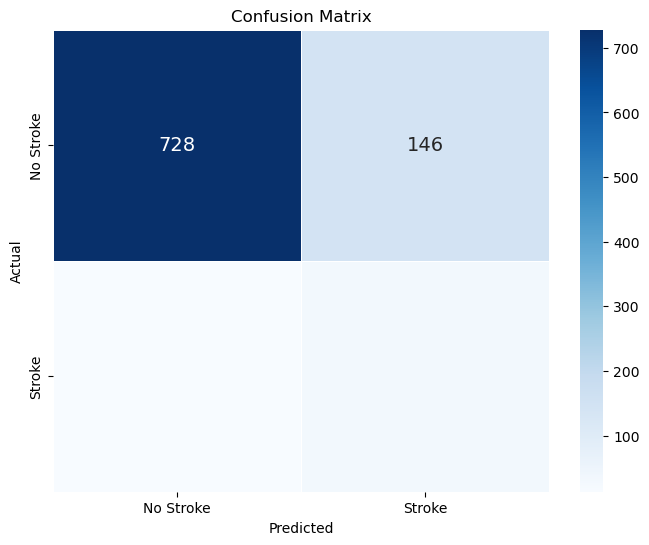

[I 2023-11-30 12:58:40,452] Trial 90 finished with value: 0.8269858360290527 and parameters: {'units_layer': 124, 'activation': 'tanh', 'optimizer': 'SGD', 'learning_rate': 0.01172367932836877, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


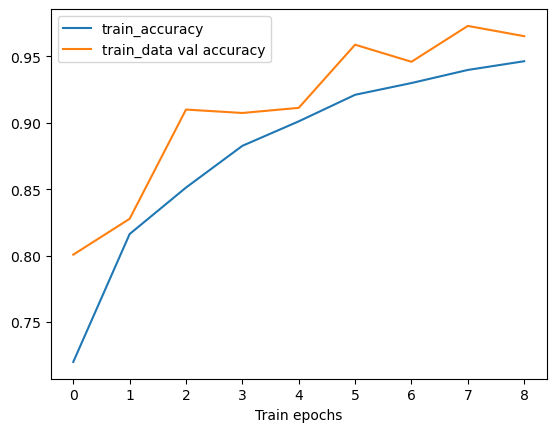

29/29 [==============================] - 0s 308us/step


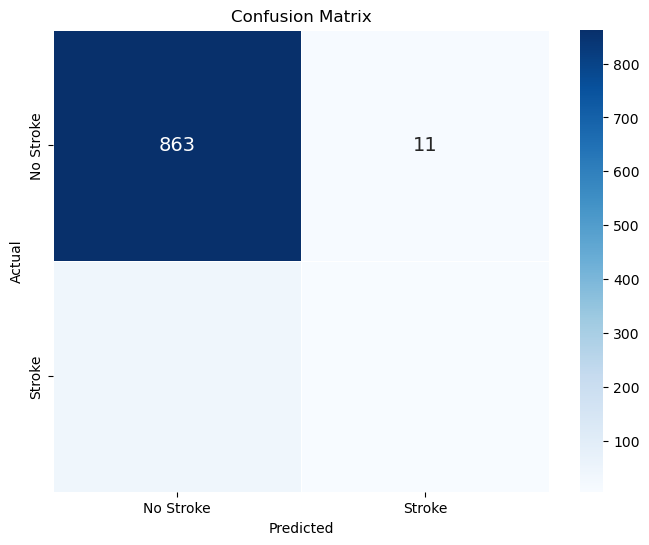

[I 2023-11-30 12:58:41,602] Trial 91 finished with value: 0.9445049166679382 and parameters: {'units_layer': 106, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.014139276421121824, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


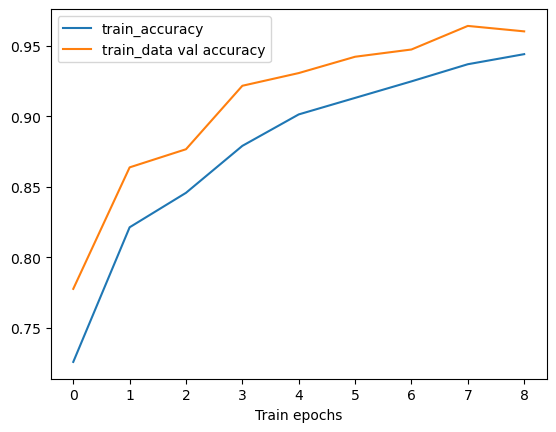

29/29 [==============================] - 0s 309us/step


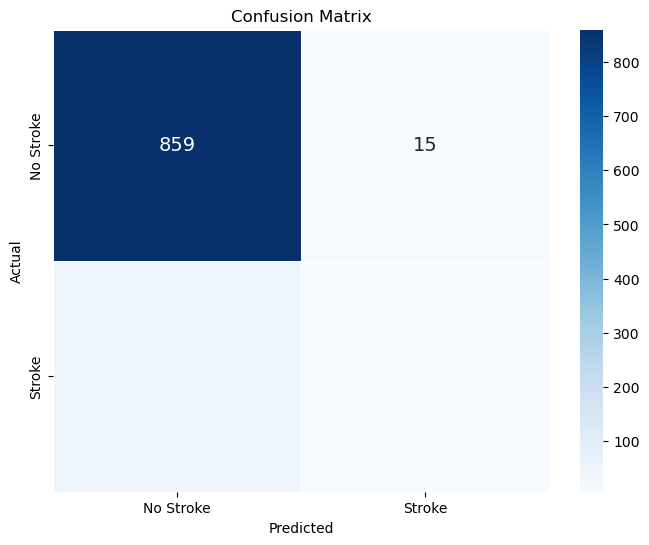

[I 2023-11-30 12:58:42,696] Trial 92 finished with value: 0.9423286318778992 and parameters: {'units_layer': 84, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.01506949731193089, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


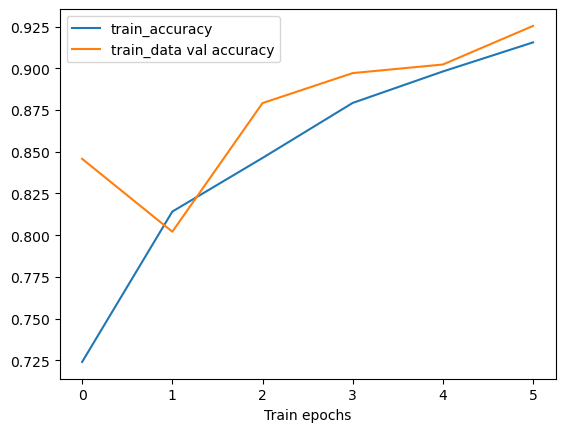

29/29 [==============================] - 0s 311us/step


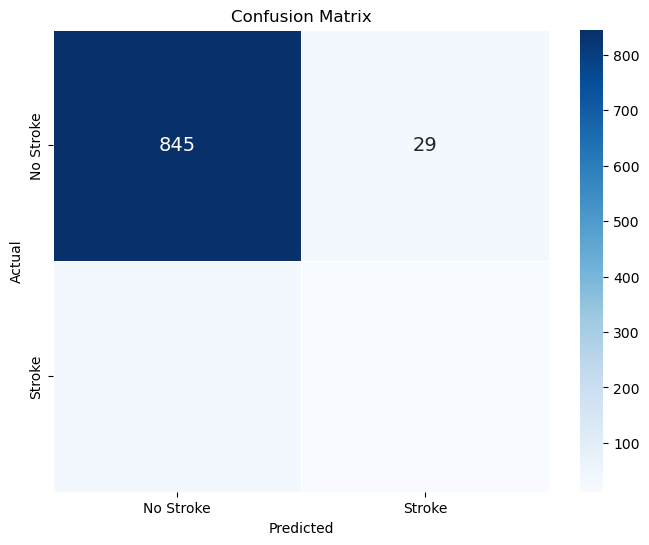

[I 2023-11-30 12:58:43,634] Trial 93 finished with value: 0.9325353503227234 and parameters: {'units_layer': 111, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.016540155560706364, 'num_epochs': 6}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


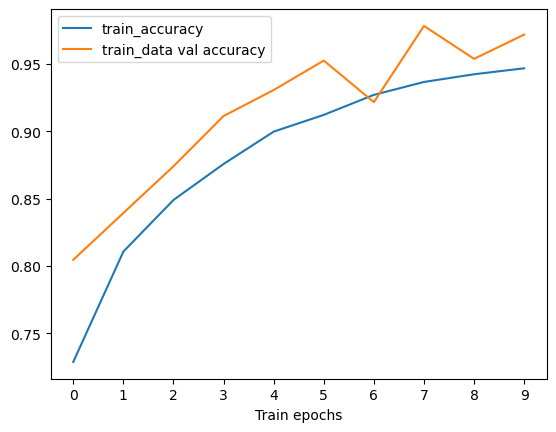

29/29 [==============================] - 0s 313us/step


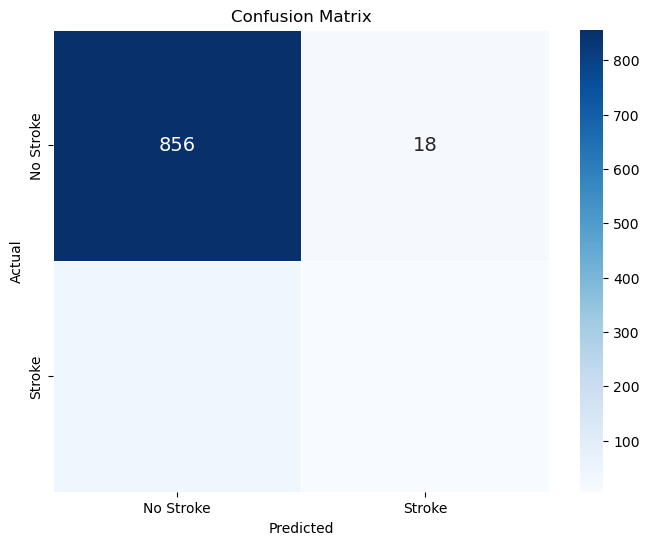

[I 2023-11-30 12:58:44,801] Trial 94 finished with value: 0.937976062297821 and parameters: {'units_layer': 100, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.013025974009712676, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


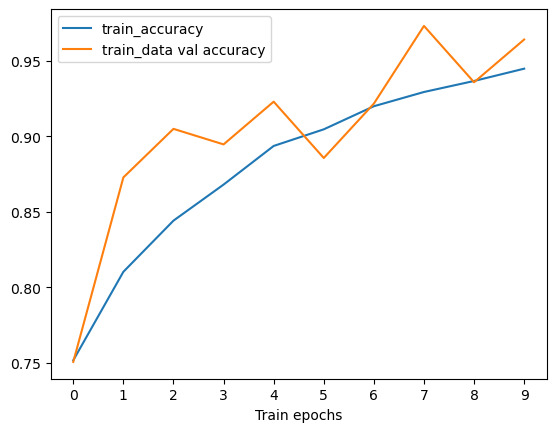

29/29 [==============================] - 0s 315us/step


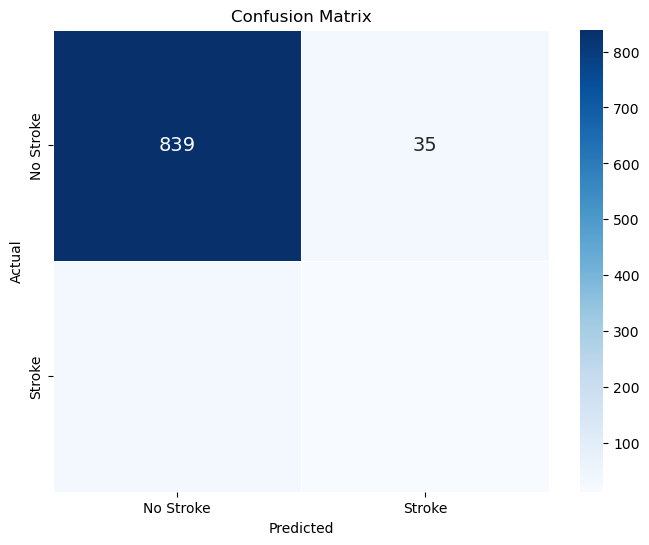

[I 2023-11-30 12:58:45,952] Trial 95 finished with value: 0.9270946383476257 and parameters: {'units_layer': 72, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.014010484550134518, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


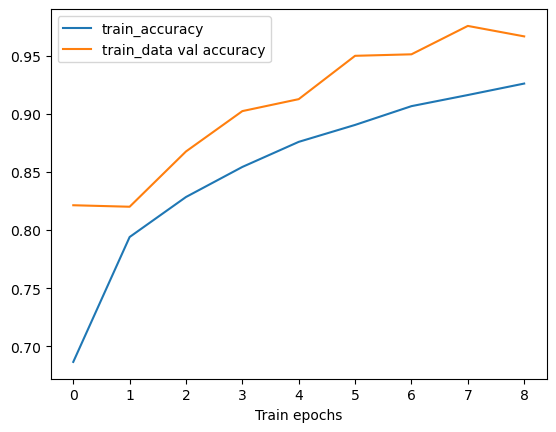

29/29 [==============================] - 0s 312us/step


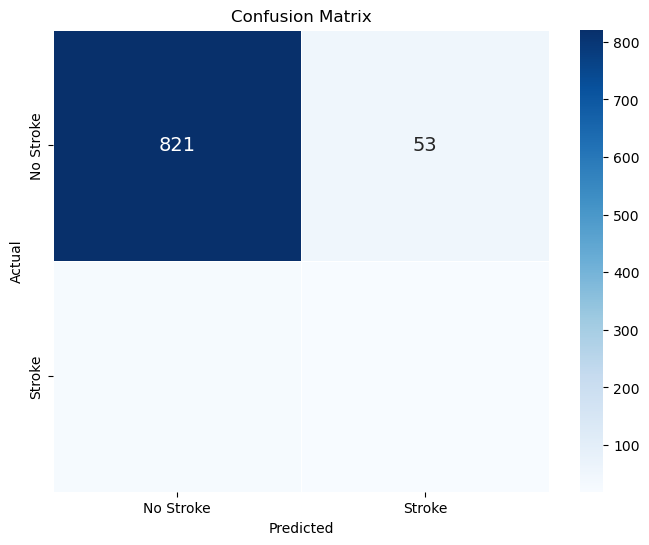

[I 2023-11-30 12:58:47,074] Trial 96 finished with value: 0.9140369892120361 and parameters: {'units_layer': 113, 'activation': 'sigmoid', 'optimizer': 'Adam', 'learning_rate': 0.019385875770034085, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


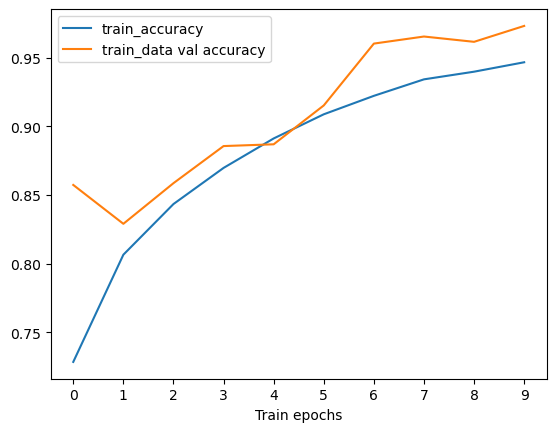

29/29 [==============================] - 0s 320us/step


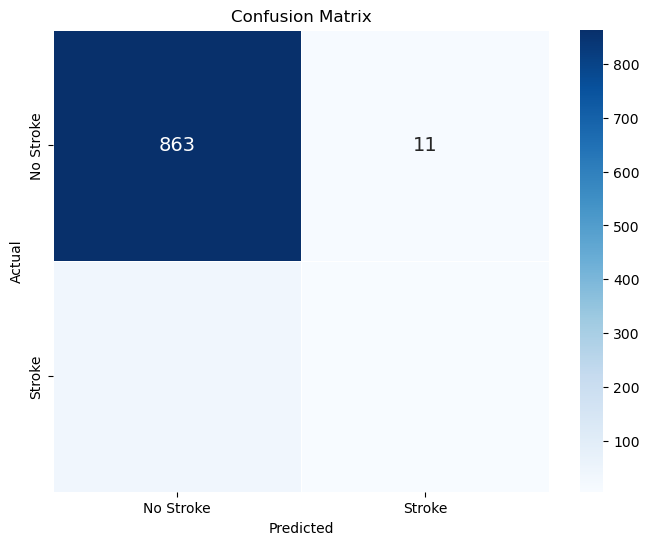

[I 2023-11-30 12:58:48,248] Trial 97 finished with value: 0.9455930590629578 and parameters: {'units_layer': 91, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.01102203230489722, 'num_epochs': 10}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


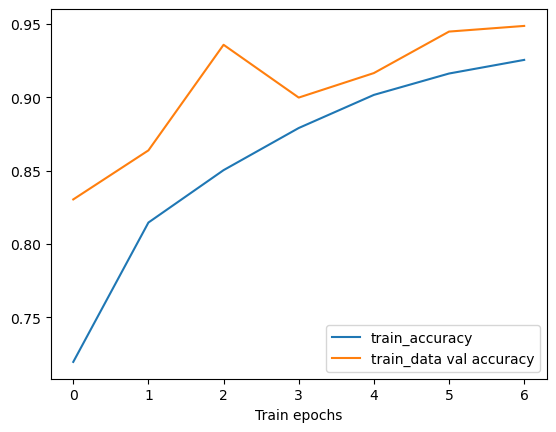

29/29 [==============================] - 0s 312us/step


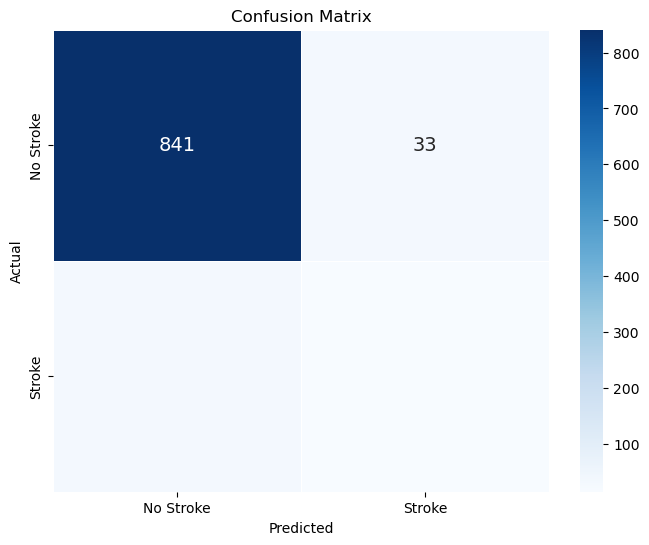

[I 2023-11-30 12:58:49,255] Trial 98 finished with value: 0.9303590655326843 and parameters: {'units_layer': 128, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.012341867212662989, 'num_epochs': 7}. Best is trial 40 with value: 0.9532099962234497.


X_DL_train.shape =  (7778, 34)
X_DL_val.shape =  (919, 34)
Y_DL_train.shape =  (7778,)
Y_DL_val.shape =  (919,)
Training model ...


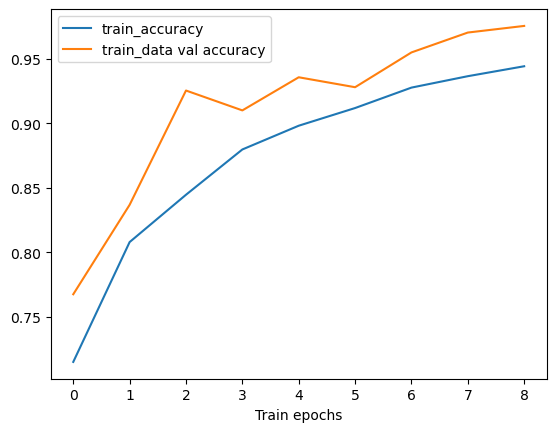

29/29 [==============================] - 0s 314us/step


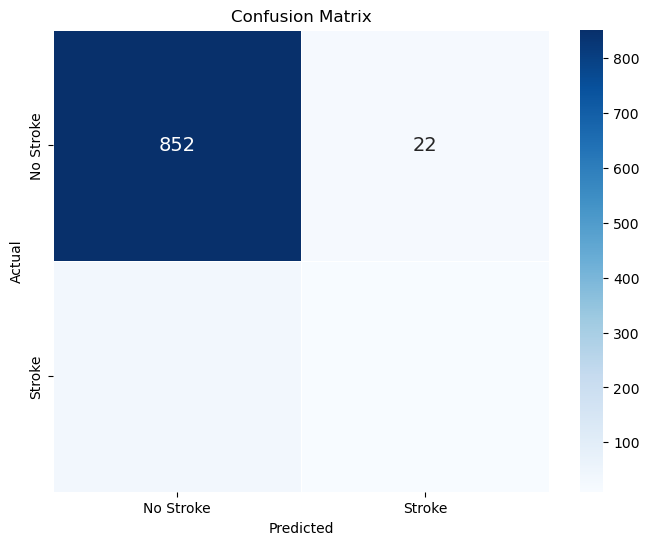

[I 2023-11-30 12:58:50,362] Trial 99 finished with value: 0.937976062297821 and parameters: {'units_layer': 102, 'activation': 'tanh', 'optimizer': 'Adam', 'learning_rate': 0.011620901109766378, 'num_epochs': 9}. Best is trial 40 with value: 0.9532099962234497.


In [35]:
# Optuna hyperparameters

def func(trial):
    hidden_layer_sizes = trial.suggest_int('units_layer', 1, 128)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    optimizer = trial.suggest_categorical('optimizer', ['SGD', 'Adam'])
    learning_rate = trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True)
    num_epochs = trial.suggest_int('num_epochs', 1, 10)
    
    result = train_and_evaluate(hidden_layer_sizes=[hidden_layer_sizes],
                                activation=activation,
                                optimizer=optimizer,
                                learning_rate=learning_rate,
                                num_epochs=num_epochs)
    
    return result['validation_accuracy']

study = optuna.create_study(direction='maximize')
study.optimize(func, n_trials = 100)